<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Belgium/Umicore/Umicore_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UMIBEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 15:57:58,972 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 15:57:58,976 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for UMIBEEUR
2019-08-25 16:00:36,724 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 16:06:56,924 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 16:09:44,694 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 16:13:06,499 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 16:16:36,964 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 16:20:00,030 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 16:23:26,672 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 16:26:19,425 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-25 16:36:30,835 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_UMIBEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-UMIBEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-UMIBEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.39313  0.39368  0.39041  0.39291  1.853781
2018-01-02 09:00:00  0.39304  0.39357  0.39098  0.39217  2.540398
2018-01-02 10:00:00  0.39218  0.39498  0.39218  0.39412  1.927084
2018-01-02 11:00:00  0.39403  0.39497  0.39245  0.39459  1.878809
2018-01-02 12:00:00  0.39459  0.39538  0.39275  0.39467  1.138801
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.34768  0.35076  0.34653  0.34827  0.097786
2018-12-31 09:00:00  0.34837  0.35018  0.34739  0.34927  0.164891
2018-12-31 10:00:00  0.34938  0.35008  0.34877  0.34987  0.127985
2018-12-31 11:00:00  0.34969  0.34969  0.34647  0.34657  0.126841
2018-12-31 12:00:00  0.34644  0.34758  0.34544  0.34737  0.139223

[2276 rows x 5 columns]

Open         High          Low        Close       Volume
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000
mean      0.450531     0.452259     0.448705     0.450477     2.554685
std       0.043798     0.043662     0.043942     0.043809     1.901031
min       0.335330     0.338180     0.335330     0.337280     0.005587
25%       0.422888     0.424780     0.420970     0.422770     1.251239
50%       0.458280     0.459685     0.456440     0.458185     2.236246
75%       0.485960     0.487182     0.484435     0.485765     3.430533
max       0.536060     0.539070     0.529660     0.531880    20.846529

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.43714  0.43803  0.43619  0.43659  2.795759    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.435500  0.425646  0.433190  0.437494  0.435600  0.434108    0.435630    0.435455  0.430701  0.435791  0.436743  0.435895  0.436214  0.435791  0.436507  0.431061                0.438216                 0.435791                0.433366                0.439429                 0.435791                0.432154                0.440641                 0.435791                0.430941                0.441854                 0.435791                0.429729  0.435600  0.436552  0.432018                0.438025                 0.435600                0.433175                0.439237                 0.435600                0.431962                0.440450                 0.435600                0.430750                0.441662                 0.435600   
2018-01-09 14:00:00  0.43662  0.43798  0.43579  0.43588  2.878885    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.435519  0.425893  0.434158  0.437184  0.435662  0.434160    0.435655    0.435610  0.431287  0.436022  0.436310  0.436146  0.436234  0.436022  0.436235  0.431745                0.438052                 0.436022                0.433993                0.439067                 0.436022                0.432978                0.440082                 0.436022                0.431963                0.441097                 0.436022                0.430948  0.435662  0.436136  0.432645                0.437692                 0.435662                0.433632                0.438707                 0.435662                0.432617                0.439721                 0.435662                0.431603                0.440736                 0.435662   
2018-01-09 15:00:00  0.43587  0.43798  0.43587  0.43748 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000    2226.000000  2226.000000   2226.000000      2226.00000     2226.000000       2226.000000  2226.000000  2226.000000  2226.000000  2226.000000   2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000  2226.000000  2226.000000  2226.000000             2226.000000              2226.000000             2226.000000             2226.000000              2226.000000             2226.000000             2226.000000   
mean      0.451324     0.453051     0.449480     0.451254     2.560284    15.997754     2.019317   185.434412      30.424978    11.378706      0.034142         0.02381        0.002246          0.004043     6.597484     2.533693    26.942498     2.019317      2.005391    26.942498     0.451368     0.451650    -0.023312     0.451258     0.451392     0.451438     0.451424     0.451375     0.451492     0.451393     0.451254     0.451393     0.451347     0.451393     0.451295     0.451657                0.456885                 0.451393                0.445902                0.459631                 0.451393                0.443156                0.462376                 0.451393                0.440410                0.465122                 0.451393                0.437665     0.451392     0.451289     0.451619                0.456884                 0.451392                0.445901                0.459629                 0.451392                0.443155                0.462375   
std       0.043909     0.043771     0.044071     0.043933     1.916809     8.580275     1.412969   101.878449       0.852747     2.618495      0.181635         0.15249        0.047351          0.063471     3.352634     1.102800    14.554456     1.412969      1.404317    14.554456     0.043579     0.042864     0.452880     0.043990     0.043555     0.043496     0.043596     0.043690     0.043826     0.043619     0.043963     0.043647     0.043702     0.043619     0.043857     0.043004                0.043259                 0.043619                0.044300                0.043203                 0.043619                0.044757                0.043229                 0.043619                0.045288                0.043338                 0.043619                0.045891     0.043555     0.043842     0.043097                0.043198                 0.043555                0.044234                0.043143                 0.043555                0.044690                0.043171   
min       0.335330     0.338180     0.3353

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.507199  0.497038  0.519014  0.510329  0.133879    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.508598  0.449745  0.911991  0.516380  0.502449  0.489739    0.502542    0.504250  0.468100  0.505996  0.512905  0.506506  0.507317  0.505996  0.511237  0.476602                0.468893                 0.505996                0.517157                0.445525                 0.505996                0.524082                0.422646                 0.505996                0.530851                0.401650                 0.505996                0.537370  0.502449  0.511011  0.482081                0.476938                 0.502449                0.518169                0.452609                 0.502449                0.525143                0.428792                 0.502449                0.531856                0.406475                 0.502449   
2018-01-09 14:00:00  0.504608  0.496789  0.516956  0.506680  0.137868    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.508699  0.451111  0.912899  0.514774  0.502782  0.490021    0.502674    0.505069  0.470978  0.507219  0.510682  0.507825  0.507422  0.507219  0.509827  0.480343                0.468076                 0.507219                0.520404                0.443825                 0.507219                0.528273                0.420170                 0.507219                0.535949                0.398489                 0.507219                0.543340  0.502782  0.508840  0.485492                0.475237                 0.502782                0.520528                0.450055                 0.502782                0.528456                0.425495                 0.502782                0.536087                0.402531                 0.502782   
2018-01-09 15:00:00  0.500872  0.496789  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 36 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_t6jekr
H2O cluster total nodes:    1
H2O cluster free memory:    8.96 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.555502  1.325812              0.486647  0.626827  0.392912
1  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.527952  4.318034              0.500000  0.698167  0.487438
2  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.500000  0.693704              0.500000  0.500278  0.250278
3  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.500000  0.693417              0.500000  0.500135  0.250135
4              DeepLearning_1_AutoML_20190825_164450  0.500000  0.693208              0.500000  0.500031  0.250031
5  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.500000  0.693472              0.500000  0.500162  0.250162
6  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.500000  0.693663              0.500000  0.500258  0.250258
7  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.500000  0.693649              0.500000  0.500251  0.250251
8  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.437741  0.725228              0.500000  0.515298  0.265532
9  DeepLearning_grid_1_AutoML_20190825_164450_mod...  0.414012  0.750388              0.486647  0.526653  0.277363

variable  relative_importance  scaled_importance  percentage
0             CDLSTICKSANDWICH             1.000000           1.000000    0.003636
1                  CDLPIERCING             0.984429           0.984429    0.003580
2          CDLRISEFALL3METHODS             0.973086           0.973086    0.003538
3           CDLEVENINGDOJISTAR             0.966769           0.966769    0.003515
4           CDLIDENTICAL3CROWS             0.963786           0.963786    0.003505
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_12_2_2             0.225192           0.225192    0.000819
1032   BBANDS_lowerband_30_7_2             0.225105           0.225105    0.000819
1033                 MAVP_12_5             0.224930           0.224930    0.000818
1034  BBANDS_middleband_12_1_3             0.223820           0.223820    0.000814
1035   BBANDS_lowerband_24_3_5             0.223649           0.223649    0.000813

[1036 rows x 4 columns]

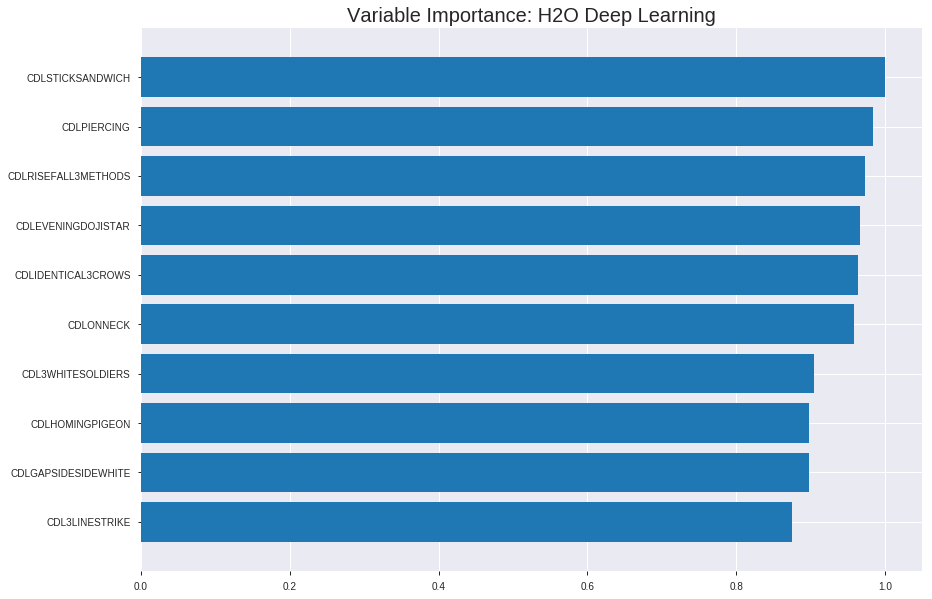

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_164450_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1987635800644985
RMSE: 0.4458290928870597
LogLoss: 0.5826351854403303
Mean Per-Class Error: 0.2900582021773762
AUC: 0.7936392390420601
pr_auc: 0.7843232486275771
Gini: 0.5872784780841203
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18498606388608585: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      433  376   0.4648   (376.0/809.0)
1      100  648   0.1337   (100.0/748.0)
Total  533  1024  0.3057   (476.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184986     0.731377  302
max f2                       0.0329287    0.844894  379
max f0point5                 0.745746     0.708183  103
max accuracy                 0.322825     0.707129  244
max precision                0.999326     1         0
max recall                   0.0075775    1         394
max specificity              0.999326     1         0
max absolute_mcc             0.216732     0.430437  288
max min_per_class_accuracy   0.348188     0.695921  234
max mean_per_class_accuracy  0.25304      0.709942  273

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 41.73 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.991079           2.08155    2.08155            1                0.995809   1                           0.995809            0.0213904       0.0213904                  108.155   108.155
    2        0.0205523                   0.984224           2.08155    2.08155            1                0.986422   1                           0.991116            0.0213904       0.0427807                  108.155   108.155
    3        0.0301863                   0.9784             2.08155    2.08155            1                0.982183   1                           0.988265            0.0200535       0.0628342                  108.155   108.155
    4        0.0404624                   0.971703           2.08155    2.08155            1                0.974353   1                           0.984732            0.0213904       0.0842246                  108.155   108.155
    5        0.0500963                   0.960754           2.08155    2.08155            1                0.966641   1                           0.981253            0.0200535       0.104278                   108.155   108.155
    6        0.100193                    0.917691           1.84137    1.96146            0.884615         0.939861   0.942308                    0.960557            0.092246        0.196524                   84.1372   96.1461
    7        0.150289                    0.851036           1.68125    1.86806            0.807692         0.881691   0.897436                    0.934268            0.0842246       0.280749                   68.1253   86.8058
    8        0.200385                    0.793079           1.57451    1.79467            0.75641          0.822064   0.862179                    0.906217            0.078877        0.359626                   57.4506   79.467
    9        0.299936                    0.645867           1.28922    1.62691            0.619355         0.724796   0.781585                    0.846002            0.128342        0.487968                   28.9219   62.6908
    10       0.400128                    0.481503           1.13418    1.50353            0.544872         0.563727   0.722311                    0.77532             0.113636        0.601604                   13.4178   50.3528
    11       0.500321                    0.337458           1.05412    1.41353            0.50641          0.400134   0.679076                    0.700187            0.105615        0.707219                   5.41187   41.3531
    12       0.599872                    0.233459           1.08778    1.35947            0.522581         0.284676   0.653105                    0.631232            0.108289        0.815508                   8.77782   35.9471
    13       0.700064                    0.153484           0.77391    1.27567            0.371795         0.190067   0.612844                    0.568092            0.0775401       0.893048                   -22.609   27.5666
    14       0.799615                    0.0867199          0.604321   1.19208            0.290323         0.121696   0.572691                    0.512517            0.0601604       0.953209                   -39.5679  19.2085
    15       0.899807                    0.0330013          0.373612   1.10095            0.179487         0.0609484  0.528908                    0.462235            0.0374332       0.990642                   -62.6388  10.0949
    16       1                           1.22949e-05        0.0934029  1                  0.0448718        0.014234   0.480411  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31338286330560206
RMSE: 0.5598060943805472
LogLoss: 0.894693456422438
Mean Per-Class Error: 0.4630192502532928
AUC: 0.5198277608915907
pr_auc: 0.49436588968085704
Gini: 0.039655521783181324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.012039258620459526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    232  0.9872   (232.0/235.0)
1      0    210  0        (0.0/210.0)
Total  3    442  0.5213   (232.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0120393    0.644172  396
max f2                       0.0120393    0.819033  396
max f0point5                 0.0230732    0.531536  393
max accuracy                 0.937041     0.54382   17
max precision                0.996613     1         0
max recall                   0.0120393    1         396
max specificity              0.996613     1         0
max absolute_mcc             0.977059     0.112767  4
max min_per_class_accuracy   0.422067     0.531915  203
max mean_per_class_accuracy  0.455232     0.536981  186

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 46.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.974612           2.11905   2.11905            1                0.985566   1                           0.985566            0.0238095       0.0238095                  111.905   111.905
    2        0.0202247                   0.957046           0.529762  1.4127             0.25             0.966246   0.666667                    0.976979            0.0047619       0.0285714                  -47.0238  41.2698
    3        0.0314607                   0.951604           0.847619  1.21088            0.4              0.953734   0.571429                    0.968678            0.00952381      0.0380952                  -15.2381  21.0884
    4        0.0404494                   0.937478           2.11905   1.4127             1                0.945253   0.666667                    0.963472            0.0190476       0.0571429                  111.905   41.2698
    5        0.0516854                   0.93126            0.42381   1.19772            0.2              0.934339   0.565217                    0.957139            0.0047619       0.0619048                  -57.619   19.7723
    6        0.101124                    0.872408           0.770563  0.988889           0.363636         0.899686   0.466667                    0.929051            0.0380952       0.1                        -22.9437  -1.11111
    7        0.150562                    0.82628            0.866883  0.948827           0.409091         0.846782   0.447761                    0.902037            0.0428571       0.142857                   -13.3117  -5.11727
    8        0.2                         0.751371           0.963203  0.952381           0.454545         0.788877   0.449438                    0.874065            0.047619        0.190476                   -3.67965  -4.7619
    9        0.301124                    0.602038           1.17725   1.0279             0.555556         0.684589   0.485075                    0.810435            0.119048        0.309524                   17.7249   2.78962
    10       0.4                         0.498016           0.866883  0.988095           0.409091         0.542428   0.466292                    0.744186            0.0857143       0.395238                   -13.3117  -1.19048
    11       0.501124                    0.420984           1.36561   1.06428            0.644444         0.4595     0.502242                    0.686738            0.138095        0.533333                   36.5608   6.4275
    12       0.6                         0.342962           0.963203  1.04762            0.454545         0.382584   0.494382                    0.636616            0.0952381       0.628571                   -3.67965  4.7619
    13       0.698876                    0.262225           0.866883  1.02205            0.409091         0.299324   0.482315                    0.588896            0.0857143       0.714286                   -13.3117  2.20487
    14       0.8                         0.195949           0.988889  1.01786            0.466667         0.227098   0.480337                    0.543163            0.1             0.814286                   -1.11111  1.78571
    15       0.898876                    0.137922           0.866883  1.00125            0.409091         0.166672   0.4725                      0.501749            0.0857143       0.9                        -13.3117  0.125
    16       1                           0.0040215          0.988889  1                  0.466667         0.0885261  0.47191                     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 16:51:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 16:52:02  7.561 sec         134 obs/sec       0.393064  1             612        0.672934         4.88616             -0.814144      0.516141        0.489368           1.04078          0.519589                         0.677106           8.68945               -0.839696        0.466424          0.459276             1.27143            0.52809
    2019-08-25 16:52:31  36.817 sec        141 obs/sec       2.83173   7             4409       0.626808         2.69664             -0.573971      0.546183        0.529901           1.30097          0.519589                         0.648184           5.61922               -0.685889        0.477599          0.461013             0.847619           0.52809
    2019-08-25 16:53:02  1 min  7.432 sec  150 obs/sec       5.70649   14            8885       0.667314         2.60716             -0.783973      0.565855        0.499748           1.56116          0.46885                          0.711965           3.72117               -1.03399         0.512513          0.517293             2.11905            0.525843
    2019-08-25 16:53:30  1 min 35.656 sec  156 obs/sec       8.51509   21            13258      0.586423         1.44355             -0.377683      0.598255        0.608526           1.95145          0.519589                         0.646498           2.53119               -0.67713         0.461064          0.468356             1.27143            0.52809
    2019-08-25 16:53:57  2 min  3.171 sec  162 obs/sec       11.3847   28            17726      0.51044          0.81775             -0.0437968     0.671123        0.640436           1.82136          0.416185                         0.616016           1.25071               -0.522707        0.456697          0.446019             1.27143            0.519101
    2019-08-25 16:54:27  2 min 32.470 sec  167 obs/sec       14.5819   36            22704      0.59822          1.45613             -0.433672      0.623935        0.54509            1.17087          0.436737                         0.676915           2.59881               -0.83866         0.520385          0.495479             1.27143            0.525843
    2019-08-25 16:54:56  3 min  1.495 sec  171 obs/sec       17.878    44            27836      0.488787         0.745369            0.0428782      0.701635        0.692354           1.95145          0.443802                         0.561597           0.973126              -0.265558        0.528085          0.508644             1.69524            0.52809
    2019-08-25 16:55:25  3 min 31.101 sec  174 obs/sec       21.1297   52            32899      0.510468         0.819154            -0.0439119     0.693494        0.64483            1.95145          0.385356                         0.620155           1.28635               -0.543241        0.474833          0.466614             1.27143            0.52809
    2019-08-25 16:55:53  3 m

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSTICKSANDWICH          1.0                    1.0                  0.0036362394588095727
CDLPIERCING               0.9844285845756531     0.9844285845756531   0.0035796180636140464
CDLRISEFALL3METHODS       0.9730862379074097     0.9730862379074097   0.0035383745751034826
CDLEVENINGDOJISTAR        0.9667693376541138     0.9667693376541138   0.003515404813145084
CDLIDENTICAL3CROWS        0.9637861251831055     0.9637861251831055   0.0035045571382439906
---                       ---                    ---                  ---
BBANDS_middleband_12_2_2  0.2251920849084854     0.2251920849084854   0.0008188523449558304
BBANDS_lowerband_30_7_2   0.22510521113872528    0.22510521113872528  0.000818536451126293
MAVP_12_5                 0.22492976486682892    0.22492976486682892  0.0008178984864695225
BBANDS_middleband_12_1_3  0.22381950914859772    0.22381950914859772  0.0008138613308175212
BBANDS_lowerband_24_3_5   0.22364942729473114    0.22364942729473114  0.0008132428724692641


See the whole table with table.as_data_frame()


('accuracy', 0.5650224215246636)

('F1', 0.668693009118541)

('auc', 0.5555019305019305)

('logloss', 1.3258120782844658)

('mean_per_class_error', 0.43440315315315314)

('rmse', 0.6268269953154069)

('mse', 0.39291208205614103)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


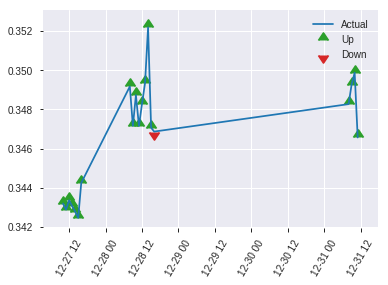


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.39291208205614103
RMSE: 0.6268269953154069
LogLoss: 1.3258120782844658
Mean Per-Class Error: 0.43440315315315314
AUC: 0.5555019305019305
pr_auc: 0.540667808755591
Gini: 0.11100386100386106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00865691684451312: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    108  0.9643   (108.0/112.0)
1      1    110  0.009    (1.0/111.0)
Total  5    218  0.4888   (109.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00865692   0.668693  217
max f2                       0.00744906   0.834586  220
max f0point5                 0.0436516    0.57377   139
max accuracy                 0.0436516    0.565022  139
max precision                0.696997     1         0
max recall                   0.00744906   1         220
max specificity              0.696997     1         0
max absolute_mcc             0.0436516    0.1357    139
max min_per_class_accuracy   0.073593     0.54955   108
max mean_per_class_accuracy  0.0436516    0.565597  139

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 12.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.479015           1.33934   1.33934            0.666667         0.582623   0.666667                    0.582623            0.018018        0.018018                   33.9339   33.9339
    2        0.0224215                   0.474377           2.00901   1.60721            1                0.476565   0.8                         0.5402              0.018018        0.036036                   100.901   60.7207
    3        0.0313901                   0.463085           2.00901   1.72201            1                0.471555   0.857143                    0.520587            0.018018        0.0540541                  100.901   72.2008
    4        0.0403587                   0.434194           0         1.33934            0                0.450035   0.666667                    0.504909            0               0.0540541                  -100      33.9339
    5        0.0538117                   0.40919            1.33934   1.33934            0.666667         0.423891   0.666667                    0.484654            0.018018        0.0720721                  33.9339   33.9339
    6        0.103139                    0.33971            0.547912  0.96083            0.272727         0.366614   0.478261                    0.4282              0.027027        0.0990991                  -45.2088  -3.91696
    7        0.152466                    0.283609           1.09582   1.0045             0.545455         0.303769   0.5                         0.387943            0.0540541       0.153153                   9.58231   0.45045
    8        0.201794                    0.24082            0.913186  0.982182           0.454545         0.260632   0.488889                    0.356823            0.045045        0.198198                   -8.68141  -1.78178
    9        0.300448                    0.168008           1.18714   1.04948            0.590909         0.197599   0.522388                    0.30454             0.117117        0.315315                   18.7142   4.94823
    10       0.399103                    0.110471           1.27846   1.10608            0.636364         0.139725   0.550562                    0.263799            0.126126        0.441441                   27.846    10.6084
    11       0.502242                    0.0725097          1.04818   1.09419            0.521739         0.0894928  0.544643                    0.228004            0.108108        0.54955                    4.81786   9.41924
    12       0.600897                    0.05047            1.09582   1.09446            0.545455         0.0616793  0.544776                    0.200697            0.108108        0.657658                   9.58231   9.44601
    13       0.699552                    0.0307121          1.0045    1.08177            0.5              0.0388493  0.538462                    0.177873            0.0990991       0.756757                   0.45045   8.17741
    14       0.798206                    0.0230313          0.821867  1.04965            0.409091         0.0259076  0.522472                    0.15909             0.0810811       0.837838                   -17.8133  4.96508
    15       0.896861                    0.0145565          0.821867  1.02459            0.409091         0.018723   0.51                        0.14365             0.0810811       0.918919                   -17.8133  2.45946
    16       1                           0.00683428         0.786134  1                  0.391304         0.0105955  0.497758                 

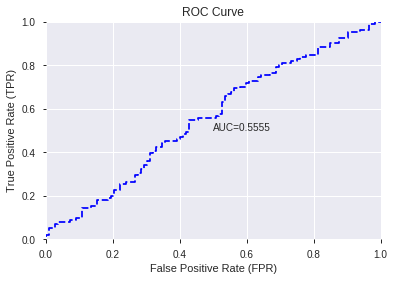

This function is available for GLM models only


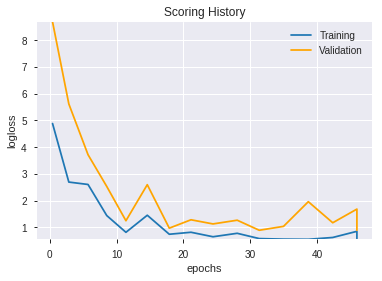

--2019-08-25 17:19:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.32.120
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.32.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_164450_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_164450_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_171910_model_6  0.516731  0.686444              0.500000  0.497558  0.247564
1  DeepLearning_grid_1_AutoML_20190825_171910_model_3  0.500322  0.795945              0.491071  0.525145  0.275778
2  DeepLearning_grid_1_AutoML_20190825_171910_model_7  0.498271  0.740287              0.500000  0.517741  0.268056
3  DeepLearning_grid_1_AutoML_20190825_171910_model_2  0.493887  0.779351              0.486607  0.530242  0.281157
4               DeepLearning_1_AutoML_20190825_171910  0.491071  0.735383              0.495536  0.514589  0.264802
5  DeepLearning_grid_1_AutoML_20190825_171910_model_5  0.483832  0.728321              0.500000  0.515830  0.266080
6  DeepLearning_grid_1_AutoML_20190825_171910_model_4  0.466297  0.841616              0.482223  0.551647  0.304315
7  DeepLearning_grid_1_AutoML_20190825_171910_model_8  0.465975  0.690447              0.482183  0.498687  0.248689
8  DeepLearning_grid_1_AutoML_20190825_171910_model_9  0.455518  0.695032              0.500000  0.500939  0.250940
9  DeepLearning_grid_1_AutoML_20190825_171910_model_1  0.441441  1.120952              0.500000  0.573858  0.329313

variable  relative_importance  scaled_importance  percentage
0        STOCHRSI_fastk             1.000000           1.000000    0.026387
1                  hour             0.945915           0.945915    0.024960
2        STOCHRSI_fastd             0.939819           0.939819    0.024799
3          HT_TRENDMODE             0.935774           0.935774    0.024692
4             CORREL_12             0.909939           0.909939    0.024011
5              CORREL_8             0.870626           0.870626    0.022973
6             CORREL_14             0.865656           0.865656    0.022842
7                   SUB             0.839488           0.839488    0.022152
8                   BOP             0.826410           0.826410    0.021807
9                   day             0.823720           0.823720    0.021736
10       is_month_start             0.805837           0.805837    0.021264
11                  DIV             0.779024           0.779024    0.020556
12       CDLEVENINGSTAR             0.771929           0.771929    0.020369
13    CDLLONGLEGGEDDOJI             0.770117           0.770117    0.020321
14      CDLADVANCEBLOCK             0.767679           0.767679    0.020257
15  CDLGAPSIDESIDEWHITE             0.761550           0.761550    0.020095
16       CDLMORNINGSTAR             0.760845           0.760845    0.020077
17       CDLRICKSHAWMAN             0.760800           0.760800    0.020075
18            CORREL_20             0.757218           0.757218    0.019981
19   CDLIDENTICAL3CROWS             0.756594           0.756594    0.019964
20    CDLINVERTEDHAMMER             0.755061           0.755061    0.019924
21            CDLTAKURI             0.753774           0.753774    0.019890
22    CDLDARKCLOUDCOVER             0.753254           0.753254    0.019876
23               TRANGE             0.749674           0.749674    0.019782
24      CDLSHOOTINGSTAR             0.749536           0.749536    0.019778
25       CDLSPINNINGTOP             0.743995           0.743995    0.019632
26    CDLGRAVESTONEDOJI             0.733329           0.733329    0.019351
27   CDLEVENINGDOJISTAR             0.730824           0.730824    0.019284
28        CDLHANGINGMAN             0.728353           0.728353    0.019219
29          CDLPIERCING             0.726114           0.726114    0.019160
30            CDLONNECK             0.726057           0.726057    0.019159
31         is_month_end             0.726049           0.726049    0.019158
32    CDLSTALLEDPATTERN             0.717984           0.717984    0.018946
33         CDLTHRUSTING             0.717729           0.717729    0.018939
34        CDLHIKKAKEMOD             0.716350           0.716350    0.018902
35  CDLRISEFALL3METHODS             0.713644           0.713644    0.018831
36   CDLMORNINGDOJISTAR             0.713064           0.713064    0.018816
37      CDLHOMINGPIGEON             0.711194           0.711194    0.018766
38    CDL3WHITESOLDIERS             0.708237           0.708237    0.018688
39              CDLDOJI             0.704314           0.704314    0.018585
40     CDLSTICKSANDWICH             0.697105           0.697105    0.018395
41            CDLHAMMER             0.690173           0.690173    0.018212
42       CDL3LINESTRIKE             0.682534           0.682534    0.018010
43           CDL3INSIDE             0.677708           0.677708    0.017883
44     CDLDRAGONFLYDOJI             0.668578           0.668578    0.017642
45       CDLMATCHINGLOW             0.664451           0.664451    0.017533
46          CDLDOJISTAR             0.658238           0.658238    0.017369
47       CDLHARAMICROSS             0.650654           0.650654    0.017169
48   CDLSEPARATINGLINES             0.640221           0.640221    0.016894
49  CDLXSIDEGAP3METHODS             0.639976           0.639976    0.016887

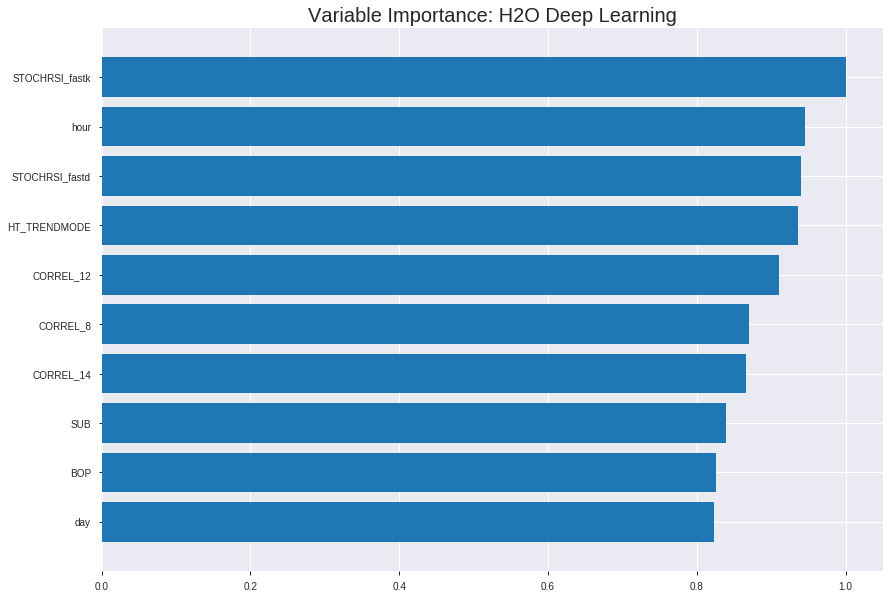

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_171910_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2360912780034645
RMSE: 0.48589224937578956
LogLoss: 0.6638261672591037
Mean Per-Class Error: 0.41350151702438476
AUC: 0.6255973903214506
pr_auc: 0.6196989198499299
Gini: 0.2511947806429011
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40184623741532743: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      71   738   0.9122   (738.0/809.0)
1      14   734   0.0187   (14.0/748.0)
Total  85   1472  0.483    (752.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401846     0.661261  334
max f2                       0.32411      0.827418  362
max f0point5                 0.484386     0.569887  223
max accuracy                 0.524905     0.593449  155
max precision                0.950711     1         0
max recall                   0.249748     1         380
max specificity              0.950711     1         0
max absolute_mcc             0.564671     0.20346   102
max min_per_class_accuracy   0.493351     0.57754   208
max mean_per_class_accuracy  0.518868     0.586498  164

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 49.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102762                   0.759005           1.82136   1.82136            0.875            0.871459  0.875                       0.871459            0.0187166       0.0187166                  82.1357    82.1357
    2        0.0205523                   0.680905           1.95145   1.88641            0.9375           0.702028  0.90625                     0.786743            0.0200535       0.0387701                  95.1454    88.6405
    3        0.0301863                   0.648978           1.80401   1.86011            0.866667         0.664358  0.893617                    0.747684            0.0173797       0.0561497                  80.4011    86.0109
    4        0.0404624                   0.627631           1.56116   1.78419            0.75             0.636829  0.857143                    0.719531            0.0160428       0.0721925                  56.1163    78.4186
    5        0.0500963                   0.618848           1.52647   1.73463            0.733333         0.62236   0.833333                    0.700844            0.0147059       0.0868984                  52.6471    73.4626
    6        0.100193                    0.579861           1.44107   1.58785            0.692308         0.595505  0.762821                    0.648174            0.0721925       0.159091                   44.1074    58.785
    7        0.150289                    0.558845           1.28095   1.48555            0.615385         0.568374  0.713675                    0.621574            0.0641711       0.223262                   28.0954    48.5551
    8        0.200385                    0.542484           1.20089   1.41439            0.576923         0.550994  0.679487                    0.603929            0.0601604       0.283422                   20.0895    41.4387
    9        0.299936                    0.522619           1.03406   1.28815            0.496774         0.532121  0.618844                    0.580096            0.102941        0.386364                   3.40607    28.8155
    10       0.400128                    0.505018           0.987402  1.21285            0.474359         0.513342  0.582665                    0.563381            0.0989305       0.485294                   -1.25977   21.2846
    11       0.500321                    0.492548           0.960716  1.16236            0.461538         0.498176  0.558408                    0.550323            0.0962567       0.581551                   -3.92842   16.2355
    12       0.599872                    0.480085           0.980343  1.13215            0.470968         0.486005  0.543897                    0.539649            0.0975936       0.679144                   -1.96567   13.215
    13       0.700064                    0.470117           0.840626  1.09043            0.403846         0.474867  0.523853                    0.530378            0.0842246       0.763369                   -15.9374   9.04271
    14       0.799615                    0.458798           0.993773  1.07839            0.477419         0.464791  0.518072                    0.522212            0.0989305       0.862299                   -0.622736  7.83938
    15       0.899807                    0.436096           0.827283  1.05043            0.397436         0.448789  0.50464                     0.514037            0.0828877       0.945187                   -17.2717   5.04328
    16       1                           0.0502077          0.547074  1                  0.262821         0.354588  0.480411                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25330806689754265
RMSE: 0.5032971954000366
LogLoss: 0.7011427117501623
Mean Per-Class Error: 0.4686423505572441
AUC: 0.4945390070921986
pr_auc: 0.488883472491955
Gini: -0.010921985815602775
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13903391129075238: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    233  0.9915   (233.0/235.0)
1      0    210  0        (0.0/210.0)
Total  2    443  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.139034     0.643185  397
max f2                       0.139034     0.818394  397
max f0point5                 0.139034     0.529768  397
max accuracy                 0.583559     0.555056  33
max precision                0.940435     1         0
max recall                   0.139034     1         397
max specificity              0.940435     1         0
max absolute_mcc             0.583559     0.117857  33
max min_per_class_accuracy   0.475709     0.489362  212
max mean_per_class_accuracy  0.583559     0.531358  33

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.885431           1.69524   1.69524            0.8              0.906641  0.8                         0.906641            0.0190476       0.0190476                  69.5238   69.5238
    2        0.0202247                   0.826969           1.58929   1.64815            0.75             0.868548  0.777778                    0.889711            0.0142857       0.0333333                  58.9286   64.8148
    3        0.0314607                   0.63644            1.27143   1.51361            0.6              0.72756   0.714286                    0.8318              0.0142857       0.047619                   27.1429   51.3605
    4        0.0404494                   0.618097           0.529762  1.29497            0.25             0.625109  0.611111                    0.785868            0.0047619       0.052381                   -47.0238  29.4974
    5        0.0516854                   0.602017           1.27143   1.28986            0.6              0.610323  0.608696                    0.747706            0.0142857       0.0666667                  27.1429   28.9855
    6        0.101124                    0.569159           0.963203  1.13016            0.454545         0.583437  0.533333                    0.667397            0.047619        0.114286                   -3.67965  13.0159
    7        0.150562                    0.542109           0.770563  1.01208            0.363636         0.551706  0.477612                    0.629409            0.0380952       0.152381                   -22.9437  1.20824
    8        0.2                         0.522028           0.770563  0.952381           0.363636         0.532127  0.449438                    0.605362            0.0380952       0.190476                   -22.9437  -4.7619
    9        0.301124                    0.502735           0.941799  0.948827           0.444444         0.511544  0.447761                    0.573856            0.0952381       0.285714                   -5.82011  -5.11727
    10       0.4                         0.487223           0.866883  0.928571           0.409091         0.495659  0.438202                    0.554526            0.0857143       0.371429                   -13.3117  -7.14286
    11       0.501124                    0.475709           1.17725   0.978753           0.555556         0.480717  0.461883                    0.539632            0.119048        0.490476                   17.7249   -2.12471
    12       0.6                         0.465297           0.915043  0.968254           0.431818         0.469376  0.456929                    0.528054            0.0904762       0.580952                   -8.49567  -3.1746
    13       0.698876                    0.455978           1.30032   1.01524            0.613636         0.460303  0.4791                      0.518469            0.128571        0.709524                   30.0325   1.5235
    14       0.8                         0.44655            0.941799  1.00595            0.444444         0.451603  0.474719                    0.510017            0.0952381       0.804762                   -5.82011  0.595238
    15       0.898876                    0.436598           1.05952   1.01185            0.5              0.441319  0.4775                      0.50246             0.104762        0.909524                   5.95238   1.18452
    16       1                           0.107295           0.894709  1                  0.422222         0.37862   0.47191                     0.489937      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:23:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:23:22  2 min 12.528 sec  828 obs/sec       1.23121   1             1917       0.568821         0.999376            -0.296219      0.539329        0.521462           1.17087          0.513166                         0.598243           1.11358               -0.436113        0.508207          0.464637             0                  0.51236
    2019-08-25 17:23:30  2 min 20.727 sec  1805 obs/sec      11.3391   9             17655      0.494557         0.681831            0.0201483      0.601586        0.581882           1.30097          0.499679                         0.504757           0.7045                -0.0223462       0.502938          0.489773             1.69524            0.52809
    2019-08-25 17:23:38  2 min 28.794 sec  2164 obs/sec      23.8003   19            37057      0.485892         0.663826            0.0541831      0.625597        0.619699           1.82136          0.48298                          0.503297           0.701143              -0.0164403       0.494539          0.488883             1.69524            0.523596
    2019-08-25 17:23:46  2 min 36.633 sec  2333 obs/sec      36.3751   29            56636      0.48147          0.653038            0.0713216      0.649576        0.64158            1.95145          0.470777                         0.504554           0.707706              -0.0215249       0.529149          0.51444              1.69524            0.523596
    2019-08-25 17:23:53  2 min 43.671 sec  2425 obs/sec      47.6583   38            74204      0.474593         0.638358            0.0976612      0.678905        0.671209           1.95145          0.445087                         0.504856           0.712271              -0.0227477       0.521439          0.500648             1.69524            0.523596
    2019-08-25 17:24:00  2 min 51.219 sec  2502 obs/sec      60.1721   48            93688      0.469451         0.626535            0.117107       0.692342        0.691709           2.08155          0.44316                          0.506501           0.720378              -0.0294241       0.530294          0.494622             1.69524            0.523596
    2019-08-25 17:24:08  2 min 58.671 sec  2560 obs/sec      72.6326   58            113089     0.465419         0.616802            0.132208       0.705605        0.705191           2.08155          0.417469                         0.510487           0.734221              -0.0456897       0.531175          0.496138             1.69524            0.525843
    2019-08-25 17:24:09  2 min 59.398 sec  2559 obs/sec      72.6326   58            113089     0.485892         0.663826            0.0541831      0.625597        0.619699           1.82136          0.48298                          0.503297           0.701143              -0.0164403       0.494539          0.488883             1.69524            0.523596

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
STOCHRSI_fastk       1.0                    1.0                  0.026387233368771648
hour                 0.9459150433540344     0.9459150433540344   0.02496008099601466
STOCHRSI_fastd       0.9398186206817627     0.9398186206817627   0.02479921326824675
HT_TRENDMODE         0.9357743859291077     0.9357743859291077   0.024692497102030347
CORREL_12            0.9099392890930176     0.9099392890930176   0.024010780372711624
---                  ---                    ---                  ---
CDLMATCHINGLOW       0.664451003074646      0.664451003074646    0.01753302368024509
CDLDOJISTAR          0.6582379937171936     0.6582379937171936   0.017369079552407633
CDLHARAMICROSS       0.6506536602973938     0.6506536602973938   0.0171689499765128
CDLSEPARATINGLINES   0.640220582485199      0.640220582485199    0.016893649917527863
CDLXSIDEGAP3METHODS  0.6399756669998169     0.6399756669998169   0.016887187275459462


See the whole table with table.as_data_frame()


('accuracy', 0.547085201793722)

('F1', 0.6646706586826348)

('auc', 0.5167310167310167)

('logloss', 0.6864437203133166)

('mean_per_class_error', 0.45423101673101673)

('rmse', 0.4975582859488376)

('mse', 0.24756424791634526)

deeplearning prediction progress: |███████████████████████████████████████| 100%


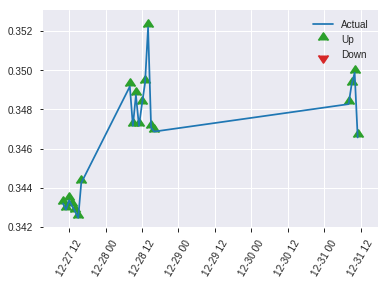


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24756424791634526
RMSE: 0.4975582859488376
LogLoss: 0.6864437203133166
Mean Per-Class Error: 0.45423101673101673
AUC: 0.5167310167310167
pr_auc: 0.5532800707022477
Gini: 0.03346203346203347
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28375208876785957: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    111  0        (0.0/111.0)
Total  0    223  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.283752     0.664671  222
max f2                       0.283752     0.832084  222
max f0point5                 0.283752     0.55334   222
max accuracy                 0.5129       0.547085  41
max precision                0.926752     1         0
max recall                   0.283752     1         222
max specificity              0.926752     1         0
max absolute_mcc             0.856244     0.152126  4
max min_per_class_accuracy   0.471208     0.508929  111
max mean_per_class_accuracy  0.511298     0.545769  45

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.899791           2.00901   2.00901            1                0.915579  1                           0.915579            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.798785           2.00901   2.00901            1                0.861241  1                           0.893844            0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.68483            1.0045    1.72201            0.5              0.705687  0.857143                    0.840085            0.00900901      0.0540541                  0.45045   72.2008
    4        0.0403587                   0.64677            1.0045    1.56256            0.5              0.673812  0.777778                    0.803135            0.00900901      0.0630631                  0.45045   56.2563
    5        0.0538117                   0.61611            1.33934   1.50676            0.666667         0.63314   0.75                        0.760637            0.018018        0.0810811                  33.9339   50.6757
    6        0.103139                    0.561872           1.27846   1.39757            0.636364         0.579297  0.695652                    0.673909            0.0630631       0.144144                   27.846    39.7571
    7        0.152466                    0.521893           0.730549  1.18177            0.363636         0.531403  0.588235                    0.627804            0.036036        0.18018                    -26.9451  18.177
    8        0.201794                    0.512011           1.27846   1.20541            0.636364         0.514652  0.6                         0.600145            0.0630631       0.243243                   27.846    20.5405
    9        0.300448                    0.489996           0.821867  1.07947            0.409091         0.500354  0.537313                    0.567378            0.0810811       0.324324                   -17.8133  7.94675
    10       0.399103                    0.478849           0.63923   0.970645           0.318182         0.484391  0.483146                    0.546864            0.0630631       0.387387                   -36.077   -2.93552
    11       0.502242                    0.471208           1.22288   1.02244            0.608696         0.474795  0.508929                    0.532064            0.126126        0.513514                   22.2875   2.24421
    12       0.600897                    0.462314           0.821867  0.989512           0.409091         0.466928  0.492537                    0.52137             0.0810811       0.594595                   -17.8133  -1.04881
    13       0.699552                    0.455615           1.0045    0.991626           0.5              0.458787  0.49359                     0.512544            0.0990991       0.693694                   0.45045   -0.837376
    14       0.798206                    0.449526           0.913186  0.981931           0.454545         0.452714  0.488764                    0.50515             0.0900901       0.783784                   -8.68141  -1.80686
    15       0.896861                    0.43655            1.18714   1.0045             0.590909         0.442906  0.5                         0.498303            0.117117        0.900901                   18.7142   0.45045
    16       1                           0.283752           0.96083   1                  0.478261         0.402194  0.497758                    0.48839      

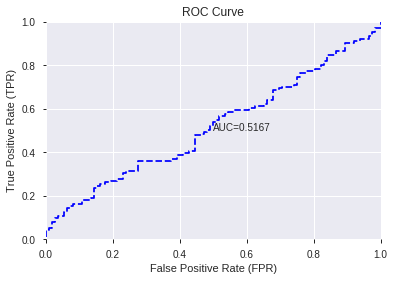

This function is available for GLM models only


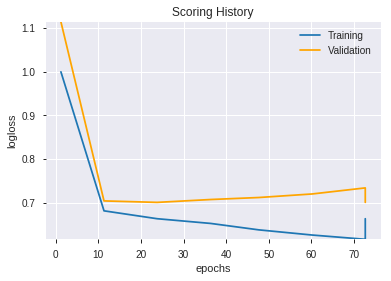

--2019-08-25 17:28:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_171910_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_171910_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastk',
 'hour',
 'STOCHRSI_fastd',
 'HT_TRENDMODE',
 'CORREL_12',
 'CORREL_8',
 'CORREL_14',
 'SUB',
 'BOP',
 'day',
 'is_month_start',
 'DIV',
 'CDLEVENINGSTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLRICKSHAWMAN',
 'CORREL_20',
 'CDLIDENTICAL3CROWS',
 'CDLINVERTEDHAMMER',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'CDLSPINNINGTOP',
 'CDLGRAVESTONEDOJI',
 'CDLEVENINGDOJISTAR',
 'CDLHANGINGMAN',
 'CDLPIERCING',
 'CDLONNECK',
 'is_month_end',
 'CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDLRISEFALL3METHODS',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLDOJI',
 'CDLSTICKSANDWICH',
 'CDLHAMMER',
 'CDL3LINESTRIKE',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'CDLMATCHINGLOW',
 'CDLDOJISTAR',
 'CDLHARAMICROSS',
 'CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_172836_model_1  0.515364  0.690246              0.495536  0.498563  0.248565

variable  relative_importance  scaled_importance  percentage
0   CDLGAPSIDESIDEWHITE             0.032825           1.000000    0.044283
1    CDLSEPARATINGLINES             0.032169           0.980028    0.043399
2        CDL3LINESTRIKE             0.030526           0.929982    0.041182
3       CDLADVANCEBLOCK             0.028554           0.869894    0.038522
4       CDLSHOOTINGSTAR             0.026985           0.822093    0.036405
5        STOCHRSI_fastd             0.026819           0.817041    0.036181
6                   SUB             0.025329           0.771657    0.034171
7              CORREL_8             0.023580           0.718370    0.031812
8          HT_TRENDMODE             0.023468           0.714959    0.031661
9         CDLHIKKAKEMOD             0.021692           0.660841    0.029264
10    CDLINVERTEDHAMMER             0.021174           0.645066    0.028565
11       CDLRICKSHAWMAN             0.020577           0.626867    0.027760
12                  BOP             0.020347           0.619864    0.027450
13     CDLSTICKSANDWICH             0.020267           0.617423    0.027341
14    CDLSTALLEDPATTERN             0.020007           0.609499    0.026990
15                  DIV             0.019920           0.606852    0.026873
16       CDLSPINNINGTOP             0.019624           0.597851    0.026475
17  CDLRISEFALL3METHODS             0.019164           0.583818    0.025853
18   CDLIDENTICAL3CROWS             0.019139           0.583062    0.025820
19   CDLEVENINGDOJISTAR             0.018881           0.575216    0.025472
20            CDLONNECK             0.018678           0.569025    0.025198
21          CDLDOJISTAR             0.018523           0.564294    0.024989
22       is_month_start             0.018013           0.548761    0.024301
23          CDLPIERCING             0.017684           0.538727    0.023857
24            CDLTAKURI             0.017507           0.533358    0.023619
25       CDLHARAMICROSS             0.017258           0.525754    0.023282
26            CDLHAMMER             0.015897           0.484291    0.021446
27               TRANGE             0.015507           0.472410    0.020920
28            CORREL_14             0.015112           0.460380    0.020387
29       CDLMORNINGSTAR             0.014425           0.439448    0.019460
30     CDLDRAGONFLYDOJI             0.011902           0.362585    0.016056
31         CDLTHRUSTING             0.010548           0.321338    0.014230
32    CDLGRAVESTONEDOJI             0.008175           0.249039    0.011028
33           CDL3INSIDE             0.007431           0.226378    0.010025
34            CORREL_12             0.007204           0.219459    0.009718
35                  day             0.006453           0.196589    0.008706
36       CDLMATCHINGLOW             0.006104           0.185972    0.008235
37              CDLDOJI             0.005758           0.175408    0.007768
38    CDLLONGLEGGEDDOJI             0.005750           0.175164    0.007757
39       CDLEVENINGSTAR             0.005578           0.169946    0.007526
40       STOCHRSI_fastk             0.004993           0.152115    0.006736
41                 hour             0.004782           0.145698    0.006452
42   CDLMORNINGDOJISTAR             0.003806           0.115936    0.005134
43      CDLHOMINGPIGEON             0.003344           0.101874    0.004511
44         is_month_end             0.003212           0.097848    0.004333
45        CDLHANGINGMAN             0.002261           0.068894    0.003051
46    CDLDARKCLOUDCOVER             0.001767           0.053821    0.002383
47    CDL3WHITESOLDIERS             0.001320           0.040207    0.001780
48  CDLXSIDEGAP3METHODS             0.000858           0.026128    0.001157
49            CORREL_20             0.000353           0.010759    0.000476

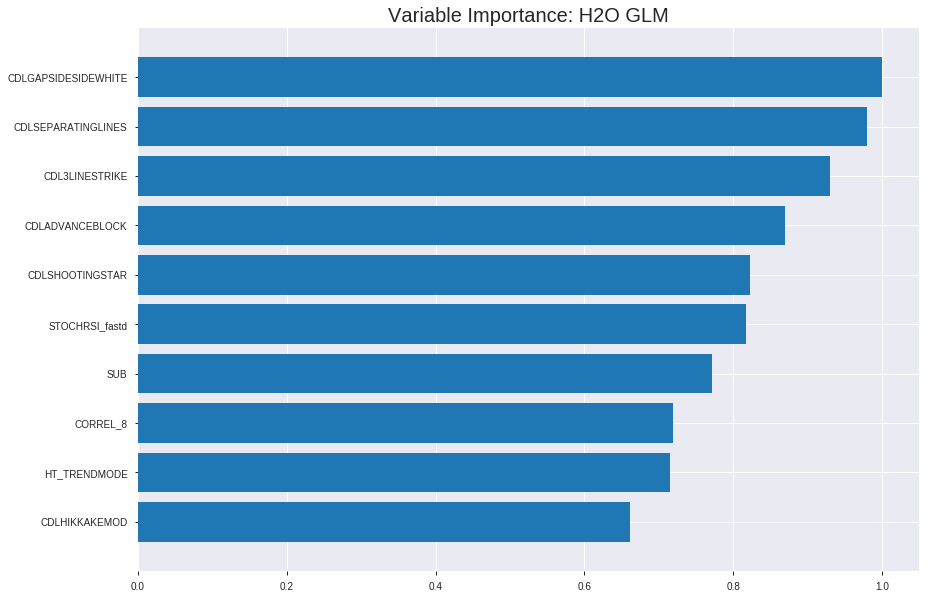

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_172836_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24539028272554117
RMSE: 0.49536883503662316
LogLoss: 0.6837516615563505
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2156.0698562406105
Residual deviance: 2129.2026740864753
AIC: 2231.2026740864753
AUC: 0.5832793506210215
pr_auc: 0.5732612744240942
Gini: 0.16655870124204308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42081951935910283: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   762   0.9419   (762.0/809.0)
1      15   733   0.0201   (15.0/748.0)
Total  62   1495  0.499    (777.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42082      0.653589  356
max f2                       0.352358     0.824152  390
max f0point5                 0.484329     0.559066  181
max accuracy                 0.489981     0.583815  155
max precision                0.6775       1         0
max recall                   0.352358     1         390
max specificity              0.6775       1         0
max absolute_mcc             0.489981     0.16348   155
max min_per_class_accuracy   0.483132     0.557487  187
max mean_per_class_accuracy  0.488519     0.579143  163

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.583561           1.82136   1.82136            0.875            0.619556  0.875                       0.619556            0.0187166       0.0187166                  82.1357   82.1357
    2        0.0205523                   0.549399           1.69126   1.75631            0.8125           0.568774  0.84375                     0.594165            0.0173797       0.0360963                  69.126    75.6308
    3        0.0301863                   0.529752           1.3877    1.63867            0.666667         0.538518  0.787234                    0.576405            0.013369        0.0494652                  38.7701   63.8668
    4        0.0404624                   0.523164           1.56116   1.61898            0.75             0.525937  0.777778                    0.563588            0.0160428       0.065508                   56.1163   61.8984
    5        0.0500963                   0.518149           0.69385   1.44107            0.333333         0.520832  0.692308                    0.555366            0.00668449      0.0721925                  -30.615   44.1074
    6        0.100193                    0.506292           1.20089   1.32098            0.576923         0.511411  0.634615                    0.533388            0.0601604       0.132353                   20.0895   32.0984
    7        0.150289                    0.501046           1.20089   1.28095            0.576923         0.503362  0.615385                    0.52338             0.0601604       0.192513                   20.0895   28.0954
    8        0.200385                    0.497516           1.06746   1.22758            0.512821         0.499451  0.589744                    0.517398            0.0534759       0.245989                   6.74619   22.7581
    9        0.299936                    0.491899           1.22207   1.22575            0.587097         0.494451  0.588865                    0.509782            0.121658        0.367647                   22.2072   22.5753
    10       0.400128                    0.487384           1.06746   1.18612            0.512821         0.489756  0.569823                    0.504767            0.106952        0.474599                   6.74619   18.6116
    11       0.500321                    0.48289            0.85397   1.1196             0.410256         0.484952  0.537869                    0.500799            0.0855615       0.56016                    -14.603   11.9602
    12       0.599872                    0.477899           0.872908  1.07866            0.419355         0.480519  0.518201                    0.497434            0.0868984       0.647059                   -12.7092  7.86623
    13       0.700064                    0.471933           0.893999  1.05223            0.429487         0.47497   0.505505                    0.494219            0.0895722       0.736631                   -10.6001  5.22335
    14       0.799615                    0.464655           0.84605   1.02656            0.406452         0.468555  0.493173                    0.491024            0.0842246       0.820856                   -15.395   2.6564
    15       0.899807                    0.448552           0.960716  1.01923            0.461538         0.457976  0.48965                     0.487344            0.0962567       0.917112                   -3.92842  1.92319
    16       1                           0.194846           0.827283  1                  0.397436         0.418151  0.480411                    0.480411          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2485875919249641
RMSE: 0.4985855913732005
LogLoss: 0.6902841387136561
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 615.6246511654862
Residual deviance: 614.3528834551539
AIC: 716.3528834551539
AUC: 0.5078824721377913
pr_auc: 0.503358380793146
Gini: 0.015764944275582504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3979661498158949: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    228  0.9702   (228.0/235.0)
1      1    209  0.0048   (1.0/210.0)
Total  8    437  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397966     0.646059  391
max f2                       0.397966     0.818324  391
max f0point5                 0.397966     0.533708  391
max accuracy                 0.519876     0.552809  21
max precision                0.670309     1         0
max recall                   0.312139     1         398
max specificity              0.670309     1         0
max absolute_mcc             0.519876     0.124967  21
max min_per_class_accuracy   0.47477      0.514894  194
max mean_per_class_accuracy  0.519876     0.52771   21

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 47.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.577274           1.69524   1.69524            0.8              0.599033  0.8                         0.599033            0.0190476       0.0190476                  69.5238   69.5238
    2        0.0202247                   0.553051           1.58929   1.64815            0.75             0.567517  0.777778                    0.585026            0.0142857       0.0333333                  58.9286   64.8148
    3        0.0314607                   0.524088           1.27143   1.51361            0.6              0.531033  0.714286                    0.565743            0.0142857       0.047619                   27.1429   51.3605
    4        0.0404494                   0.520829           1.58929   1.53042            0.75             0.522838  0.722222                    0.556208            0.0142857       0.0619048                  58.9286   53.0423
    5        0.0516854                   0.519586           1.69524   1.56625            0.8              0.520545  0.73913                     0.548456            0.0190476       0.0809524                  69.5238   56.6253
    6        0.101124                    0.503385           0.674242  1.13016            0.318182         0.508956  0.533333                    0.529145            0.0333333       0.114286                   -32.5758  13.0159
    7        0.150562                    0.496948           0.770563  1.01208            0.363636         0.500122  0.477612                    0.519615            0.0380952       0.152381                   -22.9437  1.20824
    8        0.2                         0.492547           0.866883  0.97619            0.409091         0.494471  0.460674                    0.5134              0.0428571       0.195238                   -13.3117  -2.38095
    9        0.301124                    0.484683           1.27143   1.07534            0.6              0.488366  0.507463                    0.504993            0.128571        0.32381                    27.1429   7.53376
    10       0.4                         0.480412           0.915043  1.03571            0.431818         0.482542  0.488764                    0.499443            0.0904762       0.414286                   -8.49567  3.57143
    11       0.501124                    0.47477            1.03598   1.03577            0.488889         0.477824  0.488789                    0.495081            0.104762        0.519048                   3.59788   3.57677
    12       0.6                         0.468525           0.626082  0.968254           0.295455         0.471948  0.456929                    0.491269            0.0619048       0.580952                   -37.3918  -3.1746
    13       0.698876                    0.461941           0.915043  0.960726           0.431818         0.465794  0.453376                    0.487664            0.0904762       0.671429                   -8.49567  -3.92742
    14       0.8                         0.451078           1.22434   0.994048           0.577778         0.456727  0.469101                    0.483754            0.12381         0.795238                   22.4339   -0.595238
    15       0.898876                    0.434812           1.01136   0.995952           0.477273         0.444155  0.47                        0.479398            0.1             0.895238                   1.13636   -0.404762
    16       1                           0.285718           1.03598   1                  0.488889         0.41212   0.47191                     0.472595   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:28:36  0.000 sec   2            2.9       51            1.37991           1.38207
    2019-08-25 17:28:36  0.009 sec   4            1.8       51            1.37768           1.38158
    2019-08-25 17:28:36  0.020 sec   6            1.1       51            1.37479           1.38109
    2019-08-25 17:28:36  0.029 sec   8            0.69      51            1.37133           1.3807
    2019-08-25 17:28:36  0.039 sec   10           0.43      51            1.3675            1.38057
    2019-08-25 17:28:36  0.045 sec   12           0.27      51            1.36367           1.38088
    2019-08-25 17:28:36  0.050 sec   14           0.16      51            1.3602            1.38175
    2019-08-25 17:28:36  0.056 sec   16           0.1       51            1.35735           1.38316
    2019-08-25 17:28:36  0.062 sec   18           0.064     51            1.35519           1.38498
    2019-08-25 17:28:36  0.067 sec   20           0.039     51            1.35362           1.38701

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6666666666666666)

('auc', 0.5153635778635779)

('logloss', 0.690246321367941)

('mean_per_class_error', 0.4588561776061776)

('rmse', 0.49856262430930914)

('mse', 0.24856469035818532)

glm prediction progress: |████████████████████████████████████████████████| 100%


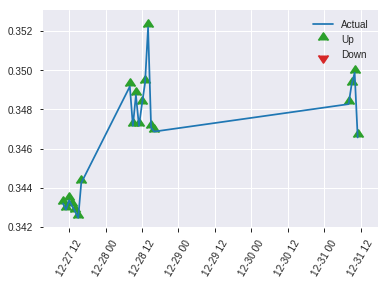


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24856469035818532
RMSE: 0.49856262430930914
LogLoss: 0.690246321367941
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.40779410652675
Residual deviance: 307.8498593301017
AIC: 409.8498593301017
AUC: 0.5153635778635779
pr_auc: 0.5475949867890444
Gini: 0.030727155727155786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4023056591185263: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    111  0        (0.0/111.0)
Total  1    222  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402306     0.666667  221
max f2                       0.402306     0.833333  221
max f0point5                 0.433329     0.556691  216
max accuracy                 0.498599     0.542601  34
max precision                0.610512     1         0
max recall                   0.402306     1         221
max specificity              0.610512     1         0
max absolute_mcc             0.554101     0.152126  4
max min_per_class_accuracy   0.477941     0.504505  110
max mean_per_class_accuracy  0.49675      0.541144  38

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 47.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.578951           2.00901   2.00901            1                0.592302  1                           0.592302            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.549898           2.00901   2.00901            1                0.562522  1                           0.58039             0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.543181           1.0045    1.72201            0.5              0.5442    0.857143                    0.57005             0.00900901      0.0540541                  0.45045   72.2008
    4        0.0403587                   0.537711           1.0045    1.56256            0.5              0.541309  0.777778                    0.563663            0.00900901      0.0630631                  0.45045   56.2563
    5        0.0538117                   0.531597           1.33934   1.50676            0.666667         0.534929  0.75                        0.55648             0.018018        0.0810811                  33.9339   50.6757
    6        0.103139                    0.510888           1.09582   1.31022            0.545455         0.51913   0.652174                    0.538617            0.0540541       0.135135                   9.58231   31.0223
    7        0.152466                    0.498652           1.09582   1.24086            0.545455         0.502356  0.617647                    0.526885            0.0540541       0.189189                   9.58231   24.0859
    8        0.201794                    0.49396            0.913186  1.16076            0.454545         0.496261  0.577778                    0.519399            0.045045        0.234234                   -8.68141  16.0761
    9        0.300448                    0.486046           0.730549  1.0195             0.363636         0.489324  0.507463                    0.509524            0.0720721       0.306306                   -26.9451  1.94971
    10       0.399103                    0.481994           0.821867  0.970645           0.409091         0.48399   0.483146                    0.503212            0.0810811       0.387387                   -17.8133  -2.93552
    11       0.502242                    0.477915           1.13553   1.0045             0.565217         0.479932  0.5                         0.498431            0.117117        0.504505                   13.5527   0.45045
    12       0.600897                    0.472319           1.27846   1.04948            0.636364         0.475202  0.522388                    0.494618            0.126126        0.630631                   27.846    4.94823
    13       0.699552                    0.466789           0.63923   0.991626           0.318182         0.469304  0.49359                     0.491048            0.0630631       0.693694                   -36.077   -0.837376
    14       0.798206                    0.458317           0.821867  0.970645           0.409091         0.463775  0.483146                    0.487677            0.0810811       0.774775                   -17.8133  -2.93552
    15       0.896861                    0.44782            1.27846   1.0045             0.636364         0.454054  0.5                         0.483978            0.126126        0.900901                   27.846    0.45045
    16       1                           0.377455           0.96083   1                  0.478261         0.431855  0.497758                    0.478602     

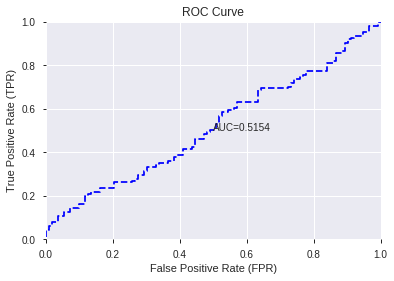

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


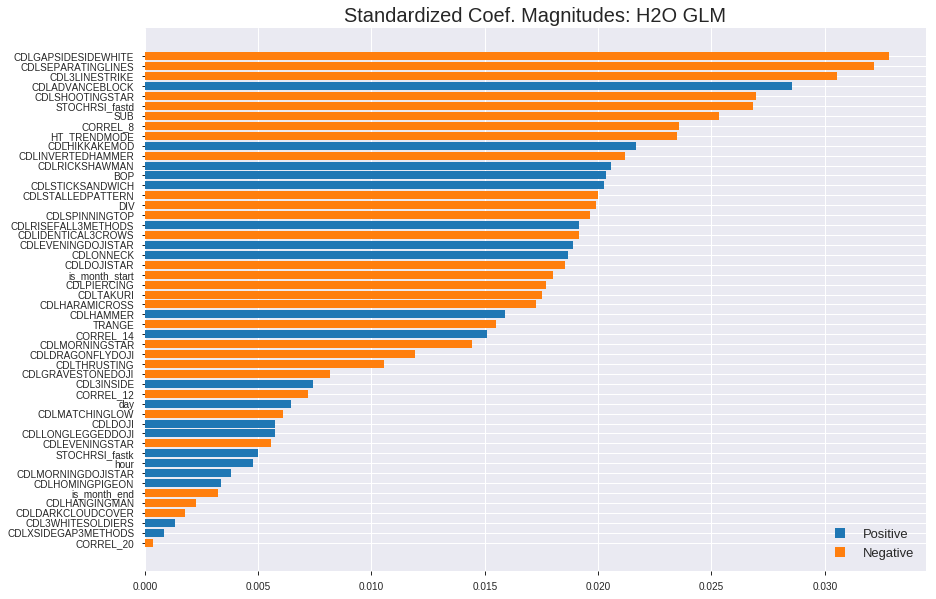

'log_likelihood'
--2019-08-25 17:28:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_172836_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_172836_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastd',
 'SUB',
 'CORREL_8',
 'HT_TRENDMODE',
 'CDLHIKKAKEMOD',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'BOP',
 'CDLSTICKSANDWICH',
 'CDLSTALLEDPATTERN',
 'DIV',
 'CDLSPINNINGTOP',
 'CDLRISEFALL3METHODS',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLDOJISTAR',
 'is_month_start',
 'CDLPIERCING',
 'CDLTAKURI',
 'CDLHARAMICROSS',
 'CDLHAMMER',
 'TRANGE',
 'CORREL_14',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTHRUSTING',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CORREL_12',
 'day',
 'CDLMATCHINGLOW',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLEVENINGSTAR',
 'STOCHRSI_fastk',
 'hour',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLXSIDEGAP3METHODS',
 'CORREL_20']

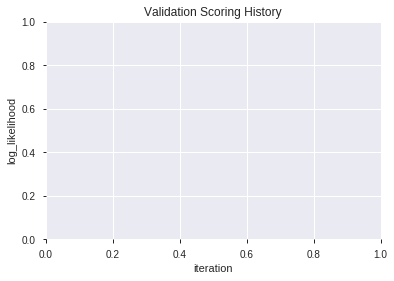

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_172848_model_5  0.531773  0.717875              0.491112  0.510817  0.260934
1  XGBoost_grid_1_AutoML_20190825_172848_model_1  0.512146  0.716108              0.500000  0.510604  0.260717
2               XGBoost_3_AutoML_20190825_172848  0.507561  0.703739              0.500000  0.505004  0.255029
3               XGBoost_1_AutoML_20190825_172848  0.505711  0.711902              0.491112  0.508902  0.258981
4  XGBoost_grid_1_AutoML_20190825_172848_model_6  0.501207  0.709575              0.500000  0.507601  0.257659
5  XGBoost_grid_1_AutoML_20190825_172848_model_7  0.499839  0.717807              0.495536  0.511416  0.261546
6  XGBoost_grid_1_AutoML_20190825_172848_model_3  0.495817  0.712146              0.495536  0.508870  0.258949
7  XGBoost_grid_1_AutoML_20190825_172848_model_4  0.477558  0.707573              0.495536  0.507039  0.257089
8  XGBoost_grid_1_AutoML_20190825_172848_model_2  0.475788  0.705659              0.500000  0.506091  0.256129
9               XGBoost_2_AutoML_20190825_172848  0.475788  0.713645              0.500000  0.509829  0.259926

variable  relative_importance  scaled_importance  percentage
0                   BOP          2436.767090           1.000000    0.121166
1                   DIV          2106.081543           0.864293    0.104723
2                TRANGE          2099.465576           0.861578    0.104394
3        STOCHRSI_fastd          1977.040771           0.811338    0.098306
4             CORREL_20          1855.247314           0.761356    0.092250
5                   day          1786.023438           0.732948    0.088808
6        STOCHRSI_fastk          1474.646240           0.605165    0.073325
7             CORREL_14          1406.038086           0.577010    0.069914
8                  hour          1172.608032           0.481215    0.058307
9                   SUB          1164.213745           0.477770    0.057889
10            CORREL_12           766.708008           0.314641    0.038124
11             CORREL_8           574.233337           0.235654    0.028553
12         HT_TRENDMODE           260.976440           0.107099    0.012977
13       CDLSPINNINGTOP           209.020340           0.085778    0.010393
14              CDLDOJI           132.493896           0.054373    0.006588
15       CDLRICKSHAWMAN            70.875183           0.029086    0.003524
16    CDLGRAVESTONEDOJI            62.301731           0.025567    0.003098
17            CDLHAMMER            52.394432           0.021502    0.002605
18         is_month_end            48.168102           0.019767    0.002395
19          CDLDOJISTAR            46.850609           0.019227    0.002330
20      CDLADVANCEBLOCK            45.155235           0.018531    0.002245
21     CDLDRAGONFLYDOJI            45.152485           0.018530    0.002245
22    CDLLONGLEGGEDDOJI            43.936687           0.018031    0.002185
23       CDLMATCHINGLOW            43.214867           0.017735    0.002149
24       is_month_start            43.134022           0.017701    0.002145
25   CDLSEPARATINGLINES            23.383581           0.009596    0.001163
26  CDLXSIDEGAP3METHODS            19.333775           0.007934    0.000961
27        CDLHANGINGMAN            17.984324           0.007380    0.000894
28           CDL3INSIDE            15.676697           0.006433    0.000780
29       CDLMORNINGSTAR            12.728130           0.005223    0.000633
30    CDLSTALLEDPATTERN            12.185918           0.005001    0.000606
31            CDLTAKURI            11.261191           0.004621    0.000560
32    CDLINVERTEDHAMMER             9.786203           0.004016    0.000487
33      CDLSHOOTINGSTAR             9.289316           0.003812    0.000462
34        CDLHIKKAKEMOD             9.270539           0.003804    0.000461
35       CDLHARAMICROSS             7.371815           0.003025    0.000367
36       CDLEVENINGSTAR             6.891404           0.002828    0.000343
37    CDL3WHITESOLDIERS             6.524768           0.002678    0.000324
38       CDL3LINESTRIKE             6.312667           0.002591    0.000314
39  CDLGAPSIDESIDEWHITE             6.211303           0.002549    0.000309
40         CDLTHRUSTING             5.537000           0.002272    0.000275
41   CDLIDENTICAL3CROWS             2.901987           0.001191    0.000144
42   CDLMORNINGDOJISTAR             2.527790           0.001037    0.000126
43            CDLONNECK             1.744452           0.000716    0.000087
44     CDLSTICKSANDWICH             1.388690           0.000570    0.000069

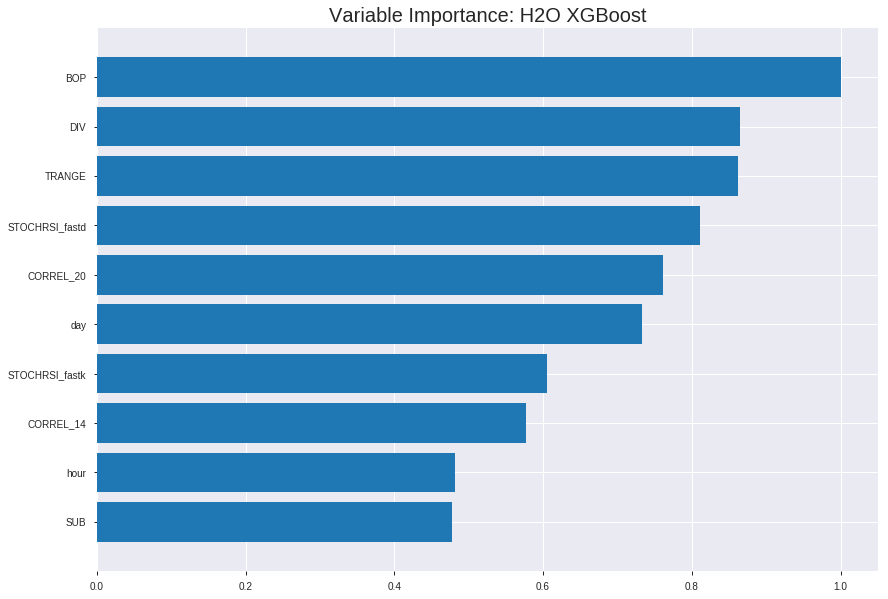

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_172848_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06690214452394419
RMSE: 0.25865448869861934
LogLoss: 0.2915483743651362
Mean Per-Class Error: 0.0012360939431397266
AUC: 0.9999917373399523
pr_auc: 0.997317263091424
Gini: 0.9999834746799046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49183547496795654: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      807  2    0.0025   (2.0/809.0)
1      0    748  0        (0.0/748.0)
Total  807  750  0.0013   (2.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491835     0.998665  197
max f2                       0.491835     0.999466  197
max f0point5                 0.551718     0.998926  191
max accuracy                 0.516184     0.998715  195
max precision                0.878228     1         0
max recall                   0.491835     1         197
max specificity              0.878228     1         0
max absolute_mcc             0.491835     0.997431  197
max min_per_class_accuracy   0.516184     0.998663  195
max mean_per_class_accuracy  0.491835     0.998764  197

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.19 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102762                   0.859305           2.08155  2.08155            1                0.867278  1                           0.867278            0.0213904       0.0213904                  108.155  108.155
    2        0.0205523                   0.846671           2.08155  2.08155            1                0.852496  1                           0.859887            0.0213904       0.0427807                  108.155  108.155
    3        0.0301863                   0.834362           2.08155  2.08155            1                0.840266  1                           0.853625            0.0200535       0.0628342                  108.155  108.155
    4        0.0404624                   0.827991           2.08155  2.08155            1                0.831015  1                           0.847883            0.0213904       0.0842246                  108.155  108.155
    5        0.0500963                   0.82161            2.08155  2.08155            1                0.825054  1                           0.843493            0.0200535       0.104278                   108.155  108.155
    6        0.100193                    0.79959            2.08155  2.08155            1                0.810726  1                           0.827109            0.104278        0.208556                   108.155  108.155
    7        0.150289                    0.781549           2.08155  2.08155            1                0.790577  1                           0.814932            0.104278        0.312834                   108.155  108.155
    8        0.200385                    0.761524           2.08155  2.08155            1                0.77064   1                           0.803859            0.104278        0.417112                   108.155  108.155
    9        0.299936                    0.726708           2.08155  2.08155            1                0.744593  1                           0.784188            0.207219        0.624332                   108.155  108.155
    10       0.400128                    0.675494           2.08155  2.08155            1                0.702996  1                           0.763857            0.208556        0.832888                   108.155  108.155
    11       0.500321                    0.374427           1.66791  1.99872            0.801282         0.587172  0.960205                    0.728475            0.167112        1                          66.7909  99.8716
    12       0.599872                    0.286064           0        1.66702            0                0.317814  0.800857                    0.660324            0               1                          -100     66.7024
    13       0.700064                    0.248899           0        1.42844            0                0.267915  0.686239                    0.604163            0               1                          -100     42.844
    14       0.799615                    0.216957           0        1.2506             0                0.231608  0.600803                    0.557781            0               1                          -100     25.0602
    15       0.899807                    0.182585           0        1.11135            0                0.200001  0.533904                    0.517942            0               1                          -100     11.1349
    16       1                           0.0946397          0        1                  0                0.157893  0.480411                    0.481868            0               1                



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2706087322841
RMSE: 0.520200665401439
LogLoss: 0.7398687358089187
Mean Per-Class Error: 0.4811043566362716
AUC: 0.493242147922999
pr_auc: 0.45381647758162535
Gini: -0.01351570415400205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16666121780872345: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    210  0        (0.0/210.0)
Total  0    445  0.5281   (235.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166661     0.641221  399
max f2                       0.166661     0.817121  399
max f0point5                 0.166661     0.527638  399
max accuracy                 0.826687     0.525843  0
max precision                0.595352     0.488889  83
max recall                   0.166661     1         399
max specificity              0.826687     0.995745  0
max absolute_mcc             0.765029     0.100771  4
max min_per_class_accuracy   0.482392     0.504762  198
max mean_per_class_accuracy  0.374491     0.518896  306

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.763134           0         0                  0                0.791428  0                           0.791428            0               0                          -100      -100
    2        0.0202247                   0.738868           1.58929   0.706349           0.75             0.752452  0.333333                    0.774105            0.0142857       0.0142857                  58.9286   -29.3651
    3        0.0314607                   0.724263           0.42381   0.605442           0.2              0.733493  0.285714                    0.759601            0.0047619       0.0190476                  -57.619   -39.4558
    4        0.0404494                   0.705477           1.05952   0.706349           0.5              0.715785  0.333333                    0.749864            0.00952381      0.0285714                  5.95238   -29.3651
    5        0.0516854                   0.695292           0.42381   0.644928           0.2              0.700143  0.304348                    0.739055            0.0047619       0.0333333                  -57.619   -35.5072
    6        0.101124                    0.663056           1.05952   0.847619           0.5              0.679637  0.4                         0.710006            0.052381        0.0857143                  5.95238   -15.2381
    7        0.150562                    0.630421           1.15584   0.948827           0.545455         0.647688  0.447761                    0.689544            0.0571429       0.142857                   15.5844   -5.11727
    8        0.2                         0.595429           1.25216   1.02381            0.590909         0.609534  0.483146                    0.669766            0.0619048       0.204762                   25.2165   2.38095
    9        0.301124                    0.555378           0.941799  0.996269           0.444444         0.576581  0.470149                    0.638472            0.0952381       0.3                        -5.82011  -0.373134
    10       0.4                         0.519645           0.915043  0.97619            0.431818         0.538891  0.460674                    0.613857            0.0904762       0.390476                   -8.49567  -2.38095
    11       0.501124                    0.477211           1.13016   1.00726            0.533333         0.49799   0.475336                    0.590475            0.114286        0.504762                   13.0159   0.72603
    12       0.6                         0.435201           0.722403  0.960317           0.340909         0.454862  0.453184                    0.568127            0.0714286       0.57619                    -27.7597  -3.96825
    13       0.698876                    0.398069           1.30032   1.00842            0.613636         0.416447  0.475884                    0.546668            0.128571        0.704762                   30.0325   0.842137
    14       0.8                         0.363794           1.08307   1.01786            0.511111         0.381809  0.480337                    0.525829            0.109524        0.814286                   8.30688   1.78571
    15       0.898876                    0.303572           0.818723  0.995952           0.386364         0.332262  0.47                        0.504537            0.0809524       0.895238                   -18.1277  -0.404762
    16       1                           0.166661           1.03598   1                  0.488889         0.246595  0.47191                     0.47845


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:28:54  2.382 sec   0                  0.5              0.693147            0.5             0                  1                0.519589                         0.5                0.693147              0.5               0                    1                  0.52809
    2019-08-25 17:28:54  2.645 sec   5                  0.458824         0.613694            0.951282        0.948746           2.08155          0.118176                         0.50242            0.698064              0.491966          0.463359             0.847619           0.52809
    2019-08-25 17:28:55  2.881 sec   10                 0.423163         0.549053            0.987618        0.985975           2.08155          0.0481696                        0.502493           0.698309              0.507872          0.472018             0.847619           0.503371
    2019-08-25 17:28:55  3.086 sec   15                 0.393563         0.497994            0.995437        0.993713           2.08155          0.029544                         0.50471            0.703155              0.513384          0.467986             1.27143            0.52809
    2019-08-25 17:28:55  3.326 sec   20                 0.365095         0.451028            0.998875        0.996101           2.08155          0.0134875                        0.50887            0.712424              0.504438          0.461566             0.847619           0.52809
    2019-08-25 17:28:55  3.531 sec   25                 0.344153         0.417609            0.999453        0.998064           2.08155          0.00899165                       0.512837           0.721069              0.489088          0.457319             0.847619           0.52809
    2019-08-25 17:28:55  3.769 sec   30                 0.380619         0.470608            0.957345        0.96267            2.08155          0.144509                         0.500347           0.693868              0.50156           0.727891             0.99663            0.525843
    2019-08-25 17:28:56  4.033 sec   35                 0.425533         0.545496            0.834567        0.885897           2.08155          0.30122                          0.515273           0.727453              0.496474          0.458547             0.847619           0.52809
    2019-08-25 17:28:56  4.279 sec   40                 0.421501         0.536903            0.835334        0.887825           2.08155          0.300578                         0.517823           0.733712              0.493394          0.453197             0.42381            0.52809
    2019-08-25 17:28:56  4.536 sec   45                 0.350723         0.416527            0.959404        0.965197           2.08155          0.154143                         0.518722           0.73615               0.494387          0.455792             0.847619           0.52809
    2019-08-25 17:28:57  4.815 sec   50                 0.258654         0.291548            0.999992        0.997317           2.08155          0.00128452                       0.520201           0.739869              0.493242          0.453816             0                  0.52809

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2436.76708984375       1.0                    0.12116552981062761
DIV                 2106.08154296875       0.8642933301860195     0.10472255926378077
TRANGE              2099.465576171875      0.8615782710306124     0.10439358768274866
STOCHRSI_fastd      1977.040771484375      0.8113376037145784     0.09830615060936193
CORREL_20           1855.247314453125      0.7613560287257848     0.09225010659507513
---                 ---                    ---                    ---
CDLTHRUSTING        5.536999702453613      0.0022722728509964635  0.0002753211438652918
CDLIDENTICAL3CROWS  2.901986598968506      0.0011909166908334217  0.00014429805180515094
CDLMORNINGDOJISTAR  2.527790069580078      0.0010373539925566562  0.0001256915461092971
CDLONNECK           1.7444515228271484     0.0007158876735071984  8.674090924539729e-05
CDLSTICKSANDWICH    1.3886899948120117     0.0005698903274752685  6.905106346249298e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6666666666666666)

('auc', 0.5317728442728443)

('logloss', 0.7178749865909949)

('mean_per_class_error', 0.4572072072072072)

('rmse', 0.5108168755260099)

('mse', 0.26093388032215503)

xgboost prediction progress: |████████████████████████████████████████████| 100%


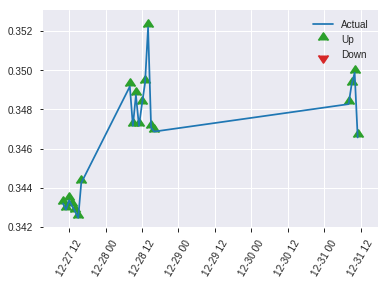


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26093388032215503
RMSE: 0.5108168755260099
LogLoss: 0.7178749865909949
Mean Per-Class Error: 0.4572072072072072
AUC: 0.5317728442728443
pr_auc: 0.510507855907068
Gini: 0.06354568854568865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23875603079795837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    109  0.9732   (109.0/112.0)
1      1    110  0.009    (1.0/111.0)
Total  4    219  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238756     0.666667  218
max f2                       0.182115     0.832084  222
max f0point5                 0.270421     0.558428  213
max accuracy                 0.481353     0.542601  96
max precision                0.610493     0.6       34
max recall                   0.182115     1         222
max specificity              0.761437     0.991071  0
max absolute_mcc             0.699417     0.150768  4
max min_per_class_accuracy   0.459171     0.526786  111
max mean_per_class_accuracy  0.448874     0.542793  120

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 46.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.727165           0         0                  0                0.74626   0                           0.74626             0               0                          -100      -100
    2        0.0224215                   0.698434           0         0                  0                0.701787  0                           0.728471            0               0                          -100      -100
    3        0.0313901                   0.691724           1.0045    0.287001           0.5              0.696798  0.142857                    0.719421            0.00900901      0.00900901                 0.45045   -71.2999
    4        0.0403587                   0.683962           2.00901   0.66967            1                0.687619  0.333333                    0.712354            0.018018        0.027027                   100.901   -33.033
    5        0.0538117                   0.676819           1.33934   0.837087           0.666667         0.680395  0.416667                    0.704364            0.018018        0.045045                   33.9339   -16.2913
    6        0.103139                    0.635712           1.27846   1.04818            0.636364         0.653352  0.521739                    0.679967            0.0630631       0.108108                   27.846    4.81786
    7        0.152466                    0.611341           1.4611    1.18177            0.727273         0.6237    0.588235                    0.661763            0.0720721       0.18018                    46.1097   18.177
    8        0.201794                    0.580545           0.547912  1.02683            0.272727         0.595957  0.511111                    0.645677            0.027027        0.207207                   -45.2088  2.68268
    9        0.300448                    0.534948           1.09582   1.04948            0.545455         0.561617  0.522388                    0.618076            0.108108        0.315315                   9.58231   4.94823
    10       0.399103                    0.486194           1.18714   1.08351            0.590909         0.509055  0.539326                    0.591127            0.117117        0.432432                   18.7142   8.35105
    11       0.502242                    0.459171           0.96083   1.05832            0.478261         0.475012  0.526786                    0.567282            0.0990991       0.531532                   -3.91696  5.83172
    12       0.600897                    0.433255           0.913186  1.03449            0.454545         0.444423  0.514925                    0.547111            0.0900901       0.621622                   -8.68141  3.44897
    13       0.699552                    0.390597           1.09582   1.04314            0.545455         0.410644  0.519231                    0.527865            0.108108        0.72973                    9.58231   4.31393
    14       0.798206                    0.348794           0.730549  1.0045             0.363636         0.369507  0.5                         0.508293            0.0720721       0.801802                   -26.9451  0.45045
    15       0.896861                    0.298251           1.09582   1.01455            0.545455         0.323961  0.505                       0.488017            0.108108        0.90991                    9.58231   1.45495
    16       1                           0.182115           0.873482  1                  0.434783         0.26421   0.497758                    0.464933            0.

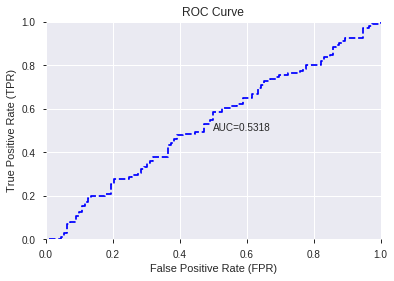

This function is available for GLM models only


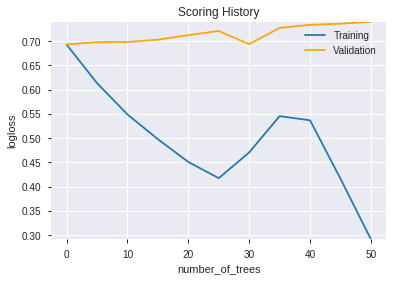

--2019-08-25 17:29:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_172848_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_172848_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHRSI_fastd',
 'CORREL_20',
 'day',
 'STOCHRSI_fastk',
 'CORREL_14',
 'hour',
 'SUB',
 'CORREL_12',
 'CORREL_8',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'is_month_end',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLSTICKSANDWICH']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_172908_model_1  0.451496  0.701626                   0.5  0.504196  0.254214

variable  relative_importance  scaled_importance    percentage
0                    SUB         7.985213e-03           1.000000  9.907636e-03
1            CDLBELTHOLD         7.642360e-03           0.957064  9.482241e-03
2                    DIV         7.629241e-03           0.955421  9.465964e-03
3     CDLSEPARATINGLINES         7.119096e-03           0.891535  8.833003e-03
4            CDLMARUBOZU         7.109034e-03           0.890275  8.820518e-03
...                  ...                  ...                ...           ...
1031           MAVP_14_1         3.793598e-06           0.000475  4.706899e-06
1032           MAVP_14_2         3.532003e-06           0.000442  4.382324e-06
1033                ACOS         2.459848e-06           0.000308  3.052051e-06
1034                 EXP         2.128509e-06           0.000267  2.640943e-06
1035                ASIN         5.886881e-08           0.000007  7.304135e-08

[1036 rows x 4 columns]

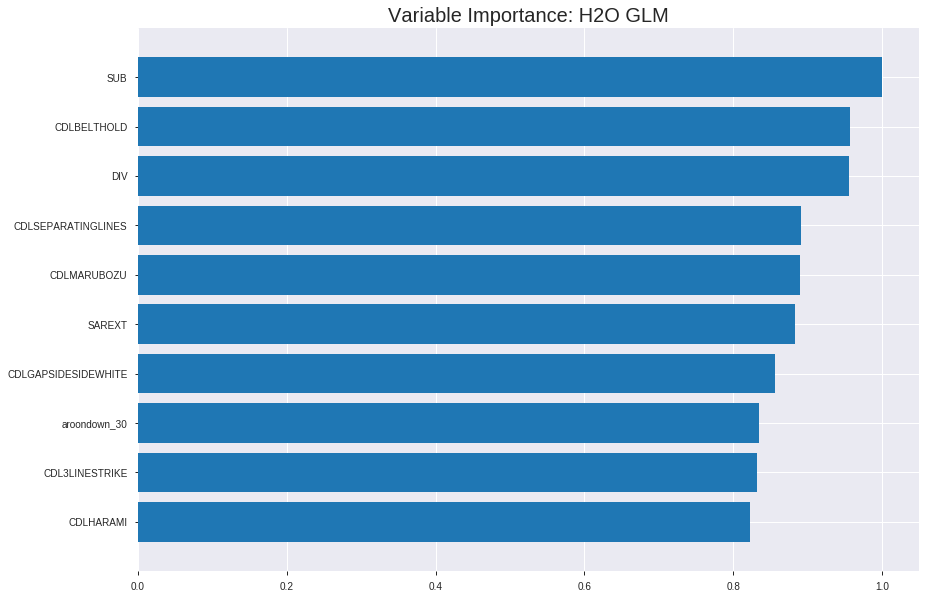

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_172908_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24570106522925916
RMSE: 0.4956824237647116
LogLoss: 0.6845045447095485
Null degrees of freedom: 1556
Residual degrees of freedom: 520
Null deviance: 2156.0698562406105
Residual deviance: 2131.547152225534
AIC: 4205.547152225534
AUC: 0.5952610339562278
pr_auc: 0.5575015644822129
Gini: 0.19052206791245552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44916995607234056: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      138  671   0.8294   (671.0/809.0)
1      56   692   0.0749   (56.0/748.0)
Total  194  1363  0.4669   (727.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44917      0.655613  325
max f2                       0.415612     0.823063  394
max f0point5                 0.468176     0.567797  252
max accuracy                 0.476        0.57675   223
max precision                0.593002     1         0
max recall                   0.415612     1         394
max specificity              0.593002     1         0
max absolute_mcc             0.468176     0.157669  252
max min_per_class_accuracy   0.480089     0.569839  210
max mean_per_class_accuracy  0.476        0.578494  223

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.554547           1.56116   1.56116            0.75             0.570354  0.75                        0.570354            0.0160428       0.0160428                  56.1163   56.1163
    2        0.0205523                   0.546153           1.30097   1.43107            0.625            0.550145  0.6875                      0.560249            0.013369        0.0294118                  30.0969   43.1066
    3        0.0301863                   0.541602           0.69385   1.19578            0.333333         0.54423   0.574468                    0.555137            0.00668449      0.0360963                  -30.615   19.5785
    4        0.0404624                   0.535696           1.17087   1.18946            0.5625           0.538289  0.571429                    0.550858            0.0120321       0.0481283                  17.0872   18.9458
    5        0.0500963                   0.530817           1.66524   1.28095            0.8              0.532736  0.615385                    0.547373            0.0160428       0.0641711                  66.5241   28.0954
    6        0.100193                    0.51647            1.22758   1.25427            0.589744         0.522684  0.602564                    0.535028            0.0614973       0.125668                   22.7581   25.4268
    7        0.150289                    0.508374           1.14752   1.21869            0.551282         0.512026  0.58547                     0.527361            0.0574866       0.183155                   14.7522   21.8686
    8        0.200385                    0.50211            1.09415   1.18755            0.525641         0.505086  0.570513                    0.521792            0.0548128       0.237968                   9.41485   18.7551
    9        0.299936                    0.493713           1.16835   1.18118            0.56129          0.497425  0.567452                    0.513705            0.11631         0.354278                   16.8354   18.118
    10       0.400128                    0.487025           1.09415   1.15939            0.525641         0.490421  0.556982                    0.507874            0.109626        0.463904                   9.41485   15.9387
    11       0.500321                    0.479862           1.09415   1.14632            0.525641         0.483726  0.550706                    0.503038            0.109626        0.573529                   9.41485   14.6323
    12       0.599872                    0.471182           1.0072    1.12324            0.483871         0.47549   0.539615                    0.498467            0.100267        0.673797                   0.7202    12.3235
    13       0.700064                    0.463535           0.907343  1.09234            0.435897         0.467224  0.524771                    0.493995            0.0909091       0.764706                   -9.26573  9.23368
    14       0.799615                    0.45571            0.899767  1.06836            0.432258         0.459751  0.513253                    0.489732            0.0895722       0.854278                   -10.0233  6.83622
    15       0.899807                    0.445719           0.81394   1.04003            0.391026         0.451599  0.499643                    0.485486            0.0815508       0.935829                   -18.606   4.00325
    16       1                           0.310842           0.640477  1                  0.307692         0.434836  0.480411                    0.480411          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2492807858665513
RMSE: 0.4992802678521867
LogLoss: 0.691705217960661
Null degrees of freedom: 444
Residual degrees of freedom: -592
Null deviance: 615.6246511654862
Residual deviance: 615.6176439849881
AIC: 2689.6176439849883
AUC: 0.5251975683890577
pr_auc: 0.48831051990988456
Gini: 0.05039513677811547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4353234554859636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    231  0.983    (231.0/235.0)
1      1    209  0.0048   (1.0/210.0)
Total  5    440  0.5213   (232.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.435323     0.643077   394
max f2                       0.427769     0.817121   399
max f0point5                 0.470336     0.538977   315
max accuracy                 0.532782     0.539326   42
max precision                0.549833     0.636364   10
max recall                   0.427769     1          399
max specificity              0.573178     0.995745   0
max absolute_mcc             0.470336     0.0914417  315
max min_per_class_accuracy   0.498817     0.5        194
max mean_per_class_accuracy  0.470336     0.536322   315

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 49.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.555855           0.42381   0.42381            0.2              0.563463  0.2                         0.563463            0.0047619       0.0047619                  -57.619   -57.619
    2        0.0202247                   0.550807           2.11905   1.17725            1                0.553509  0.555556                    0.559039            0.0190476       0.0238095                  111.905   17.7249
    3        0.0314607                   0.547681           1.27143   1.21088            0.6              0.549095  0.571429                    0.555488            0.0142857       0.0380952                  27.1429   21.0884
    4        0.0404494                   0.543566           1.05952   1.17725            0.5              0.545317  0.555556                    0.553228            0.00952381      0.047619                   5.95238   17.7249
    5        0.0516854                   0.540861           0.847619  1.10559            0.4              0.542019  0.521739                    0.550791            0.00952381      0.0571429                  -15.2381  10.559
    6        0.101124                    0.532743           1.25216   1.17725            0.590909         0.537372  0.555556                    0.544231            0.0619048       0.119048                   25.2165   17.7249
    7        0.150562                    0.527031           0.770563  1.04371            0.363636         0.529232  0.492537                    0.539306            0.0380952       0.157143                   -22.9437  4.371
    8        0.2                         0.521905           1.05952   1.04762            0.5              0.524448  0.494382                    0.535633            0.052381        0.209524                   5.95238   4.7619
    9        0.301124                    0.513792           0.988889  1.0279             0.466667         0.517261  0.485075                    0.529463            0.1             0.309524                   -1.11111  2.78962
    10       0.4                         0.506143           1.05952   1.03571            0.5              0.5097    0.488764                    0.524578            0.104762        0.414286                   5.95238   3.57143
    11       0.501124                    0.498084           0.847619  0.997758           0.4              0.502494  0.470852                    0.520122            0.0857143       0.5                        -15.2381  -0.224215
    12       0.6                         0.48934            1.30032   1.04762            0.613636         0.493364  0.494382                    0.515712            0.128571        0.628571                   30.0325   4.7619
    13       0.698876                    0.479543           0.915043  1.02886            0.431818         0.484372  0.485531                    0.511278            0.0904762       0.719048                   -8.49567  2.88623
    14       0.8                         0.470535           1.13016   1.04167            0.533333         0.475193  0.491573                    0.506717            0.114286        0.833333                   13.0159   4.16667
    15       0.898876                    0.458334           0.866883  1.02244            0.409091         0.465547  0.4825                      0.502188            0.0857143       0.919048                   -13.3117  2.24405
    16       1                           0.427769           0.800529  1                  0.377778         0.446407  0.47191                     0.496547            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:29:12  0.000 sec   2            2.9       1037          1.36901           1.38341
    2019-08-25 17:29:13  1.905 sec   4            2.1       1037          1.3655            1.38415
    2019-08-25 17:29:15  3.758 sec   6            1.5       1037          1.36144           1.38501
    2019-08-25 17:29:17  5.639 sec   8            1.1       1037          1.35675           1.38617
    2019-08-25 17:29:19  7.484 sec   10           0.81      1037          1.35147           1.38773
    2019-08-25 17:29:21  9.361 sec   12           0.59      1037          1.34564           1.38963

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5291479820627802)

('F1', 0.6646706586826348)

('auc', 0.451496138996139)

('logloss', 0.7016264571714836)

('mean_per_class_error', 0.47281209781209776)

('rmse', 0.5041964319695623)

('mse', 0.2542140420108375)

glm prediction progress: |████████████████████████████████████████████████| 100%


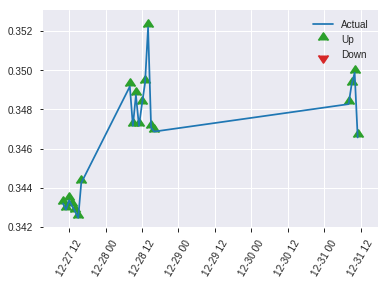


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2542140420108375
RMSE: 0.5041964319695623
LogLoss: 0.7016264571714836
Null degrees of freedom: 222
Residual degrees of freedom: -814
Null deviance: 309.40779410652675
Residual deviance: 312.9253998984817
AIC: 2386.925399898482
AUC: 0.451496138996139
pr_auc: 0.49617382945356336
Gini: -0.09700772200772201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46819687483279054: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    111  0        (0.0/111.0)
Total  0    223  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468197     0.664671  222
max f2                       0.468197     0.832084  222
max f0point5                 0.505978     0.559662  208
max accuracy                 0.573591     0.529148  13
max precision                0.592898     1         0
max recall                   0.468197     1         222
max specificity              0.592898     1         0
max absolute_mcc             0.582107     0.152126  4
max min_per_class_accuracy   0.545386     0.455357  111
max mean_per_class_accuracy  0.573591     0.527188  13

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.582517           2.00901   2.00901            1                0.586158  1                           0.586158            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.581859           2.00901   2.00901            1                0.582111  1                           0.584539            0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.579349           0         1.43501            0                0.580861  0.714286                    0.583488            0               0.045045                   -100      43.5006
    4        0.0403587                   0.578651           1.0045    1.33934            0.5              0.578885  0.666667                    0.582465            0.00900901      0.0540541                  0.45045   33.9339
    5        0.0538117                   0.57382            1.33934   1.33934            0.666667         0.575583  0.666667                    0.580745            0.018018        0.0720721                  33.9339   33.9339
    6        0.103139                    0.57053            0.730549  1.04818            0.363636         0.572485  0.521739                    0.576795            0.036036        0.108108                   -26.9451  4.81786
    7        0.152466                    0.565466           1.09582   1.06359            0.545455         0.568216  0.529412                    0.574019            0.0540541       0.162162                   9.58231   6.3593
    8        0.201794                    0.562243           0.547912  0.937538           0.272727         0.563973  0.466667                    0.571564            0.027027        0.189189                   -45.2088  -6.24625
    9        0.300448                    0.556594           0.821867  0.899556           0.409091         0.559869  0.447761                    0.567724            0.0810811       0.27027                    -17.8133  -10.0444
    10       0.399103                    0.550286           0.730549  0.857779           0.363636         0.554268  0.426966                    0.564397            0.0720721       0.342342                   -26.9451  -14.2221
    11       0.502242                    0.545386           1.13553   0.914817           0.565217         0.548002  0.455357                    0.56103             0.117117        0.459459                   13.5527   -8.51834
    12       0.600897                    0.539393           1.0045    0.929541           0.5              0.542159  0.462687                    0.557932            0.0990991       0.558559                   0.45045   -7.04585
    13       0.699552                    0.532578           0.821867  0.914357           0.409091         0.536695  0.455128                    0.554937            0.0810811       0.63964                    -17.8133  -8.56433
    14       0.798206                    0.521751           1.27846   0.959358           0.636364         0.527984  0.477528                    0.551606            0.126126        0.765766                   27.846    -4.06418
    15       0.896861                    0.508835           1.27846   0.994459           0.636364         0.516682  0.495                       0.547764            0.126126        0.891892                   27.846    -0.554054
    16       1                           0.468197           1.04818   1                  0.521739         0.497161  0.497758                    0.542545 

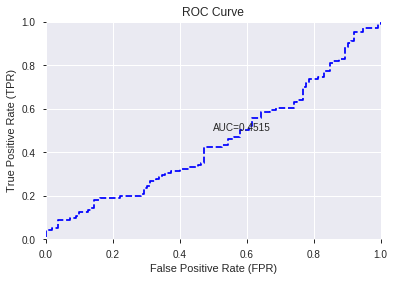

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


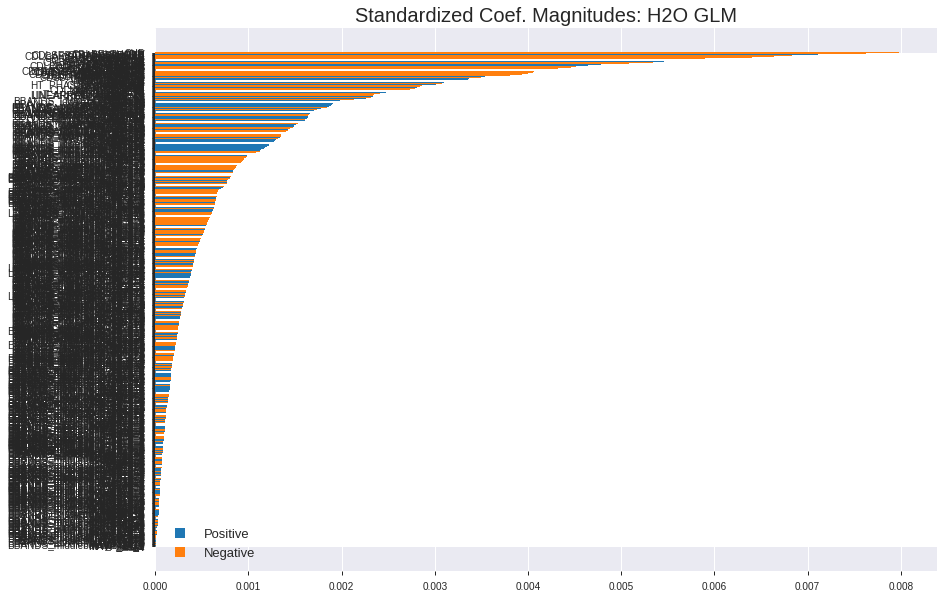

'log_likelihood'
--2019-08-25 17:29:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_172908_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_172908_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

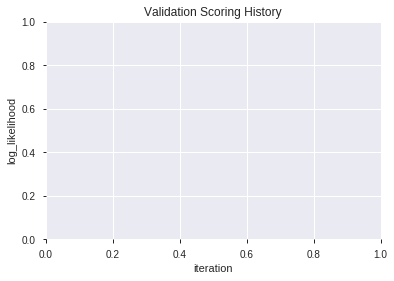

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_172947_model_2  0.604569  0.685158              0.428773  0.495962  0.245978
1  XGBoost_grid_1_AutoML_20190825_172947_model_1  0.542551  0.732027              0.500000  0.517718  0.268032
2               XGBoost_3_AutoML_20190825_172947  0.535151  0.724598              0.473214  0.514488  0.264698
3  XGBoost_grid_1_AutoML_20190825_172947_model_3  0.522523  0.744317              0.491112  0.523188  0.273726
4               XGBoost_1_AutoML_20190825_172947  0.510940  0.722767              0.460023  0.513230  0.263405
5  XGBoost_grid_1_AutoML_20190825_172947_model_5  0.507561  0.798527              0.500000  0.543461  0.295349
6  XGBoost_grid_1_AutoML_20190825_172947_model_7  0.507320  0.745940              0.482183  0.523106  0.273639
7               XGBoost_2_AutoML_20190825_172947  0.504102  0.720344              0.500000  0.512545  0.262702
8  XGBoost_grid_1_AutoML_20190825_172947_model_6  0.502091  0.719745              0.495536  0.512070  0.262216
9  XGBoost_grid_1_AutoML_20190825_172947_model_4  0.496863  0.703972              0.486647  0.505182  0.255208

variable  relative_importance  scaled_importance  percentage
0                     CCI_12           129.439941           1.000000    0.022340
1                        BOP           114.124191           0.881677    0.019696
2                      ATR_8            86.281700           0.666577    0.014891
3             STOCHRSI_fastd            83.505333           0.645128    0.014412
4                     SAREXT            82.542419           0.637689    0.014246
..                       ...                  ...                ...         ...
340               MIDPOINT_8             0.332883           0.002572    0.000057
341  BBANDS_upperband_12_0_5             0.242275           0.001872    0.000042
342  BBANDS_lowerband_20_0_2             0.226905           0.001753    0.000039
343  BBANDS_upperband_12_1_2             0.225367           0.001741    0.000039
344   BBANDS_upperband_8_1_3             0.143547           0.001109    0.000025

[345 rows x 4 columns]

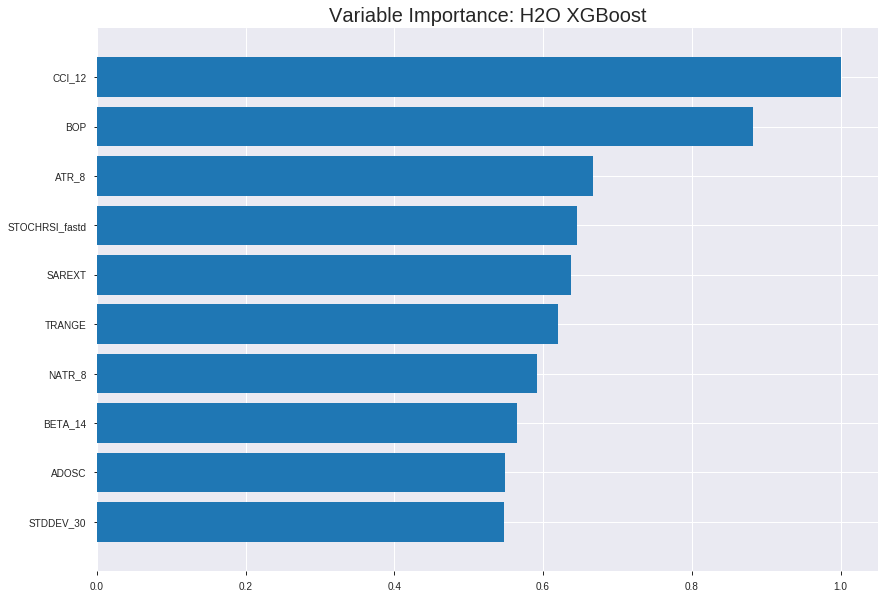

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_172947_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1780934198295701
RMSE: 0.4220111607879229
LogLoss: 0.545421116213183
Mean Per-Class Error: 0.12703426690374986
AUC: 0.9473957748061581
pr_auc: 0.9432915214746218
Gini: 0.8947915496123162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47743862122297287: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      694  115  0.1422   (115.0/809.0)
1      87   661  0.1163   (87.0/748.0)
Total  781  776  0.1297   (202.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477439     0.867454  206
max f2                       0.432902     0.908862  249
max f0point5                 0.519612     0.889668  167
max accuracy                 0.494067     0.874117  192
max precision                0.751917     1         0
max recall                   0.357503     1         324
max specificity              0.751917     1         0
max absolute_mcc             0.494067     0.748333  192
max min_per_class_accuracy   0.481793     0.868984  202
max mean_per_class_accuracy  0.492806     0.872966  193

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.711153           2.08155    2.08155            1                0.726039  1                           0.726039            0.0213904       0.0213904                  108.155   108.155
    2        0.0205523                   0.698758           2.08155    2.08155            1                0.704059  1                           0.715049            0.0213904       0.0427807                  108.155   108.155
    3        0.0301863                   0.686836           2.08155    2.08155            1                0.692114  1                           0.707729            0.0200535       0.0628342                  108.155   108.155
    4        0.0404624                   0.676562           1.95145    2.04851            0.9375           0.681218  0.984127                    0.700996            0.0200535       0.0828877                  95.1454   104.851
    5        0.0500963                   0.668992           2.08155    2.05486            1                0.673764  0.987179                    0.695759            0.0200535       0.102941                   108.155   105.486
    6        0.100193                    0.636226           2.08155    2.06821            1                0.650942  0.99359                     0.673351            0.104278        0.207219                   108.155   106.821
    7        0.150289                    0.609541           2.05486    2.06376            0.987179         0.623194  0.991453                    0.656632            0.102941        0.31016                    105.486   106.376
    8        0.200385                    0.588196           2.05486    2.06154            0.987179         0.598726  0.990385                    0.642155            0.102941        0.413102                   105.486   106.154
    9        0.299936                    0.549221           1.89354    2.00578            0.909677         0.568274  0.963597                    0.617634            0.188503        0.601604                   89.354    100.578
    10       0.400128                    0.512519           1.62788    1.91115            0.782051         0.532568  0.918138                    0.596333            0.163102        0.764706                   62.7879   91.1151
    11       0.500321                    0.476722           1.20089    1.76892            0.576923         0.494745  0.849807                    0.575989            0.120321        0.885027                   20.0895   76.8917
    12       0.599872                    0.441445           0.644609   1.58234            0.309677         0.458072  0.760171                    0.556421            0.0641711       0.949198                   -35.5391  58.2335
    13       0.700064                    0.410232           0.360268   1.40743            0.173077         0.426426  0.676147                    0.537816            0.0360963       0.985294                   -63.9732  40.7434
    14       0.799615                    0.377405           0.107435   1.24559            0.0516129        0.395264  0.598394                    0.520068            0.0106952       0.995989                   -89.2565  24.5587
    15       0.899807                    0.342093           0.0400298  1.11135            0.0192308        0.359316  0.533904                    0.502169            0.0040107       1                          -95.997   11.1349
    16       1                           0.20684            0          1                  0                0.312155  0.480411                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26018811735354597
RMSE: 0.510086382246719
LogLoss: 0.7140779480269385
Mean Per-Class Error: 0.49539007092198584
AUC: 0.4766869300911854
pr_auc: 0.4514201317929624
Gini: -0.0466261398176292
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3223402798175812: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    234  0.9957   (234.0/235.0)
1      0    210  0        (0.0/210.0)
Total  1    444  0.5258   (234.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.32234      0.642202   398
max f2                       0.32234      0.817757   398
max f0point5                 0.336856     0.528993   393
max accuracy                 0.678008     0.52809    1
max precision                0.678008     0.5        1
max recall                   0.32234      1          398
max specificity              0.688584     0.995745   0
max absolute_mcc             0.402236     0.0827272  363
max min_per_class_accuracy   0.52399      0.47234    199
max mean_per_class_accuracy  0.36425      0.50461    382

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 51.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.671634           0.42381   0.42381            0.2              0.678402  0.2                         0.678402            0.0047619       0.0047619                  -57.619   -57.619
    2        0.0202247                   0.659458           1.05952   0.706349           0.5              0.667317  0.333333                    0.673475            0.00952381      0.0142857                  5.95238   -29.3651
    3        0.0314607                   0.64529            0.847619  0.756803           0.4              0.654679  0.357143                    0.666762            0.00952381      0.0238095                  -15.2381  -24.3197
    4        0.0404494                   0.640635           1.58929   0.941799           0.75             0.642615  0.444444                    0.661396            0.0142857       0.0380952                  58.9286   -5.82011
    5        0.0516854                   0.635895           0.847619  0.921325           0.4              0.638329  0.434783                    0.656382            0.00952381      0.047619                   -15.2381  -7.86749
    6        0.101124                    0.612205           0.963203  0.941799           0.454545         0.62422   0.444444                    0.640658            0.047619        0.0952381                  -3.67965  -5.82011
    7        0.150562                    0.595002           0.866883  0.9172             0.409091         0.603733  0.432836                    0.628534            0.0428571       0.138095                   -13.3117  -8.28003
    8        0.2                         0.578975           0.866883  0.904762           0.409091         0.587596  0.426966                    0.618414            0.0428571       0.180952                   -13.3117  -9.52381
    9        0.301124                    0.559925           1.17725   0.996269           0.555556         0.569539  0.470149                    0.602001            0.119048        0.3                        17.7249   -0.373134
    10       0.4                         0.542572           0.963203  0.988095           0.454545         0.551028  0.466292                    0.589401            0.0952381       0.395238                   -3.67965  -1.19048
    11       0.501124                    0.524092           0.753439  0.940743           0.355556         0.533193  0.443946                    0.578058            0.0761905       0.471429                   -24.6561  -5.92569
    12       0.6                         0.505625           1.10768   0.968254           0.522727         0.514362  0.456929                    0.567561            0.109524        0.580952                   10.7684   -3.1746
    13       0.698876                    0.482591           1.01136   0.974353           0.477273         0.494888  0.459807                    0.55728             0.1             0.680952                   1.13636   -2.56469
    14       0.8                         0.455295           1.13016   0.994048           0.533333         0.469713  0.469101                    0.546211            0.114286        0.795238                   13.0159   -0.595238
    15       0.898876                    0.414548           0.915043  0.985357           0.431818         0.437311  0.465                       0.534232            0.0904762       0.885714                   -8.49567  -1.46429
    16       1                           0.285794           1.13016   1                  0.533333         0.371187  0.47191                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:30:01  2.313 sec   0                  0.5              0.693147            0.5             0                  1                0.519589                         0.5                0.693147              0.5               0                    1                  0.52809
    2019-08-25 17:30:02  2.930 sec   5                  0.491126         0.67553             0.754867        0.704483           2.08155          0.37508                          0.501287           0.695727              0.486717          0.463137             0.908163           0.516854
    2019-08-25 17:30:02  3.136 sec   10                 0.481988         0.657629            0.804406        0.787404           2.08155          0.297367                         0.502644           0.698464              0.478369          0.467064             1.27143            0.52809
    2019-08-25 17:30:02  3.338 sec   15                 0.474026         0.642205            0.837941        0.827677           2.08155          0.257547                         0.503488           0.700192              0.483151          0.464215             0.847619           0.52809
    2019-08-25 17:30:03  3.540 sec   20                 0.465439         0.625751            0.865401        0.852894           2.08155          0.229287                         0.503911           0.701072              0.490243          0.465852             0.847619           0.523596
    2019-08-25 17:30:03  3.774 sec   25                 0.457253         0.610267            0.889185        0.880722           2.08155          0.19589                          0.504425           0.702141              0.488703          0.467958             0.42381            0.523596
    2019-08-25 17:30:03  3.978 sec   30                 0.449585         0.595895            0.903807        0.897288           2.08155          0.179191                         0.505032           0.703409              0.49155           0.465864             0.847619           0.523596
    2019-08-25 17:30:03  4.187 sec   35                 0.44283          0.583321            0.914024        0.908682           2.08155          0.170841                         0.506695           0.706853              0.479929          0.45591              1.27143            0.523596
    2019-08-25 17:30:03  4.396 sec   40                 0.43589          0.57054             0.925468        0.919867           2.08155          0.154143                         0.507917           0.70943               0.480547          0.458554             0.847619           0.523596
    2019-08-25 17:30:04  4.609 sec   45                 0.428312         0.55675             0.937544        0.932543           2.08155          0.136159                         0.508806           0.711347              0.482239          0.45707              0.847619           0.523596
    2019-08-25 17:30:04  4.834 sec   50                 0.422011         0.545421            0.947396        0.943292           2.08155          0.129737                         0.510086           0.714078              0.476687          0.45142              0.42381            0.525843

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CCI_12                   129.43994140625        1.0                    0.02233952494790461
BOP                      114.12419128417969     0.8816767841851727     0.019696240516292974
ATR_8                    86.28170013427734      0.6665770951137903     0.014891015645996302
STOCHRSI_fastd           83.50533294677734      0.6451280187519097     0.01441185346950056
SAREXT                   82.54241943359375      0.6376889431256201     0.014245668053957713
---                      ---                    ---                    ---
MIDPOINT_8               0.33288294076919556    0.0025717173320129634  5.745094349746228e-05
BBANDS_upperband_12_0_5  0.24227510392665863    0.0018717182756308045  4.181329711390335e-05
BBANDS_lowerband_20_0_2  0.22690515220165253    0.0017529763204195675  3.916065824309895e-05
BBANDS_upperband_12_1_2  0.2253667712211609     0.0017410914187131969  3.889515518492609e-05
BBANDS_upperband_8_1_3   0.14354734122753143    0.0011089879960390668  2.4774265004441477e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6098654708520179)

('F1', 0.6883116883116883)

('auc', 0.6045688545688546)

('logloss', 0.6851580906688466)

('mean_per_class_error', 0.389559202059202)

('rmse', 0.4959617325897827)

('mse', 0.24597804019345912)

xgboost prediction progress: |████████████████████████████████████████████| 100%


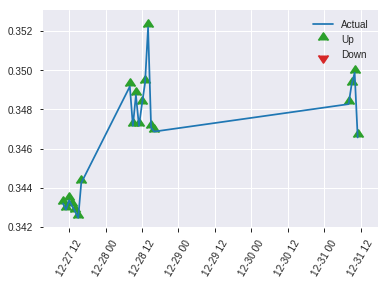


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24597804019345912
RMSE: 0.4959617325897827
LogLoss: 0.6851580906688466
Mean Per-Class Error: 0.389559202059202
AUC: 0.6045688545688546
pr_auc: 0.5479270918793435
Gini: 0.20913770913770913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48812559247016907: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      21   91   0.8125   (91.0/112.0)
1      5    106  0.045    (5.0/111.0)
Total  26   197  0.4305   (96.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488126     0.688312  196
max f2                       0.464195     0.842185  214
max f0point5                 0.52094      0.611028  139
max accuracy                 0.522751     0.609865  135
max precision                0.600989     0.647059  16
max recall                   0.464195     1         214
max specificity              0.641524     0.991071  0
max absolute_mcc             0.52094      0.228469  139
max min_per_class_accuracy   0.53945      0.580357  111
max mean_per_class_accuracy  0.52094      0.610441  139

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 53.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.63172            0.66967   0.66967            0.333333         0.636457  0.333333                    0.636457            0.00900901      0.00900901                 -33.033   -33.033
    2        0.0224215                   0.624452           1.0045    0.803604           0.5              0.62796   0.4                         0.633058            0.00900901      0.018018                   0.45045   -19.6396
    3        0.0313901                   0.613523           1.0045    0.861004           0.5              0.620557  0.428571                    0.629486            0.00900901      0.027027                   0.45045   -13.8996
    4        0.0403587                   0.609359           2.00901   1.11612            1                0.609997  0.555556                    0.625155            0.018018        0.045045                   100.901   11.6116
    5        0.0538117                   0.606947           0.66967   1.0045             0.333333         0.607976  0.5                         0.620861            0.00900901      0.0540541                  -33.033   0.45045
    6        0.103139                    0.596413           1.09582   1.04818            0.545455         0.601266  0.521739                    0.611489            0.0540541       0.108108                   9.58231   4.81786
    7        0.152466                    0.583327           0.913186  1.0045             0.454545         0.589927  0.5                         0.604513            0.045045        0.153153                   -8.68141  0.45045
    8        0.201794                    0.576418           1.27846   1.07147            0.636364         0.580185  0.533333                    0.598566            0.0630631       0.216216                   27.846    7.14715
    9        0.300448                    0.561652           1.09582   1.07947            0.545455         0.569248  0.537313                    0.588939            0.108108        0.324324                   9.58231   7.94675
    10       0.399103                    0.548749           1.27846   1.12866            0.636364         0.554882  0.561798                    0.580521            0.126126        0.45045                    27.846    12.8657
    11       0.502242                    0.53945            1.31022   1.16594            0.652174         0.544205  0.580357                    0.573063            0.135135        0.585586                   31.0223   16.5943
    12       0.600897                    0.524095           1.18714   1.16942            0.590909         0.531448  0.58209                     0.566231            0.117117        0.702703                   18.7142   16.9423
    13       0.699552                    0.515401           0.913186  1.13329            0.454545         0.518915  0.564103                    0.559558            0.0900901       0.792793                   -8.68141  13.3287
    14       0.798206                    0.501973           0.913186  1.10608            0.454545         0.508603  0.550562                    0.55326             0.0900901       0.882883                   -8.68141  10.6084
    15       0.896861                    0.484349           0.730549  1.06477            0.363636         0.494463  0.53                        0.546792            0.0720721       0.954955                   -26.9451  6.47748
    16       1                           0.437251           0.436741  1                  0.217391         0.467303  0.497758                    0.538594       

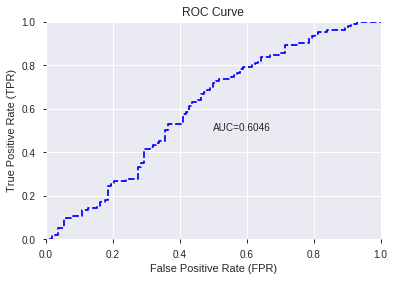

This function is available for GLM models only


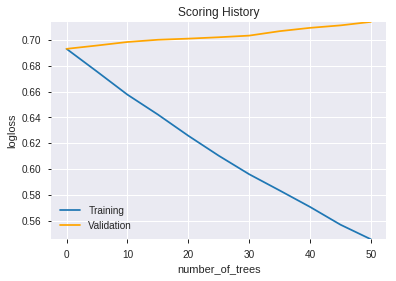

--2019-08-25 17:30:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_172947_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_172947_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_173035_model_8  0.538288  0.690629              0.473375  0.498778  0.248780
1  DeepLearning_grid_1_AutoML_20190825_173035_model_5  0.513594  0.698291              0.500000  0.502490  0.252497
2  DeepLearning_grid_1_AutoML_20190825_173035_model_7  0.505631  0.808378              0.500000  0.538326  0.289795
3               DeepLearning_1_AutoML_20190825_173035  0.491715  0.726570              0.500000  0.512394  0.262548
4  DeepLearning_grid_1_AutoML_20190825_173035_model_6  0.490911  0.699081              0.500000  0.503041  0.253050
5  DeepLearning_grid_1_AutoML_20190825_173035_model_9  0.487532  0.697992              0.500000  0.502403  0.252409
6  DeepLearning_grid_1_AutoML_20190825_173035_model_4  0.483430  0.885523              0.500000  0.560290  0.313925
7  DeepLearning_grid_1_AutoML_20190825_173035_model_2  0.472893  0.849054              0.491071  0.549224  0.301647
8  DeepLearning_grid_1_AutoML_20190825_173035_model_3  0.463562  0.806474              0.495536  0.532688  0.283757
9  DeepLearning_grid_1_AutoML_20190825_173035_model_1  0.446348  1.124625              0.495536  0.583434  0.340395

variable  relative_importance  scaled_importance  percentage
0        STOCHRSI_fastd             1.000000           1.000000    0.033759
1          HT_TRENDMODE             0.910485           0.910485    0.030737
2                   day             0.867597           0.867597    0.029290
3             CORREL_14             0.808701           0.808701    0.027301
4                   SUB             0.775117           0.775117    0.026168
5             CORREL_12             0.770333           0.770333    0.026006
6                   BOP             0.756516           0.756516    0.025540
7        STOCHRSI_fastk             0.728495           0.728495    0.024594
8                TRANGE             0.699002           0.699002    0.023598
9                   DIV             0.686925           0.686925    0.023190
10                 hour             0.679715           0.679715    0.022947
11       CDLRICKSHAWMAN             0.637836           0.637836    0.021533
12       CDLSPINNINGTOP             0.630573           0.630573    0.021288
13       is_month_start             0.625959           0.625959    0.021132
14             CORREL_8             0.615155           0.615155    0.020767
15            CORREL_20             0.612303           0.612303    0.020671
16          CDLDOJISTAR             0.602246           0.602246    0.020331
17    CDLGRAVESTONEDOJI             0.592371           0.592371    0.019998
18              CDLDOJI             0.592053           0.592053    0.019987
19       CDLHARAMICROSS             0.558620           0.558620    0.018859
20    CDLLONGLEGGEDDOJI             0.555050           0.555050    0.018738
21   CDLSEPARATINGLINES             0.549700           0.549700    0.018558
22       CDLEVENINGSTAR             0.547162           0.547162    0.018472
23    CDL3WHITESOLDIERS             0.545677           0.545677    0.018422
24         CDLTHRUSTING             0.543960           0.543960    0.018364
25   CDLEVENINGDOJISTAR             0.542771           0.542771    0.018324
26    CDLSTALLEDPATTERN             0.534288           0.534288    0.018037
27      CDLSHOOTINGSTAR             0.532432           0.532432    0.017975
28  CDLGAPSIDESIDEWHITE             0.531921           0.531921    0.017957
29           CDL3INSIDE             0.528688           0.528688    0.017848
30  CDLXSIDEGAP3METHODS             0.524608           0.524608    0.017710
31       CDLMATCHINGLOW             0.520714           0.520714    0.017579
32          CDLPIERCING             0.519267           0.519267    0.017530
33       CDLMORNINGSTAR             0.515375           0.515375    0.017399
34            CDLHAMMER             0.515244           0.515244    0.017394
35         is_month_end             0.515177           0.515177    0.017392
36      CDLADVANCEBLOCK             0.514241           0.514241    0.017360
37       CDL3LINESTRIKE             0.513683           0.513683    0.017342
38   CDLMORNINGDOJISTAR             0.512216           0.512216    0.017292
39        CDLHANGINGMAN             0.511462           0.511462    0.017267
40   CDLIDENTICAL3CROWS             0.509827           0.509827    0.017211
41  CDLRISEFALL3METHODS             0.508513           0.508513    0.017167
42        CDLHIKKAKEMOD             0.507062           0.507062    0.017118
43     CDLSTICKSANDWICH             0.504232           0.504232    0.017023
44            CDLTAKURI             0.494783           0.494783    0.016704
45            CDLONNECK             0.494479           0.494479    0.016693
46     CDLDRAGONFLYDOJI             0.475540           0.475540    0.016054
47    CDLINVERTEDHAMMER             0.471120           0.471120    0.015905
48      CDLHOMINGPIGEON             0.470193           0.470193    0.015873
49    CDLDARKCLOUDCOVER             0.461956           0.461956    0.015595

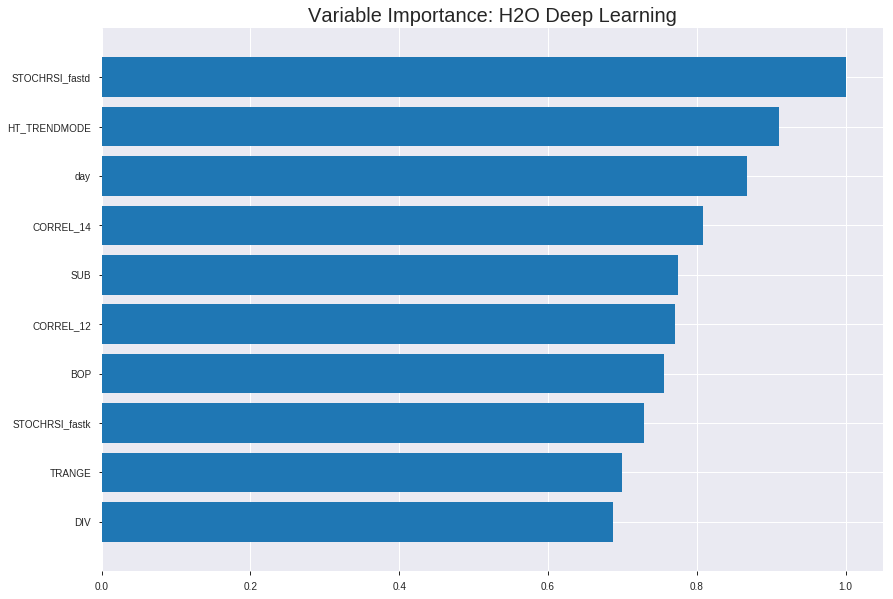

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_173035_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24270386701737318
RMSE: 0.4926498421976538
LogLoss: 0.6781595444567283
Mean Per-Class Error: 0.4315950899968932
AUC: 0.5911916738827231
pr_auc: 0.5947357510695209
Gini: 0.18238334776544618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4526045628689541: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    803   0.9926   (803.0/809.0)
1      2    746   0.0027   (2.0/748.0)
Total  8    1549  0.517    (805.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.452605     0.649543  394
max f2                       0.450753     0.822159  399
max f0point5                 0.459004     0.55536   355
max accuracy                 0.519841     0.581246  166
max precision                0.823108     1         0
max recall                   0.450753     1         399
max specificity              0.823108     1         0
max absolute_mcc             0.519841     0.182155  166
max min_per_class_accuracy   0.461996     0.563659  331
max mean_per_class_accuracy  0.519841     0.568405  166

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.695508           2.08155   2.08155            1                0.742621  1                           0.742621            0.0213904       0.0213904                  108.155   108.155
    2        0.0205523                   0.638469           1.56116   1.82136            0.75             0.667052  0.875                       0.704837            0.0160428       0.0374332                  56.1163   82.1357
    3        0.0301863                   0.615689           1.3877    1.68296            0.666667         0.626883  0.808511                    0.679958            0.013369        0.0508021                  38.7701   68.2956
    4        0.0404624                   0.598738           1.82136   1.71811            0.875            0.607017  0.825397                    0.661433            0.0187166       0.0695187                  82.1357   71.8105
    5        0.0500963                   0.58993            1.52647   1.68125            0.733333         0.595033  0.807692                    0.648664            0.0147059       0.0842246                  52.6471   68.1253
    6        0.100193                    0.55493            1.33433   1.50779            0.641026         0.570296  0.724359                    0.60948             0.0668449       0.15107                    33.4327   50.779
    7        0.150289                    0.526133           1.28095   1.43218            0.615385         0.53976   0.688034                    0.58624             0.0641711       0.215241                   28.0954   43.2178
    8        0.200385                    0.511511           1.01409   1.32766            0.487179         0.518314  0.637821                    0.569258            0.0508021       0.266043                   1.40889   32.7656
    9        0.299936                    0.489546           0.966914  1.20792            0.464516         0.499024  0.5803                      0.545947            0.0962567       0.362299                   -3.30861  20.7923
    10       0.400128                    0.473969           0.960716  1.14602            0.461538         0.48185   0.550562                    0.529897            0.0962567       0.458556                   -3.92842  14.6022
    11       0.500321                    0.461533           1.06746   1.13029            0.512821         0.467539  0.543004                    0.517409            0.106952        0.565508                   6.74619   13.029
    12       0.599872                    0.460444           0.940055  1.09872            0.451613         0.460675  0.527837                    0.507994            0.0935829       0.659091                   -5.99448  9.87201
    13       0.700064                    0.45982            0.747223  1.04841            0.358974         0.460187  0.50367                     0.501152            0.0748663       0.733957                   -25.2777  4.84141
    14       0.799615                    0.458767           1.1415    1.06               0.548387         0.459352  0.509237                    0.495948            0.113636        0.847594                   14.1496   6.00026
    15       0.899807                    0.457006           0.73388   1.02369            0.352564         0.45802   0.491792                    0.491725            0.0735294       0.921123                   -26.612   2.36892
    16       1                           0.450753           0.787253  1                  0.378205         0.455059  0.480411                    0.488051           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2478729123048249
RMSE: 0.49786836845176746
LogLoss: 0.6888275946370442
Mean Per-Class Error: 0.4522796352583587
AUC: 0.5241843971631206
pr_auc: 0.5083142486230396
Gini: 0.04836879432624119
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45195791235814453: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    210  0        (0.0/210.0)
Total  0    445  0.5281   (235.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451958     0.641221  399
max f2                       0.451958     0.817121  399
max f0point5                 0.451958     0.527638  399
max accuracy                 0.490875     0.564045  90
max precision                0.761997     1         0
max recall                   0.451958     1         399
max specificity              0.761997     1         0
max absolute_mcc             0.490875     0.117651  90
max min_per_class_accuracy   0.46059      0.523404  210
max mean_per_class_accuracy  0.490875     0.54772   90

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 48.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.648068           1.69524   1.69524            0.8              0.719146  0.8                         0.719146            0.0190476       0.0190476                  69.5238   69.5238
    2        0.0202247                   0.60828            0.529762  1.17725            0.25             0.627326  0.555556                    0.678337            0.0047619       0.0238095                  -47.0238  17.7249
    3        0.0314607                   0.5933             0.847619  1.05952            0.4              0.602949  0.5                         0.651413            0.00952381      0.0333333                  -15.2381  5.95238
    4        0.0404494                   0.573298           2.11905   1.29497            1                0.582472  0.611111                    0.636093            0.0190476       0.052381                   111.905   29.4974
    5        0.0516854                   0.562592           0.847619  1.19772            0.4              0.568803  0.565217                    0.621464            0.00952381      0.0619048                  -15.2381  19.7723
    6        0.101124                    0.536442           1.05952   1.13016            0.5              0.549113  0.533333                    0.586093            0.052381        0.114286                   5.95238   13.0159
    7        0.150562                    0.507232           1.34848   1.20185            0.636364         0.521487  0.567164                    0.564879            0.0666667       0.180952                   34.8485   20.1848
    8        0.2                         0.492385           1.25216   1.21429            0.590909         0.49911   0.573034                    0.548621            0.0619048       0.242857                   25.2165   21.4286
    9        0.301124                    0.477546           0.847619  1.09115            0.4              0.483802  0.514925                    0.526854            0.0857143       0.328571                   -15.2381  9.11514
    10       0.4                         0.46522            0.866883  1.03571            0.409091         0.471023  0.488764                    0.513053            0.0857143       0.414286                   -13.3117  3.57143
    11       0.501124                    0.460572           1.13016   1.05477            0.533333         0.461586  0.497758                    0.502667            0.114286        0.528571                   13.0159   5.47726
    12       0.6                         0.460078           0.770563  1.00794            0.363636         0.460346  0.475655                    0.495693            0.0761905       0.604762                   -22.9437  0.793651
    13       0.698876                    0.459322           1.01136   1.00842            0.477273         0.459755  0.475884                    0.490608            0.1             0.704762                   1.13636   0.842137
    14       0.8                         0.458424           0.894709  0.994048           0.422222         0.458914  0.469101                    0.486602            0.0904762       0.795238                   -10.5291  -0.595238
    15       0.898876                    0.456105           0.915043  0.985357           0.431818         0.457254  0.465                       0.483374            0.0904762       0.885714                   -8.49567  -1.46429
    16       1                           0.451958           1.13016   1                  0.533333         0.45453   0.47191                     0.480457    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:36:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:36:48  1 min 19.904 sec  550 obs/sec       0.701349  1             1092       0.512748         0.725963            -0.0532582     0.520245        0.515533           1.30097          0.51702                          0.518087           0.739914              -0.0770574       0.465127          0.440135             0                  0.525843
    2019-08-25 17:37:02  1 min 33.515 sec  835 obs/sec       7.6474    11            11907      0.500525         0.694206            -0.0036406     0.541933        0.529531           1.30097          0.509955                         0.500522           0.694221              -0.00526307      0.471003          0.451649             0.847619           0.516854
    2019-08-25 17:37:16  1 min 47.268 sec  931 obs/sec       15.9769   23            24876      0.498158         0.689461            0.00582896     0.558758        0.55983            1.43107          0.519589                         0.499549           0.692246              -0.00135602      0.482877          0.445305             0.847619           0.52809
    2019-08-25 17:37:29  2 min  0.689 sec  1002 obs/sec      24.9904   36            38910      0.49265          0.67816             0.0276921      0.591192        0.594736           2.08155          0.51702                          0.497868           0.688828              0.00536913       0.524184          0.508314             1.69524            0.52809
    2019-08-25 17:37:43  2 min 14.268 sec  1058 obs/sec      34.702    50            54031      0.488445         0.667587            0.0442181      0.593148        0.611892           2.08155          0.498394                         0.505048           0.707452              -0.0235231       0.516373          0.492929             1.27143            0.519101
    2019-08-25 17:37:56  2 min 27.935 sec  1089 obs/sec      44.3776   64            69096      0.486962         0.665038            0.0500136      0.606666        0.643969           2.08155          0.487476                         0.502124           0.701702              -0.0117067       0.494276          0.486803             1.27143            0.503371
    2019-08-25 17:37:58  2 min 29.292 sec  1088 obs/sec      44.3776   64            69096      0.49265          0.67816             0.0276921      0.591192        0.594736           2.08155          0.51702                          0.497868           0.688828              0.00536913       0.524184          0.508314             1.69524            0.52809

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
STOCHRSI_fastd     1.0                    1.0                  0.033759440761549006
HT_TRENDMODE       0.9104850888252258     0.9104850888252258   0.0307374674204689
day                0.8675968647003174     0.8675968647003174   0.029289584958756016
CORREL_14          0.8087008595466614     0.8087008595466614   0.02730128876167928
SUB                0.7751173377037048     0.7751173377037048   0.0261675278454578
---                ---                    ---                  ---
CDLONNECK          0.49447864294052124    0.49447864294052124  0.01669332245420167
CDLDRAGONFLYDOJI   0.4755401611328125     0.4755401611328125   0.016053969899500656
CDLINVERTEDHAMMER  0.471120148897171      0.471120148897171    0.015904752758266194
CDLHOMINGPIGEON    0.4701927900314331     0.4701927900314331   0.015873445641573617
CDLDARKCLOUDCOVER  0.4619559943675995     0.4619559943675995   0.015595376026295443


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.66875)

('auc', 0.5382882882882882)

('logloss', 0.6906287280521934)

('mean_per_class_error', 0.4258365508365509)

('rmse', 0.4987780889432658)

('mse', 0.2487795820098964)

deeplearning prediction progress: |███████████████████████████████████████| 100%


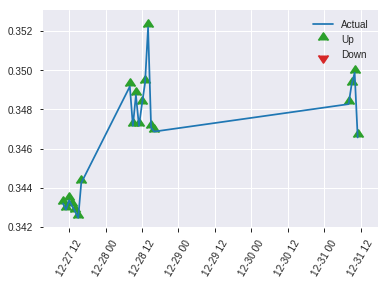


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2487795820098964
RMSE: 0.4987780889432658
LogLoss: 0.6906287280521934
Mean Per-Class Error: 0.4258365508365509
AUC: 0.5382882882882882
pr_auc: 0.5355217120714334
Gini: 0.07657657657657646
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.456252788749113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   102  0.9107   (102.0/112.0)
1      4    107  0.036    (4.0/111.0)
Total  14   209  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456253     0.66875   208
max f2                       0.453344     0.833333  221
max f0point5                 0.46246      0.575296  119
max accuracy                 0.463397     0.573991  117
max precision                0.722506     1         0
max recall                   0.453344     1         221
max specificity              0.722506     1         0
max absolute_mcc             0.46246      0.148758  119
max min_per_class_accuracy   0.465511     0.5625    111
max mean_per_class_accuracy  0.46246      0.574163  119

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 48.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.674571           1.33934   1.33934            0.666667         0.70131   0.666667                    0.70131             0.018018        0.018018                   33.9339   33.9339
    2        0.0224215                   0.655496           2.00901   1.60721            1                0.664959  0.8                         0.68677             0.018018        0.036036                   100.901   60.7207
    3        0.0313901                   0.641716           0         1.14801            0                0.647778  0.571429                    0.675629            0               0.036036                   -100      14.8005
    4        0.0403587                   0.612349           1.0045    1.11612            0.5              0.629512  0.555556                    0.665381            0.00900901      0.045045                   0.45045   11.6116
    5        0.0538117                   0.598854           1.33934   1.17192            0.666667         0.605185  0.583333                    0.650332            0.018018        0.0630631                  33.9339   17.1922
    6        0.103139                    0.549723           1.4611    1.31022            0.727273         0.563995  0.652174                    0.60904             0.0720721       0.135135                   46.1097   31.0223
    7        0.152466                    0.525701           1.09582   1.24086            0.545455         0.534759  0.617647                    0.585008            0.0540541       0.189189                   9.58231   24.0859
    8        0.201794                    0.50556            0.547912  1.07147            0.272727         0.51355   0.533333                    0.567541            0.027027        0.216216                   -45.2088  7.14715
    9        0.300448                    0.486097           0.913186  1.0195             0.454545         0.494102  0.507463                    0.543427            0.0900901       0.306306                   -8.68141  1.94971
    10       0.399103                    0.47441            0.821867  0.970645           0.409091         0.479735  0.483146                    0.527683            0.0810811       0.387387                   -17.8133  -2.93552
    11       0.502242                    0.465511           1.74696   1.13007            0.869565         0.47001   0.5625                      0.515839            0.18018         0.567568                   74.6964   13.0068
    12       0.600897                    0.46072            0.821867  1.07947            0.409091         0.462039  0.537313                    0.507006            0.0810811       0.648649                   -17.8133  7.94675
    13       0.699552                    0.459966           0.63923   1.01738            0.318182         0.460322  0.50641                     0.500423            0.0630631       0.711712                   -36.077   1.73828
    14       0.798206                    0.458705           1.0045    1.01579            0.5              0.459418  0.505618                    0.495355            0.0990991       0.810811                   0.45045   1.57911
    15       0.896861                    0.457003           1.0045    1.01455            0.5              0.45788   0.505                       0.491232            0.0990991       0.90991                    0.45045   1.45495
    16       1                           0.452156           0.873482  1                  0.434783         0.455313  0.497758                    0.487528        

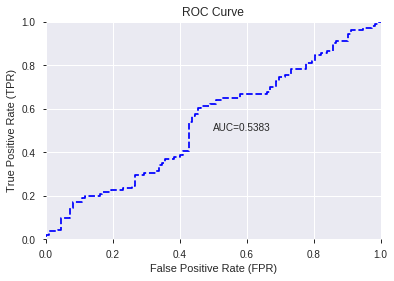

This function is available for GLM models only


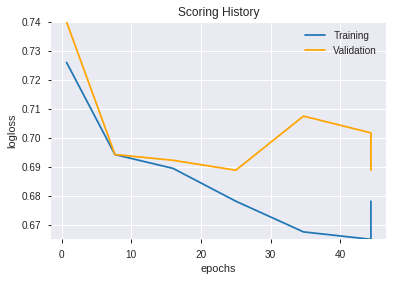

--2019-08-25 17:39:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_173035_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_173035_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastd',
 'HT_TRENDMODE',
 'day',
 'CORREL_14',
 'SUB',
 'CORREL_12',
 'BOP',
 'STOCHRSI_fastk',
 'TRANGE',
 'DIV',
 'hour',
 'CDLRICKSHAWMAN',
 'CDLSPINNINGTOP',
 'is_month_start',
 'CORREL_8',
 'CORREL_20',
 'CDLDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLDOJI',
 'CDLHARAMICROSS',
 'CDLLONGLEGGEDDOJI',
 'CDLSEPARATINGLINES',
 'CDLEVENINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDL3INSIDE',
 'CDLXSIDEGAP3METHODS',
 'CDLMATCHINGLOW',
 'CDLPIERCING',
 'CDLMORNINGSTAR',
 'CDLHAMMER',
 'is_month_end',
 'CDLADVANCEBLOCK',
 'CDL3LINESTRIKE',
 'CDLMORNINGDOJISTAR',
 'CDLHANGINGMAN',
 'CDLIDENTICAL3CROWS',
 'CDLRISEFALL3METHODS',
 'CDLHIKKAKEMOD',
 'CDLSTICKSANDWICH',
 'CDLTAKURI',
 'CDLONNECK',
 'CDLDRAGONFLYDOJI',
 'CDLINVERTEDHAMMER',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_173923_model_1  0.515364  0.690246              0.495536  0.498563  0.248565

variable  relative_importance  scaled_importance  percentage
0   CDLGAPSIDESIDEWHITE             0.032825           1.000000    0.044283
1    CDLSEPARATINGLINES             0.032169           0.980028    0.043399
2        CDL3LINESTRIKE             0.030526           0.929982    0.041182
3       CDLADVANCEBLOCK             0.028554           0.869894    0.038522
4       CDLSHOOTINGSTAR             0.026985           0.822093    0.036405
5        STOCHRSI_fastd             0.026819           0.817041    0.036181
6                   SUB             0.025329           0.771657    0.034171
7              CORREL_8             0.023580           0.718370    0.031812
8          HT_TRENDMODE             0.023468           0.714959    0.031661
9         CDLHIKKAKEMOD             0.021692           0.660841    0.029264
10    CDLINVERTEDHAMMER             0.021174           0.645066    0.028565
11       CDLRICKSHAWMAN             0.020577           0.626867    0.027760
12                  BOP             0.020347           0.619864    0.027450
13     CDLSTICKSANDWICH             0.020267           0.617423    0.027341
14    CDLSTALLEDPATTERN             0.020007           0.609499    0.026990
15                  DIV             0.019920           0.606852    0.026873
16       CDLSPINNINGTOP             0.019624           0.597851    0.026475
17  CDLRISEFALL3METHODS             0.019164           0.583818    0.025853
18   CDLIDENTICAL3CROWS             0.019139           0.583062    0.025820
19   CDLEVENINGDOJISTAR             0.018881           0.575216    0.025472
20            CDLONNECK             0.018678           0.569025    0.025198
21          CDLDOJISTAR             0.018523           0.564294    0.024989
22       is_month_start             0.018013           0.548761    0.024301
23          CDLPIERCING             0.017684           0.538727    0.023857
24            CDLTAKURI             0.017507           0.533358    0.023619
25       CDLHARAMICROSS             0.017258           0.525754    0.023282
26            CDLHAMMER             0.015897           0.484291    0.021446
27               TRANGE             0.015507           0.472410    0.020920
28            CORREL_14             0.015112           0.460380    0.020387
29       CDLMORNINGSTAR             0.014425           0.439448    0.019460
30     CDLDRAGONFLYDOJI             0.011902           0.362585    0.016056
31         CDLTHRUSTING             0.010548           0.321338    0.014230
32    CDLGRAVESTONEDOJI             0.008175           0.249039    0.011028
33           CDL3INSIDE             0.007431           0.226378    0.010025
34            CORREL_12             0.007204           0.219459    0.009718
35                  day             0.006453           0.196589    0.008706
36       CDLMATCHINGLOW             0.006104           0.185972    0.008235
37              CDLDOJI             0.005758           0.175408    0.007768
38    CDLLONGLEGGEDDOJI             0.005750           0.175164    0.007757
39       CDLEVENINGSTAR             0.005578           0.169946    0.007526
40       STOCHRSI_fastk             0.004993           0.152115    0.006736
41                 hour             0.004782           0.145698    0.006452
42   CDLMORNINGDOJISTAR             0.003806           0.115936    0.005134
43      CDLHOMINGPIGEON             0.003344           0.101874    0.004511
44         is_month_end             0.003212           0.097848    0.004333
45        CDLHANGINGMAN             0.002261           0.068894    0.003051
46    CDLDARKCLOUDCOVER             0.001767           0.053821    0.002383
47    CDL3WHITESOLDIERS             0.001320           0.040207    0.001780
48  CDLXSIDEGAP3METHODS             0.000858           0.026128    0.001157
49            CORREL_20             0.000353           0.010759    0.000476

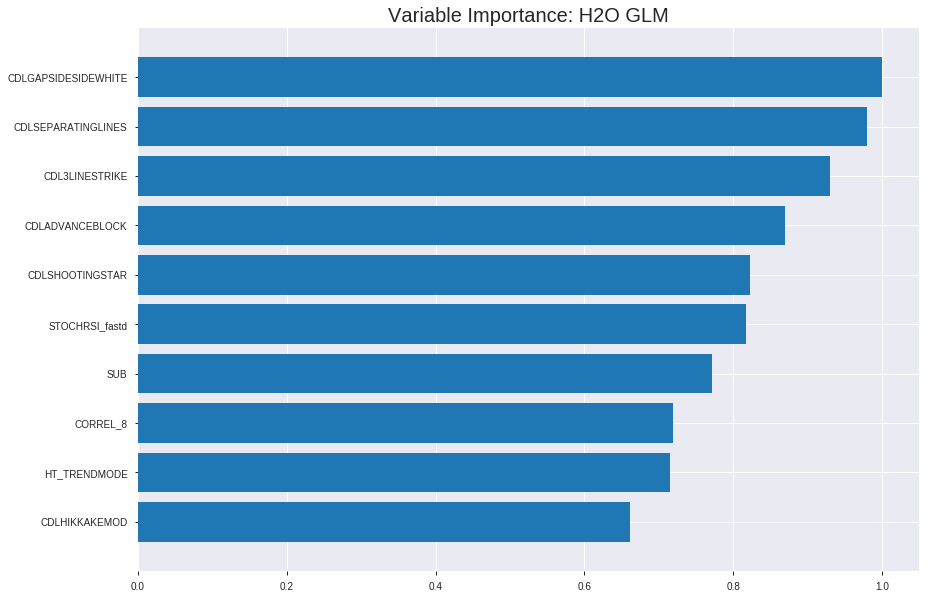

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_173923_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24539028272554117
RMSE: 0.49536883503662316
LogLoss: 0.6837516615563505
Null degrees of freedom: 1556
Residual degrees of freedom: 1506
Null deviance: 2156.0698562406105
Residual deviance: 2129.2026740864753
AIC: 2231.2026740864753
AUC: 0.5832793506210215
pr_auc: 0.5732612744240942
Gini: 0.16655870124204308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42081951935910283: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      47   762   0.9419   (762.0/809.0)
1      15   733   0.0201   (15.0/748.0)
Total  62   1495  0.499    (777.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42082      0.653589  356
max f2                       0.352358     0.824152  390
max f0point5                 0.484329     0.559066  181
max accuracy                 0.489981     0.583815  155
max precision                0.6775       1         0
max recall                   0.352358     1         390
max specificity              0.6775       1         0
max absolute_mcc             0.489981     0.16348   155
max min_per_class_accuracy   0.483132     0.557487  187
max mean_per_class_accuracy  0.488519     0.579143  163

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.583561           1.82136   1.82136            0.875            0.619556  0.875                       0.619556            0.0187166       0.0187166                  82.1357   82.1357
    2        0.0205523                   0.549399           1.69126   1.75631            0.8125           0.568774  0.84375                     0.594165            0.0173797       0.0360963                  69.126    75.6308
    3        0.0301863                   0.529752           1.3877    1.63867            0.666667         0.538518  0.787234                    0.576405            0.013369        0.0494652                  38.7701   63.8668
    4        0.0404624                   0.523164           1.56116   1.61898            0.75             0.525937  0.777778                    0.563588            0.0160428       0.065508                   56.1163   61.8984
    5        0.0500963                   0.518149           0.69385   1.44107            0.333333         0.520832  0.692308                    0.555366            0.00668449      0.0721925                  -30.615   44.1074
    6        0.100193                    0.506292           1.20089   1.32098            0.576923         0.511411  0.634615                    0.533388            0.0601604       0.132353                   20.0895   32.0984
    7        0.150289                    0.501046           1.20089   1.28095            0.576923         0.503362  0.615385                    0.52338             0.0601604       0.192513                   20.0895   28.0954
    8        0.200385                    0.497516           1.06746   1.22758            0.512821         0.499451  0.589744                    0.517398            0.0534759       0.245989                   6.74619   22.7581
    9        0.299936                    0.491899           1.22207   1.22575            0.587097         0.494451  0.588865                    0.509782            0.121658        0.367647                   22.2072   22.5753
    10       0.400128                    0.487384           1.06746   1.18612            0.512821         0.489756  0.569823                    0.504767            0.106952        0.474599                   6.74619   18.6116
    11       0.500321                    0.48289            0.85397   1.1196             0.410256         0.484952  0.537869                    0.500799            0.0855615       0.56016                    -14.603   11.9602
    12       0.599872                    0.477899           0.872908  1.07866            0.419355         0.480519  0.518201                    0.497434            0.0868984       0.647059                   -12.7092  7.86623
    13       0.700064                    0.471933           0.893999  1.05223            0.429487         0.47497   0.505505                    0.494219            0.0895722       0.736631                   -10.6001  5.22335
    14       0.799615                    0.464655           0.84605   1.02656            0.406452         0.468555  0.493173                    0.491024            0.0842246       0.820856                   -15.395   2.6564
    15       0.899807                    0.448552           0.960716  1.01923            0.461538         0.457976  0.48965                     0.487344            0.0962567       0.917112                   -3.92842  1.92319
    16       1                           0.194846           0.827283  1                  0.397436         0.418151  0.480411                    0.480411          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2485875919249641
RMSE: 0.4985855913732005
LogLoss: 0.6902841387136561
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 615.6246511654862
Residual deviance: 614.3528834551539
AIC: 716.3528834551539
AUC: 0.5078824721377913
pr_auc: 0.503358380793146
Gini: 0.015764944275582504
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3979661498158949: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    228  0.9702   (228.0/235.0)
1      1    209  0.0048   (1.0/210.0)
Total  8    437  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397966     0.646059  391
max f2                       0.397966     0.818324  391
max f0point5                 0.397966     0.533708  391
max accuracy                 0.519876     0.552809  21
max precision                0.670309     1         0
max recall                   0.312139     1         398
max specificity              0.670309     1         0
max absolute_mcc             0.519876     0.124967  21
max min_per_class_accuracy   0.47477      0.514894  194
max mean_per_class_accuracy  0.519876     0.52771   21

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 47.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.577274           1.69524   1.69524            0.8              0.599033  0.8                         0.599033            0.0190476       0.0190476                  69.5238   69.5238
    2        0.0202247                   0.553051           1.58929   1.64815            0.75             0.567517  0.777778                    0.585026            0.0142857       0.0333333                  58.9286   64.8148
    3        0.0314607                   0.524088           1.27143   1.51361            0.6              0.531033  0.714286                    0.565743            0.0142857       0.047619                   27.1429   51.3605
    4        0.0404494                   0.520829           1.58929   1.53042            0.75             0.522838  0.722222                    0.556208            0.0142857       0.0619048                  58.9286   53.0423
    5        0.0516854                   0.519586           1.69524   1.56625            0.8              0.520545  0.73913                     0.548456            0.0190476       0.0809524                  69.5238   56.6253
    6        0.101124                    0.503385           0.674242  1.13016            0.318182         0.508956  0.533333                    0.529145            0.0333333       0.114286                   -32.5758  13.0159
    7        0.150562                    0.496948           0.770563  1.01208            0.363636         0.500122  0.477612                    0.519615            0.0380952       0.152381                   -22.9437  1.20824
    8        0.2                         0.492547           0.866883  0.97619            0.409091         0.494471  0.460674                    0.5134              0.0428571       0.195238                   -13.3117  -2.38095
    9        0.301124                    0.484683           1.27143   1.07534            0.6              0.488366  0.507463                    0.504993            0.128571        0.32381                    27.1429   7.53376
    10       0.4                         0.480412           0.915043  1.03571            0.431818         0.482542  0.488764                    0.499443            0.0904762       0.414286                   -8.49567  3.57143
    11       0.501124                    0.47477            1.03598   1.03577            0.488889         0.477824  0.488789                    0.495081            0.104762        0.519048                   3.59788   3.57677
    12       0.6                         0.468525           0.626082  0.968254           0.295455         0.471948  0.456929                    0.491269            0.0619048       0.580952                   -37.3918  -3.1746
    13       0.698876                    0.461941           0.915043  0.960726           0.431818         0.465794  0.453376                    0.487664            0.0904762       0.671429                   -8.49567  -3.92742
    14       0.8                         0.451078           1.22434   0.994048           0.577778         0.456727  0.469101                    0.483754            0.12381         0.795238                   22.4339   -0.595238
    15       0.898876                    0.434812           1.01136   0.995952           0.477273         0.444155  0.47                        0.479398            0.1             0.895238                   1.13636   -0.404762
    16       1                           0.285718           1.03598   1                  0.488889         0.41212   0.47191                     0.472595   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 17:39:23  0.000 sec   2            2.9       51            1.37991           1.38207
    2019-08-25 17:39:23  0.006 sec   4            1.8       51            1.37768           1.38158
    2019-08-25 17:39:23  0.011 sec   6            1.1       51            1.37479           1.38109
    2019-08-25 17:39:23  0.016 sec   8            0.69      51            1.37133           1.3807
    2019-08-25 17:39:23  0.021 sec   10           0.43      51            1.3675            1.38057
    2019-08-25 17:39:23  0.026 sec   12           0.27      51            1.36367           1.38088
    2019-08-25 17:39:23  0.032 sec   14           0.16      51            1.3602            1.38175
    2019-08-25 17:39:23  0.037 sec   16           0.1       51            1.35735           1.38316
    2019-08-25 17:39:23  0.043 sec   18           0.064     51            1.35519           1.38498
    2019-08-25 17:39:23  0.048 sec   20           0.039     51            1.35362           1.38701

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6666666666666666)

('auc', 0.5153635778635779)

('logloss', 0.690246321367941)

('mean_per_class_error', 0.4588561776061776)

('rmse', 0.49856262430930914)

('mse', 0.24856469035818532)

glm prediction progress: |████████████████████████████████████████████████| 100%


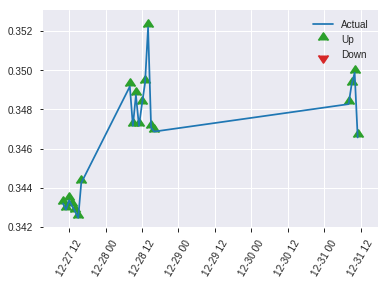


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24856469035818532
RMSE: 0.49856262430930914
LogLoss: 0.690246321367941
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.40779410652675
Residual deviance: 307.8498593301017
AIC: 409.8498593301017
AUC: 0.5153635778635779
pr_auc: 0.5475949867890444
Gini: 0.030727155727155786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4023056591185263: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    111  0        (0.0/111.0)
Total  1    222  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402306     0.666667  221
max f2                       0.402306     0.833333  221
max f0point5                 0.433329     0.556691  216
max accuracy                 0.498599     0.542601  34
max precision                0.610512     1         0
max recall                   0.402306     1         221
max specificity              0.610512     1         0
max absolute_mcc             0.554101     0.152126  4
max min_per_class_accuracy   0.477941     0.504505  110
max mean_per_class_accuracy  0.49675      0.541144  38

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 47.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.578951           2.00901   2.00901            1                0.592302  1                           0.592302            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.549898           2.00901   2.00901            1                0.562522  1                           0.58039             0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.543181           1.0045    1.72201            0.5              0.5442    0.857143                    0.57005             0.00900901      0.0540541                  0.45045   72.2008
    4        0.0403587                   0.537711           1.0045    1.56256            0.5              0.541309  0.777778                    0.563663            0.00900901      0.0630631                  0.45045   56.2563
    5        0.0538117                   0.531597           1.33934   1.50676            0.666667         0.534929  0.75                        0.55648             0.018018        0.0810811                  33.9339   50.6757
    6        0.103139                    0.510888           1.09582   1.31022            0.545455         0.51913   0.652174                    0.538617            0.0540541       0.135135                   9.58231   31.0223
    7        0.152466                    0.498652           1.09582   1.24086            0.545455         0.502356  0.617647                    0.526885            0.0540541       0.189189                   9.58231   24.0859
    8        0.201794                    0.49396            0.913186  1.16076            0.454545         0.496261  0.577778                    0.519399            0.045045        0.234234                   -8.68141  16.0761
    9        0.300448                    0.486046           0.730549  1.0195             0.363636         0.489324  0.507463                    0.509524            0.0720721       0.306306                   -26.9451  1.94971
    10       0.399103                    0.481994           0.821867  0.970645           0.409091         0.48399   0.483146                    0.503212            0.0810811       0.387387                   -17.8133  -2.93552
    11       0.502242                    0.477915           1.13553   1.0045             0.565217         0.479932  0.5                         0.498431            0.117117        0.504505                   13.5527   0.45045
    12       0.600897                    0.472319           1.27846   1.04948            0.636364         0.475202  0.522388                    0.494618            0.126126        0.630631                   27.846    4.94823
    13       0.699552                    0.466789           0.63923   0.991626           0.318182         0.469304  0.49359                     0.491048            0.0630631       0.693694                   -36.077   -0.837376
    14       0.798206                    0.458317           0.821867  0.970645           0.409091         0.463775  0.483146                    0.487677            0.0810811       0.774775                   -17.8133  -2.93552
    15       0.896861                    0.44782            1.27846   1.0045             0.636364         0.454054  0.5                         0.483978            0.126126        0.900901                   27.846    0.45045
    16       1                           0.377455           0.96083   1                  0.478261         0.431855  0.497758                    0.478602     

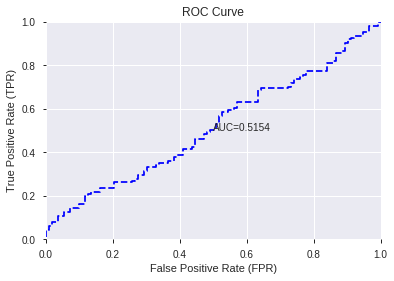

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


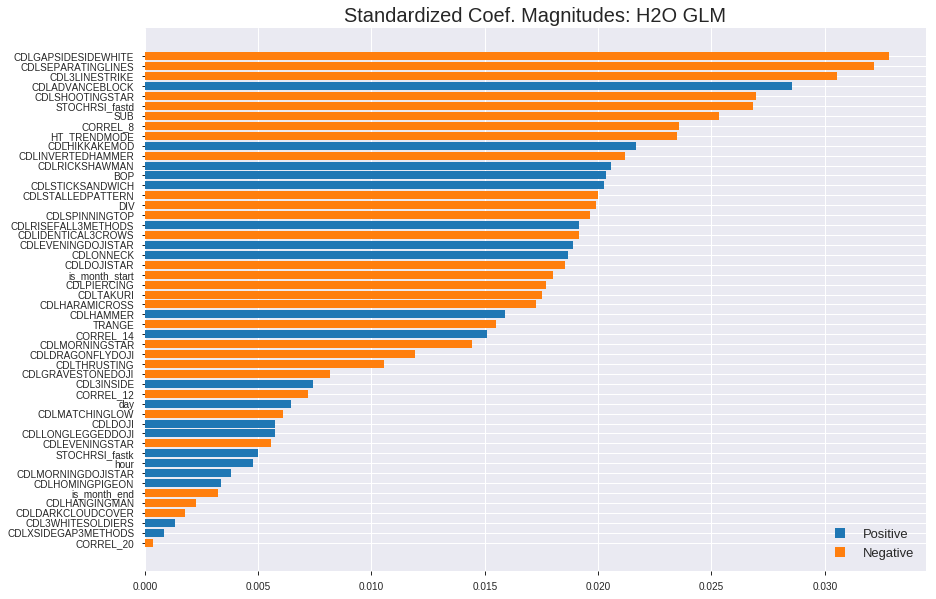

'log_likelihood'
--2019-08-25 17:39:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_173923_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_173923_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLGAPSIDESIDEWHITE',
 'CDLSEPARATINGLINES',
 'CDL3LINESTRIKE',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'STOCHRSI_fastd',
 'SUB',
 'CORREL_8',
 'HT_TRENDMODE',
 'CDLHIKKAKEMOD',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'BOP',
 'CDLSTICKSANDWICH',
 'CDLSTALLEDPATTERN',
 'DIV',
 'CDLSPINNINGTOP',
 'CDLRISEFALL3METHODS',
 'CDLIDENTICAL3CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLDOJISTAR',
 'is_month_start',
 'CDLPIERCING',
 'CDLTAKURI',
 'CDLHARAMICROSS',
 'CDLHAMMER',
 'TRANGE',
 'CORREL_14',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLTHRUSTING',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CORREL_12',
 'day',
 'CDLMATCHINGLOW',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLEVENINGSTAR',
 'STOCHRSI_fastk',
 'hour',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLXSIDEGAP3METHODS',
 'CORREL_20']

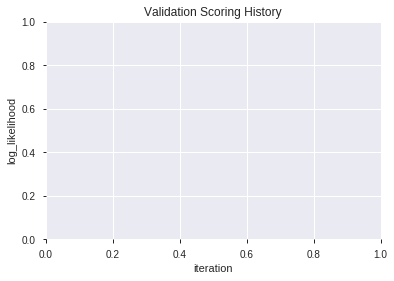

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_173934_model_5  0.531773  0.717875              0.491112  0.510817  0.260934
1  XGBoost_grid_1_AutoML_20190825_173934_model_1  0.512146  0.716108              0.500000  0.510604  0.260717
2               XGBoost_3_AutoML_20190825_173934  0.507561  0.703739              0.500000  0.505004  0.255029
3               XGBoost_1_AutoML_20190825_173934  0.505711  0.711902              0.491112  0.508902  0.258981
4  XGBoost_grid_1_AutoML_20190825_173934_model_6  0.501207  0.709575              0.500000  0.507601  0.257659
5  XGBoost_grid_1_AutoML_20190825_173934_model_7  0.499839  0.717807              0.495536  0.511416  0.261546
6  XGBoost_grid_1_AutoML_20190825_173934_model_3  0.495817  0.712146              0.495536  0.508870  0.258949
7  XGBoost_grid_1_AutoML_20190825_173934_model_4  0.477558  0.707573              0.495536  0.507039  0.257089
8  XGBoost_grid_1_AutoML_20190825_173934_model_2  0.475788  0.705659              0.500000  0.506091  0.256129
9               XGBoost_2_AutoML_20190825_173934  0.475788  0.713645              0.500000  0.509829  0.259926

variable  relative_importance  scaled_importance  percentage
0                   BOP          2436.767090           1.000000    0.121166
1                   DIV          2106.081543           0.864293    0.104723
2                TRANGE          2099.465576           0.861578    0.104394
3        STOCHRSI_fastd          1977.040771           0.811338    0.098306
4             CORREL_20          1855.247314           0.761356    0.092250
5                   day          1786.023438           0.732948    0.088808
6        STOCHRSI_fastk          1474.646240           0.605165    0.073325
7             CORREL_14          1406.038086           0.577010    0.069914
8                  hour          1172.608032           0.481215    0.058307
9                   SUB          1164.213745           0.477770    0.057889
10            CORREL_12           766.708008           0.314641    0.038124
11             CORREL_8           574.233337           0.235654    0.028553
12         HT_TRENDMODE           260.976440           0.107099    0.012977
13       CDLSPINNINGTOP           209.020340           0.085778    0.010393
14              CDLDOJI           132.493896           0.054373    0.006588
15       CDLRICKSHAWMAN            70.875183           0.029086    0.003524
16    CDLGRAVESTONEDOJI            62.301731           0.025567    0.003098
17            CDLHAMMER            52.394432           0.021502    0.002605
18         is_month_end            48.168102           0.019767    0.002395
19          CDLDOJISTAR            46.850609           0.019227    0.002330
20      CDLADVANCEBLOCK            45.155235           0.018531    0.002245
21     CDLDRAGONFLYDOJI            45.152485           0.018530    0.002245
22    CDLLONGLEGGEDDOJI            43.936687           0.018031    0.002185
23       CDLMATCHINGLOW            43.214867           0.017735    0.002149
24       is_month_start            43.134022           0.017701    0.002145
25   CDLSEPARATINGLINES            23.383581           0.009596    0.001163
26  CDLXSIDEGAP3METHODS            19.333775           0.007934    0.000961
27        CDLHANGINGMAN            17.984324           0.007380    0.000894
28           CDL3INSIDE            15.676697           0.006433    0.000780
29       CDLMORNINGSTAR            12.728130           0.005223    0.000633
30    CDLSTALLEDPATTERN            12.185918           0.005001    0.000606
31            CDLTAKURI            11.261191           0.004621    0.000560
32    CDLINVERTEDHAMMER             9.786203           0.004016    0.000487
33      CDLSHOOTINGSTAR             9.289316           0.003812    0.000462
34        CDLHIKKAKEMOD             9.270539           0.003804    0.000461
35       CDLHARAMICROSS             7.371815           0.003025    0.000367
36       CDLEVENINGSTAR             6.891404           0.002828    0.000343
37    CDL3WHITESOLDIERS             6.524768           0.002678    0.000324
38       CDL3LINESTRIKE             6.312667           0.002591    0.000314
39  CDLGAPSIDESIDEWHITE             6.211303           0.002549    0.000309
40         CDLTHRUSTING             5.537000           0.002272    0.000275
41   CDLIDENTICAL3CROWS             2.901987           0.001191    0.000144
42   CDLMORNINGDOJISTAR             2.527790           0.001037    0.000126
43            CDLONNECK             1.744452           0.000716    0.000087
44     CDLSTICKSANDWICH             1.388690           0.000570    0.000069

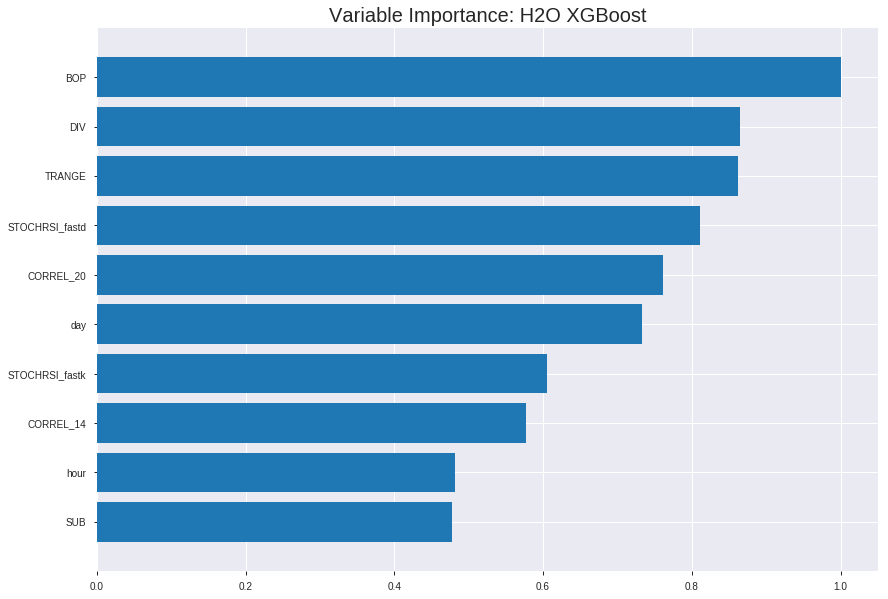

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_173934_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06451401401954833
RMSE: 0.253996090559576
LogLoss: 0.28506493137872835
Mean Per-Class Error: 0.0006180469715698633
AUC: 0.999992563605957
pr_auc: 0.9986550455779724
Gini: 0.999985127211914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.51241534948349: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      808  1    0.0012   (1.0/809.0)
1      0    748  0        (0.0/748.0)
Total  808  749  0.0006   (1.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512415     0.999332  197
max f2                       0.512415     0.999733  197
max f0point5                 0.512415     0.998932  197
max accuracy                 0.512415     0.999358  197
max precision                0.885077     1         0
max recall                   0.512415     1         197
max specificity              0.885077     1         0
max absolute_mcc             0.512415     0.998714  197
max min_per_class_accuracy   0.512415     0.998764  197
max mean_per_class_accuracy  0.512415     0.999382  197

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.18 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0102762                   0.864877           2.08155  2.08155            1                0.872711  1                           0.872711            0.0213904       0.0213904                  108.155  108.155
    2        0.0205523                   0.850016           2.08155  2.08155            1                0.858117  1                           0.865414            0.0213904       0.0427807                  108.155  108.155
    3        0.0301863                   0.838394           2.08155  2.08155            1                0.842955  1                           0.858246            0.0200535       0.0628342                  108.155  108.155
    4        0.0404624                   0.833681           2.08155  2.08155            1                0.836357  1                           0.852687            0.0213904       0.0842246                  108.155  108.155
    5        0.0500963                   0.82801            2.08155  2.08155            1                0.830927  1                           0.848502            0.0200535       0.104278                   108.155  108.155
    6        0.100193                    0.804643           2.08155  2.08155            1                0.814446  1                           0.831474            0.104278        0.208556                   108.155  108.155
    7        0.150289                    0.785784           2.08155  2.08155            1                0.796007  1                           0.819652            0.104278        0.312834                   108.155  108.155
    8        0.200385                    0.767382           2.08155  2.08155            1                0.776698  1                           0.808914            0.104278        0.417112                   108.155  108.155
    9        0.299936                    0.730751           2.08155  2.08155            1                0.750097  1                           0.789392            0.207219        0.624332                   108.155  108.155
    10       0.400128                    0.678709           2.08155  2.08155            1                0.707632  1                           0.768919            0.208556        0.832888                   108.155  108.155
    11       0.500321                    0.369043           1.66791  1.99872            0.801282         0.590118  0.960205                    0.733113            0.167112        1                          66.7909  99.8716
    12       0.599872                    0.280549           0        1.66702            0                0.313214  0.800857                    0.66343             0               1                          -100     66.7024
    13       0.700064                    0.245129           0        1.42844            0                0.262548  0.686239                    0.606056            0               1                          -100     42.844
    14       0.799615                    0.211675           0        1.2506             0                0.227542  0.600803                    0.558932            0               1                          -100     25.0602
    15       0.899807                    0.177546           0        1.11135            0                0.19485   0.533904                    0.518391            0               1                          -100     11.1349
    16       1                           0.0893693          0        1                  0                0.153382  0.480411                    0.48182             0               1                



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2707894508302484
RMSE: 0.5203743372133646
LogLoss: 0.7404211179390651
Mean Per-Class Error: 0.481306990881459
AUC: 0.4939716312056737
pr_auc: 0.4551526785083945
Gini: -0.012056737588652555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16029100120067596: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    210  0        (0.0/210.0)
Total  0    445  0.5281   (235.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.160291     0.641221  399
max f2                       0.160291     0.817121  399
max f0point5                 0.329428     0.530127  339
max accuracy                 0.603143     0.530337  83
max precision                0.603143     0.505495  83
max recall                   0.160291     1         399
max specificity              0.834118     0.995745  0
max absolute_mcc             0.759564     0.100771  4
max min_per_class_accuracy   0.473754     0.485106  208
max mean_per_class_accuracy  0.329428     0.518693  339

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 47.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.758803           0         0                  0                0.787933  0                           0.787933            0               0                          -100      -100
    2        0.0202247                   0.749254           1.58929   0.706349           0.75             0.754814  0.333333                    0.773214            0.0142857       0.0142857                  58.9286   -29.3651
    3        0.0314607                   0.734676           0.42381   0.605442           0.2              0.74442   0.285714                    0.76293             0.0047619       0.0190476                  -57.619   -39.4558
    4        0.0404494                   0.710115           1.05952   0.706349           0.5              0.718812  0.333333                    0.753126            0.00952381      0.0285714                  5.95238   -29.3651
    5        0.0516854                   0.697427           0.847619  0.73706            0.4              0.703417  0.347826                    0.74232             0.00952381      0.0380952                  -15.2381  -26.294
    6        0.101124                    0.664316           0.866883  0.800529           0.409091         0.675782  0.377778                    0.70979             0.0428571       0.0809524                  -13.3117  -19.9471
    7        0.150562                    0.625148           1.05952   0.885572           0.5              0.642207  0.41791                     0.687599            0.052381        0.133333                   5.95238   -11.4428
    8        0.2                         0.603513           1.54113   1.04762            0.727273         0.61258   0.494382                    0.669055            0.0761905       0.209524                   54.1126   4.7619
    9        0.301124                    0.553907           1.03598   1.04371            0.488889         0.577866  0.492537                    0.638432            0.104762        0.314286                   3.59788   4.371
    10       0.4                         0.519677           0.866883  1                  0.409091         0.535734  0.47191                     0.613046            0.0857143       0.4                        -13.3117  0
    11       0.501124                    0.473754           0.847619  0.96925            0.4              0.499424  0.457399                    0.590118            0.0857143       0.485714                   -15.2381  -3.07495
    12       0.6                         0.431391           0.963203  0.968254           0.454545         0.453986  0.456929                    0.567684            0.0952381       0.580952                   -3.67965  -3.1746
    13       0.698876                    0.399192           1.15584   0.994794           0.545455         0.41762   0.469453                    0.546453            0.114286        0.695238                   15.5844   -0.520594
    14       0.8                         0.357566           1.13016   1.0119             0.533333         0.378395  0.477528                    0.52521             0.114286        0.809524                   13.0159   1.19048
    15       0.898876                    0.302987           0.963203  1.00655            0.454545         0.329392  0.475                       0.50367             0.0952381       0.904762                   -3.67965  0.654762
    16       1                           0.160291           0.941799  1                  0.444444         0.241738  0.47191                     0.477182            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:39:40  2.358 sec   0                  0.5              0.693147            0.5             0                  1                0.519589                         0.5                0.693147              0.5               0                    1                  0.52809
    2019-08-25 17:39:40  2.619 sec   5                  0.458824         0.613694            0.951282        0.948746           2.08155          0.118176                         0.50242            0.698064              0.491966          0.463359             0.847619           0.52809
    2019-08-25 17:39:40  2.861 sec   10                 0.426473         0.554892            0.986076        0.98433            2.08155          0.0526654                        0.5008             0.694791              0.515441          0.481554             1.27143            0.489888
    2019-08-25 17:39:40  3.081 sec   15                 0.410925         0.52728             0.991903        0.987227           2.08155          0.0423892                        0.50188            0.697238              0.524043          0.479808             1.27143            0.52809
    2019-08-25 17:39:41  3.331 sec   20                 0.408696         0.522684            0.99278         0.991139           2.08155          0.0398202                        0.500321           0.693839              0.52382           0.494717             1.69524            0.523596
    2019-08-25 17:39:41  3.534 sec   25                 0.383593         0.479629            0.996435        0.994885           2.08155          0.0282595                        0.509418           0.713123              0.486849          0.456941             1.27143            0.516854
    2019-08-25 17:39:41  3.778 sec   30                 0.346956         0.420538            0.999189        0.997813           2.08155          0.012203                         0.514607           0.725475              0.492827          0.459696             1.27143            0.52809
    2019-08-25 17:39:41  4.043 sec   35                 0.298997         0.349104            0.999895        0.998548           2.08155          0.0032113                        0.515261           0.72741               0.496778          0.459135             0.847619           0.52809
    2019-08-25 17:39:41  4.263 sec   40                 0.285165         0.328941            0.999933        0.997253           2.08155          0.00256904                       0.517818           0.733667              0.493668          0.453722             0.42381            0.52809
    2019-08-25 17:39:42  4.526 sec   45                 0.269195         0.3061              0.999952        0.998611           2.08155          0.00192678                       0.518812           0.736349              0.494184          0.455775             0.847619           0.52809
    2019-08-25 17:39:42  4.857 sec   50                 0.253996         0.285065            0.999993        0.998655           2.08155          0.000642261                      0.520374           0.740421              0.493972          0.455153             0                  0.52809

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2436.76708984375       1.0                    0.12116552981062761
DIV                 2106.08154296875       0.8642933301860195     0.10472255926378077
TRANGE              2099.465576171875      0.8615782710306124     0.10439358768274866
STOCHRSI_fastd      1977.040771484375      0.8113376037145784     0.09830615060936193
CORREL_20           1855.247314453125      0.7613560287257848     0.09225010659507513
---                 ---                    ---                    ---
CDLTHRUSTING        5.536999702453613      0.0022722728509964635  0.0002753211438652918
CDLIDENTICAL3CROWS  2.901986598968506      0.0011909166908334217  0.00014429805180515094
CDLMORNINGDOJISTAR  2.527790069580078      0.0010373539925566562  0.0001256915461092971
CDLONNECK           1.7444515228271484     0.0007158876735071984  8.674090924539729e-05
CDLSTICKSANDWICH    1.3886899948120117     0.0005698903274752685  6.905106346249298e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6666666666666666)

('auc', 0.5317728442728443)

('logloss', 0.7178749865909949)

('mean_per_class_error', 0.4572072072072072)

('rmse', 0.5108168755260099)

('mse', 0.26093388032215503)

xgboost prediction progress: |████████████████████████████████████████████| 100%


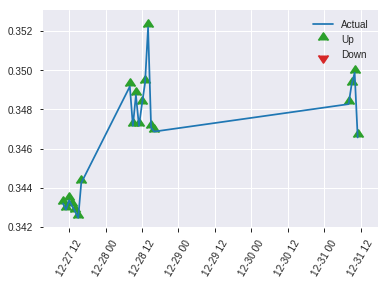


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26093388032215503
RMSE: 0.5108168755260099
LogLoss: 0.7178749865909949
Mean Per-Class Error: 0.4572072072072072
AUC: 0.5317728442728443
pr_auc: 0.510507855907068
Gini: 0.06354568854568865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23875603079795837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    109  0.9732   (109.0/112.0)
1      1    110  0.009    (1.0/111.0)
Total  4    219  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238756     0.666667  218
max f2                       0.182115     0.832084  222
max f0point5                 0.270421     0.558428  213
max accuracy                 0.481353     0.542601  96
max precision                0.610493     0.6       34
max recall                   0.182115     1         222
max specificity              0.761437     0.991071  0
max absolute_mcc             0.699417     0.150768  4
max min_per_class_accuracy   0.459171     0.526786  111
max mean_per_class_accuracy  0.448874     0.542793  120

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 46.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.727165           0         0                  0                0.74626   0                           0.74626             0               0                          -100      -100
    2        0.0224215                   0.698434           0         0                  0                0.701787  0                           0.728471            0               0                          -100      -100
    3        0.0313901                   0.691724           1.0045    0.287001           0.5              0.696798  0.142857                    0.719421            0.00900901      0.00900901                 0.45045   -71.2999
    4        0.0403587                   0.683962           2.00901   0.66967            1                0.687619  0.333333                    0.712354            0.018018        0.027027                   100.901   -33.033
    5        0.0538117                   0.676819           1.33934   0.837087           0.666667         0.680395  0.416667                    0.704364            0.018018        0.045045                   33.9339   -16.2913
    6        0.103139                    0.635712           1.27846   1.04818            0.636364         0.653352  0.521739                    0.679967            0.0630631       0.108108                   27.846    4.81786
    7        0.152466                    0.611341           1.4611    1.18177            0.727273         0.6237    0.588235                    0.661763            0.0720721       0.18018                    46.1097   18.177
    8        0.201794                    0.580545           0.547912  1.02683            0.272727         0.595957  0.511111                    0.645677            0.027027        0.207207                   -45.2088  2.68268
    9        0.300448                    0.534948           1.09582   1.04948            0.545455         0.561617  0.522388                    0.618076            0.108108        0.315315                   9.58231   4.94823
    10       0.399103                    0.486194           1.18714   1.08351            0.590909         0.509055  0.539326                    0.591127            0.117117        0.432432                   18.7142   8.35105
    11       0.502242                    0.459171           0.96083   1.05832            0.478261         0.475012  0.526786                    0.567282            0.0990991       0.531532                   -3.91696  5.83172
    12       0.600897                    0.433255           0.913186  1.03449            0.454545         0.444423  0.514925                    0.547111            0.0900901       0.621622                   -8.68141  3.44897
    13       0.699552                    0.390597           1.09582   1.04314            0.545455         0.410644  0.519231                    0.527865            0.108108        0.72973                    9.58231   4.31393
    14       0.798206                    0.348794           0.730549  1.0045             0.363636         0.369507  0.5                         0.508293            0.0720721       0.801802                   -26.9451  0.45045
    15       0.896861                    0.298251           1.09582   1.01455            0.545455         0.323961  0.505                       0.488017            0.108108        0.90991                    9.58231   1.45495
    16       1                           0.182115           0.873482  1                  0.434783         0.26421   0.497758                    0.464933            0.

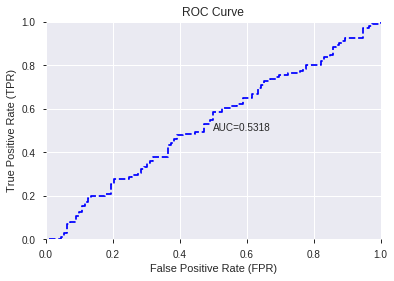

This function is available for GLM models only


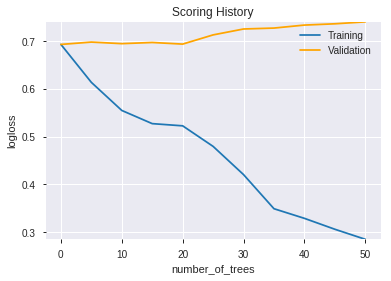

--2019-08-25 17:39:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.224.248
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.224.248|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_173934_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_173934_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'STOCHRSI_fastd',
 'CORREL_20',
 'day',
 'STOCHRSI_fastk',
 'CORREL_14',
 'hour',
 'SUB',
 'CORREL_12',
 'CORREL_8',
 'HT_TRENDMODE',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'is_month_end',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLSEPARATINGLINES',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'CDLHARAMICROSS',
 'CDLEVENINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLSTICKSANDWICH']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 918 936 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_173955_model_4  0.515122   1.222783              0.495536  0.618060  0.381998
1  DeepLearning_grid_1_AutoML_20190825_173955_model_5  0.500000   0.693676              0.500000  0.500264  0.250264
2               DeepLearning_1_AutoML_20190825_173955  0.500000   0.694500              0.500000  0.500675  0.250675
3  DeepLearning_grid_1_AutoML_20190825_173955_model_7  0.500000   0.693799              0.500000  0.500326  0.250326
4  DeepLearning_grid_1_AutoML_20190825_173955_model_8  0.500000   0.694646              0.500000  0.500747  0.250748
5  DeepLearning_grid_1_AutoML_20190825_173955_model_9  0.500000   0.696606              0.500000  0.501720  0.251723
6  DeepLearning_grid_1_AutoML_20190825_173955_model_1  0.457770  12.431625              0.500000  0.705519  0.497758
7  DeepLearning_grid_1_AutoML_20190825_173955_model_3  0.443774   0.814814              0.500000  0.546637  0.298812
8  DeepLearning_grid_1_AutoML_20190825_173955_model_6  0.431306   0.703865              0.500000  0.505270  0.255298
9  DeepLearning_grid_1_AutoML_20190825_173955_model_2  0.424791   0.928382              0.495536  0.584710  0.341886

variable  relative_importance  scaled_importance  percentage
0             CDLSTICKSANDWICH             1.000000           1.000000    0.002553
1                  CDLPIERCING             0.986038           0.986038    0.002517
2          CDLRISEFALL3METHODS             0.968256           0.968256    0.002472
3           CDLIDENTICAL3CROWS             0.943443           0.943443    0.002409
4              CDLHOMINGPIGEON             0.923487           0.923487    0.002358
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_14_6_4             0.338929           0.338929    0.000865
1032   BBANDS_upperband_14_0_4             0.338799           0.338799    0.000865
1033   BBANDS_lowerband_30_7_2             0.338204           0.338204    0.000863
1034  BBANDS_middleband_20_0_3             0.337039           0.337039    0.000860
1035   BBANDS_upperband_14_1_5             0.323442           0.323442    0.000826

[1036 rows x 4 columns]

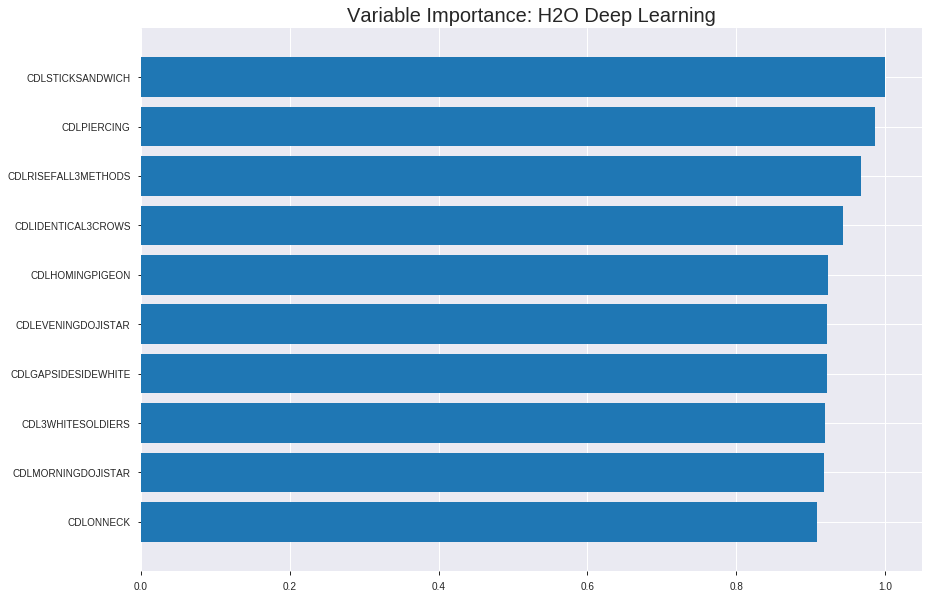

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_173955_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26211437501560886
RMSE: 0.5119710685337687
LogLoss: 0.8048749882764904
Mean Per-Class Error: 0.36593999325766935
AUC: 0.6624067145680612
pr_auc: 0.6001799508488509
Gini: 0.32481342913612243
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1884801225292929: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      264  545   0.6737   (545.0/809.0)
1      64   684   0.0856   (64.0/748.0)
Total  328  1229  0.3911   (609.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18848      0.691958  321
max f2                       0.0267255    0.825678  386
max f0point5                 0.335435     0.614952  268
max accuracy                 0.348844     0.626846  264
max precision                0.993793     1         0
max recall                   0.000454976  1         399
max specificity              0.993793     1         0
max absolute_mcc             0.265169     0.295294  295
max min_per_class_accuracy   0.557249     0.60445   186
max mean_per_class_accuracy  0.335435     0.63406   268

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 52.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.986742           1.82136   1.82136            0.875            0.990562   0.875                       0.990562            0.0187166       0.0187166                  82.1357   82.1357
    2        0.0205523                   0.982456           1.04078   1.43107            0.5              0.984643   0.6875                      0.987603            0.0106952       0.0294118                  4.07754   43.1066
    3        0.0301863                   0.976804           0.97139   1.28436            0.466667         0.980067   0.617021                    0.985198            0.00935829      0.0387701                  -2.86096  28.4361
    4        0.0404624                   0.970583           1.43107   1.32162            0.6875           0.973972   0.634921                    0.982347            0.0147059       0.0534759                  43.1066   32.162
    5        0.0500963                   0.967151           1.52647   1.36101            0.733333         0.968403   0.653846                    0.979665            0.0147059       0.0681818                  52.6471   36.1014
    6        0.100193                    0.940313           1.22758   1.2943             0.589744         0.955186   0.621795                    0.967426            0.0614973       0.129679                   22.7581   29.4298
    7        0.150289                    0.906711           1.30764   1.29875            0.628205         0.925186   0.623932                    0.953346            0.065508        0.195187                   30.7641   29.8745
    8        0.200385                    0.869991           1.3877    1.32098            0.666667         0.888468   0.634615                    0.937126            0.0695187       0.264706                   38.7701   32.0984
    9        0.299936                    0.782135           1.28922   1.31044            0.619355         0.829428   0.62955                     0.901381            0.128342        0.393048                   28.9219   31.0441
    10       0.400128                    0.666406           1.10749   1.25962            0.532051         0.721437   0.605136                    0.856323            0.110963        0.504011                   10.7492   25.9622
    11       0.500321                    0.553813           1.08081   1.22381            0.519231         0.608962   0.587933                    0.806787            0.108289        0.612299                   8.08052   22.3813
    12       0.599872                    0.432439           1.11464   1.20569            0.535484         0.491756   0.579229                    0.754507            0.110963        0.723262                   11.4637   20.5695
    13       0.700064                    0.304748           1.09415   1.18973            0.525641         0.368757   0.57156                     0.699298            0.109626        0.832888                   9.41485   18.973
    14       0.799615                    0.174198           0.859479  1.14861            0.412903         0.24185    0.551807                    0.642347            0.0855615       0.918449                   -14.0521  14.8615
    15       0.899807                    0.0583253          0.426985  1.06826            0.205128         0.117059   0.513205                    0.583857            0.0427807       0.96123                    -57.3015  6.8262
    16       1                           1.51466e-06        0.386955  1                  0.185897         0.0252463  0.480411                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3678371112765502
RMSE: 0.6064957636097306
LogLoss: 1.0978526304357963
Mean Per-Class Error: 0.48292806484295847
AUC: 0.4657953394123607
pr_auc: 0.4312436791294954
Gini: -0.06840932117527865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00949252943372142: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    233  0.9915   (233.0/235.0)
1      0    210  0        (0.0/210.0)
Total  2    443  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00949253   0.643185  397
max f2                       0.00949253   0.818394  397
max f0point5                 0.0778316    0.531146  357
max accuracy                 0.980619     0.530337  2
max precision                0.980619     0.666667  2
max recall                   0.00949253   1         397
max specificity              0.982397     0.995745  0
max absolute_mcc             0.920427     0.141574  39
max min_per_class_accuracy   0.460809     0.480952  199
max mean_per_class_accuracy  0.107397     0.517072  347

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 49.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.974528           0.847619  0.847619           0.4              0.979387   0.4                         0.979387            0.00952381      0.00952381                 -15.2381  -15.2381
    2        0.0202247                   0.965633           0.529762  0.706349           0.25             0.97151    0.333333                    0.975886            0.0047619       0.0142857                  -47.0238  -29.3651
    3        0.0314607                   0.960072           0.42381   0.605442           0.2              0.96226    0.285714                    0.971019            0.0047619       0.0190476                  -57.619   -39.4558
    4        0.0404494                   0.955196           0.529762  0.588624           0.25             0.957419   0.277778                    0.967997            0.0047619       0.0238095                  -47.0238  -41.1376
    5        0.0516854                   0.949025           0         0.460663           0                0.952066   0.217391                    0.964534            0               0.0238095                  -100      -53.9337
    6        0.101124                    0.917894           0.770563  0.612169           0.363636         0.93384    0.288889                    0.949528            0.0380952       0.0619048                  -22.9437  -38.7831
    7        0.150562                    0.895277           0.866883  0.695807           0.409091         0.908788   0.328358                    0.936151            0.0428571       0.104762                   -13.3117  -30.4193
    8        0.2                         0.865698           1.34848   0.857143           0.636364         0.880094   0.404494                    0.922294            0.0666667       0.171429                   34.8485   -14.2857
    9        0.301124                    0.747219           0.894709  0.869758           0.422222         0.815214   0.410448                    0.886334            0.0904762       0.261905                   -10.5291  -13.0242
    10       0.4                         0.599642           1.10768   0.928571           0.522727         0.674589   0.438202                    0.833993            0.109524        0.371429                   10.7684   -7.14286
    11       0.501124                    0.458443           1.08307   0.959748           0.511111         0.532673   0.452915                    0.773188            0.109524        0.480952                   8.30688   -4.0252
    12       0.6                         0.334382           0.963203  0.960317           0.454545         0.402067   0.453184                    0.71203             0.0952381       0.57619                    -3.67965  -3.96825
    13       0.698876                    0.263925           1.10768   0.981167           0.522727         0.299156   0.463023                    0.653617            0.109524        0.685714                   10.7684   -1.88333
    14       0.8                         0.142172           1.08307   0.994048           0.511111         0.1948     0.469101                    0.59562             0.109524        0.795238                   8.30688   -0.595238
    15       0.898876                    0.0755636          1.15584   1.01185            0.545455         0.111818   0.4775                      0.542402            0.114286        0.909524                   15.5844   1.18452
    16       1                           0.00241607         0.894709  1                  0.422222         0.0413573  0.47191      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 17:46:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 17:46:38  7.531 sec         135 obs/sec       0.387283  1             603        0.663598         3.0926              -0.764156      0.53658         0.520632           1.82136          0.519589                         0.66732            4.3872                -0.786903        0.476231          0.454461             0                  0.52809
    2019-08-25 17:47:07  36.295 sec        142 obs/sec       2.78741   7             4340       0.614367         1.64251             -0.512109      0.560099        0.531312           1.43107          0.519589                         0.64195            1.80797               -0.653618        0.496768          0.458497             0.42381            0.523596
    2019-08-25 17:47:37  1 min  5.918 sec  150 obs/sec       5.54592   14            8635       0.576513         1.30058             -0.331513      0.594602        0.555975           1.43107          0.519589                         0.632927           1.44857               -0.607458        0.483232          0.455235             0.847619           0.519101
    2019-08-25 17:48:05  1 min 34.403 sec  156 obs/sec       8.36416   21            13023      0.556722         1.05187             -0.241663      0.618621        0.570466           1.69126          0.464355                         0.684083           2.09151               -0.877803        0.521054          0.498632             1.27143            0.523596
    2019-08-25 17:48:33  2 min  1.909 sec  161 obs/sec       11.2209   28            17471      0.587152         1.37976             -0.381112      0.60708         0.534658           1.43107          0.46885                          0.685727           2.81841               -0.886843        0.517538          0.508449             1.69524            0.521348
    2019-08-25 17:49:02  2 min 31.569 sec  166 obs/sec       14.3776   36            22386      0.511971         0.804875            -0.0500693     0.662407        0.60018            1.82136          0.391137                         0.606496           1.09785               -0.476007        0.465795          0.431244             0.847619           0.523596
    2019-08-25 17:49:31  2 min 59.972 sec  170 obs/sec       17.526    44            27288      0.567127         1.14074             -0.288509      0.687196        0.69922            2.08155          0.436095                         0.627898           1.48318               -0.582018        0.49077           0.46175              0.847619           0.52809
    2019-08-25 17:49:34  3 min  2.778 sec  169 obs/sec       17.526    44            27288      0.511971         0.804875            -0.0500693     0.662407        0.60018            1.82136          0.391137                         0.606496           1.09785               -0.476007        0.465795          0.431244             0.847619           0.523596

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSTICKSANDWICH          1.0                    1.0                  0.002552911745839671
CDLPIERCING               0.9860379695892334     0.9860379695892334   0.0025172679144082545
CDLRISEFALL3METHODS       0.9682559967041016     0.9682559967041016   0.0024718721069655987
CDLIDENTICAL3CROWS        0.9434428811073303     0.9434428811073303   0.002408526412707724
CDLHOMINGPIGEON           0.9234866499900818     0.9234866499900818   0.002357579915885809
---                       ---                    ---                  ---
BBANDS_middleband_14_6_4  0.3389287292957306     0.3389287292957306   0.0008652551340215848
BBANDS_upperband_14_0_4   0.3387991189956665     0.3387991189956665   0.0008649242503641695
BBANDS_lowerband_30_7_2   0.33820366859436035    0.33820366859436035  0.0008634041180406101
BBANDS_middleband_20_0_3  0.3370388448238373     0.3370388448238373   0.0008604304257550084
BBANDS_upperband_14_1_5   0.3234424889087677     0.3234424889087677   0.0008257201290388106


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6666666666666666)

('auc', 0.5151222651222651)

('logloss', 1.222783155956344)

('mean_per_class_error', 0.4471122908622909)

('rmse', 0.6180598939427422)

('mse', 0.3819980325005138)

deeplearning prediction progress: |███████████████████████████████████████| 100%


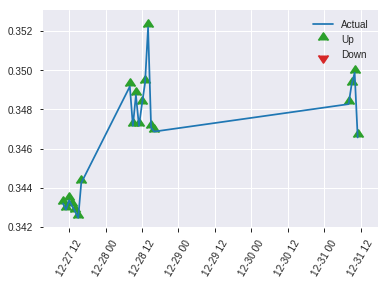


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3819980325005138
RMSE: 0.6180598939427422
LogLoss: 1.222783155956344
Mean Per-Class Error: 0.4471122908622909
AUC: 0.5151222651222651
pr_auc: 0.5103866033135782
Gini: 0.03024453024453022
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06426578916236995: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    111  0        (0.0/111.0)
Total  1    222  0.4978   (111.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0642658    0.666667  221
max f2                       0.0642658    0.833333  221
max f0point5                 0.756018     0.573871  176
max accuracy                 0.764458     0.55157   174
max precision                0.993938     1         0
max recall                   0.0642658    1         221
max specificity              0.993938     1         0
max absolute_mcc             0.756018     0.130704  176
max min_per_class_accuracy   0.907139     0.508929  111
max mean_per_class_accuracy  0.756018     0.552888  176

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 81.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.982417           1.33934   1.33934            0.666667         0.987137  0.666667                    0.987137            0.018018        0.018018                   33.9339   33.9339
    2        0.0224215                   0.981502           1.0045    1.20541            0.5              0.981785  0.6                         0.984996            0.00900901      0.027027                   0.45045   20.5405
    3        0.0313901                   0.980247           1.0045    1.14801            0.5              0.980764  0.571429                    0.983787            0.00900901      0.036036                   0.45045   14.8005
    4        0.0403587                   0.978484           2.00901   1.33934            1                0.979675  0.666667                    0.982873            0.018018        0.0540541                  100.901   33.9339
    5        0.0538117                   0.97702            1.33934   1.33934            0.666667         0.977684  0.666667                    0.981576            0.018018        0.0720721                  33.9339   33.9339
    6        0.103139                    0.971841           0.547912  0.96083            0.272727         0.973874  0.478261                    0.977892            0.027027        0.0990991                  -45.2088  -3.91696
    7        0.152466                    0.965144           1.09582   1.0045             0.545455         0.968783  0.5                         0.974945            0.0540541       0.153153                   9.58231   0.45045
    8        0.201794                    0.959607           1.27846   1.07147            0.636364         0.961992  0.533333                    0.971779            0.0630631       0.216216                   27.846    7.14715
    9        0.300448                    0.941636           0.821867  0.989512           0.409091         0.952019  0.492537                    0.96529             0.0810811       0.297297                   -17.8133  -1.04881
    10       0.399103                    0.92263            1.0045    0.993218           0.5              0.933156  0.494382                    0.957347            0.0990991       0.396396                   0.45045   -0.678206
    11       0.502242                    0.907139           1.13553   1.02244            0.565217         0.916319  0.508929                    0.948922            0.117117        0.513514                   13.5527   2.24421
    12       0.600897                    0.873845           0.913186  1.0045             0.454545         0.888531  0.5                         0.939007            0.0900901       0.603604                   -8.68141  0.45045
    13       0.699552                    0.827093           1.0045    1.0045             0.5              0.849663  0.5                         0.926407            0.0990991       0.702703                   0.45045   0.45045
    14       0.798206                    0.720507           1.4611    1.06094            0.727273         0.788775  0.52809                     0.909396            0.144144        0.846847                   46.1097   6.09373
    15       0.896861                    0.462397           0.547912  1.0045             0.272727         0.584523  0.5                         0.87366             0.0540541       0.900901                   -45.2088  0.45045
    16       1                           0.0483451          0.96083   1                  0.478261         0.297508  0.497758                    0.814237     

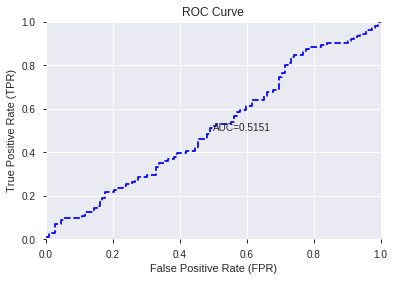

This function is available for GLM models only


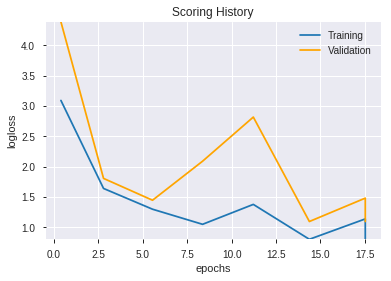

--2019-08-25 18:11:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.81.80
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.81.80|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_173955_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_173955_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLRISEFALL3METHODS',
 'CDLIDENTICAL3CROWS',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'CDLHIKKAKEMOD',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE',
 'CDLINVERTEDHAMMER',
 'CDLHARAMICROSS',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDLSEPARATINGLINES',
 'is_month_start',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'is_month_end',
 'CDLXSIDEGAP3METHODS',
 'CORREL_8',
 'SUB',
 'OBV',
 'CDLDOJI',
 'CORREL_14',
 'CORREL_20',
 'Volume',
 'CORREL_12',
 'hour',
 'CDLDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'DIV',
 'dayofweek',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'day',
 'HT_TRENDMODE',
 'CDL3OUTSIDE',
 'CORREL_24',
 'BETA_14',
 'BETA_24',
 'CORREL_30',
 'VAR_24',
 'TRANGE',
 'DX_8',
 'aroondown_30',
 'VAR_8',
 'weekday_name'

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_181118_model_1  0.451496  0.701626                   0.5  0.504196  0.254214

variable  relative_importance  scaled_importance    percentage
0                    SUB         7.985213e-03           1.000000  9.907636e-03
1            CDLBELTHOLD         7.642360e-03           0.957064  9.482241e-03
2                    DIV         7.629241e-03           0.955421  9.465964e-03
3     CDLSEPARATINGLINES         7.119096e-03           0.891535  8.833003e-03
4            CDLMARUBOZU         7.109034e-03           0.890275  8.820518e-03
...                  ...                  ...                ...           ...
1031           MAVP_14_1         3.793598e-06           0.000475  4.706899e-06
1032           MAVP_14_2         3.532003e-06           0.000442  4.382324e-06
1033                ACOS         2.459848e-06           0.000308  3.052051e-06
1034                 EXP         2.128509e-06           0.000267  2.640943e-06
1035                ASIN         5.886881e-08           0.000007  7.304135e-08

[1036 rows x 4 columns]

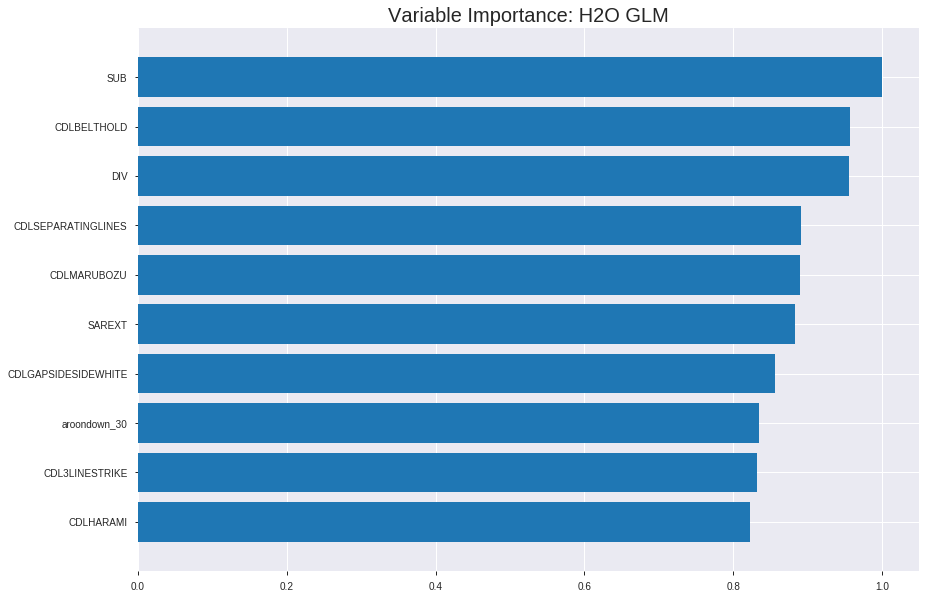

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_181118_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24570106522925916
RMSE: 0.4956824237647116
LogLoss: 0.6845045447095485
Null degrees of freedom: 1556
Residual degrees of freedom: 520
Null deviance: 2156.0698562406105
Residual deviance: 2131.547152225534
AIC: 4205.547152225534
AUC: 0.5952610339562278
pr_auc: 0.5575015644822129
Gini: 0.19052206791245552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44916995607234056: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      138  671   0.8294   (671.0/809.0)
1      56   692   0.0749   (56.0/748.0)
Total  194  1363  0.4669   (727.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44917      0.655613  325
max f2                       0.415612     0.823063  394
max f0point5                 0.468176     0.567797  252
max accuracy                 0.476        0.57675   223
max precision                0.593002     1         0
max recall                   0.415612     1         394
max specificity              0.593002     1         0
max absolute_mcc             0.468176     0.157669  252
max min_per_class_accuracy   0.480089     0.569839  210
max mean_per_class_accuracy  0.476        0.578494  223

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.554547           1.56116   1.56116            0.75             0.570354  0.75                        0.570354            0.0160428       0.0160428                  56.1163   56.1163
    2        0.0205523                   0.546153           1.30097   1.43107            0.625            0.550145  0.6875                      0.560249            0.013369        0.0294118                  30.0969   43.1066
    3        0.0301863                   0.541602           0.69385   1.19578            0.333333         0.54423   0.574468                    0.555137            0.00668449      0.0360963                  -30.615   19.5785
    4        0.0404624                   0.535696           1.17087   1.18946            0.5625           0.538289  0.571429                    0.550858            0.0120321       0.0481283                  17.0872   18.9458
    5        0.0500963                   0.530817           1.66524   1.28095            0.8              0.532736  0.615385                    0.547373            0.0160428       0.0641711                  66.5241   28.0954
    6        0.100193                    0.51647            1.22758   1.25427            0.589744         0.522684  0.602564                    0.535028            0.0614973       0.125668                   22.7581   25.4268
    7        0.150289                    0.508374           1.14752   1.21869            0.551282         0.512026  0.58547                     0.527361            0.0574866       0.183155                   14.7522   21.8686
    8        0.200385                    0.50211            1.09415   1.18755            0.525641         0.505086  0.570513                    0.521792            0.0548128       0.237968                   9.41485   18.7551
    9        0.299936                    0.493713           1.16835   1.18118            0.56129          0.497425  0.567452                    0.513705            0.11631         0.354278                   16.8354   18.118
    10       0.400128                    0.487025           1.09415   1.15939            0.525641         0.490421  0.556982                    0.507874            0.109626        0.463904                   9.41485   15.9387
    11       0.500321                    0.479862           1.09415   1.14632            0.525641         0.483726  0.550706                    0.503038            0.109626        0.573529                   9.41485   14.6323
    12       0.599872                    0.471182           1.0072    1.12324            0.483871         0.47549   0.539615                    0.498467            0.100267        0.673797                   0.7202    12.3235
    13       0.700064                    0.463535           0.907343  1.09234            0.435897         0.467224  0.524771                    0.493995            0.0909091       0.764706                   -9.26573  9.23368
    14       0.799615                    0.45571            0.899767  1.06836            0.432258         0.459751  0.513253                    0.489732            0.0895722       0.854278                   -10.0233  6.83622
    15       0.899807                    0.445719           0.81394   1.04003            0.391026         0.451599  0.499643                    0.485486            0.0815508       0.935829                   -18.606   4.00325
    16       1                           0.310842           0.640477  1                  0.307692         0.434836  0.480411                    0.480411          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2492807858665513
RMSE: 0.4992802678521867
LogLoss: 0.691705217960661
Null degrees of freedom: 444
Residual degrees of freedom: -592
Null deviance: 615.6246511654862
Residual deviance: 615.6176439849881
AIC: 2689.6176439849883
AUC: 0.5251975683890577
pr_auc: 0.48831051990988456
Gini: 0.05039513677811547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4353234554859636: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    231  0.983    (231.0/235.0)
1      1    209  0.0048   (1.0/210.0)
Total  5    440  0.5213   (232.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.435323     0.643077   394
max f2                       0.427769     0.817121   399
max f0point5                 0.470336     0.538977   315
max accuracy                 0.532782     0.539326   42
max precision                0.549833     0.636364   10
max recall                   0.427769     1          399
max specificity              0.573178     0.995745   0
max absolute_mcc             0.470336     0.0914417  315
max min_per_class_accuracy   0.498817     0.5        194
max mean_per_class_accuracy  0.470336     0.536322   315

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 49.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.555855           0.42381   0.42381            0.2              0.563463  0.2                         0.563463            0.0047619       0.0047619                  -57.619   -57.619
    2        0.0202247                   0.550807           2.11905   1.17725            1                0.553509  0.555556                    0.559039            0.0190476       0.0238095                  111.905   17.7249
    3        0.0314607                   0.547681           1.27143   1.21088            0.6              0.549095  0.571429                    0.555488            0.0142857       0.0380952                  27.1429   21.0884
    4        0.0404494                   0.543566           1.05952   1.17725            0.5              0.545317  0.555556                    0.553228            0.00952381      0.047619                   5.95238   17.7249
    5        0.0516854                   0.540861           0.847619  1.10559            0.4              0.542019  0.521739                    0.550791            0.00952381      0.0571429                  -15.2381  10.559
    6        0.101124                    0.532743           1.25216   1.17725            0.590909         0.537372  0.555556                    0.544231            0.0619048       0.119048                   25.2165   17.7249
    7        0.150562                    0.527031           0.770563  1.04371            0.363636         0.529232  0.492537                    0.539306            0.0380952       0.157143                   -22.9437  4.371
    8        0.2                         0.521905           1.05952   1.04762            0.5              0.524448  0.494382                    0.535633            0.052381        0.209524                   5.95238   4.7619
    9        0.301124                    0.513792           0.988889  1.0279             0.466667         0.517261  0.485075                    0.529463            0.1             0.309524                   -1.11111  2.78962
    10       0.4                         0.506143           1.05952   1.03571            0.5              0.5097    0.488764                    0.524578            0.104762        0.414286                   5.95238   3.57143
    11       0.501124                    0.498084           0.847619  0.997758           0.4              0.502494  0.470852                    0.520122            0.0857143       0.5                        -15.2381  -0.224215
    12       0.6                         0.48934            1.30032   1.04762            0.613636         0.493364  0.494382                    0.515712            0.128571        0.628571                   30.0325   4.7619
    13       0.698876                    0.479543           0.915043  1.02886            0.431818         0.484372  0.485531                    0.511278            0.0904762       0.719048                   -8.49567  2.88623
    14       0.8                         0.470535           1.13016   1.04167            0.533333         0.475193  0.491573                    0.506717            0.114286        0.833333                   13.0159   4.16667
    15       0.898876                    0.458334           0.866883  1.02244            0.409091         0.465547  0.4825                      0.502188            0.0857143       0.919048                   -13.3117  2.24405
    16       1                           0.427769           0.800529  1                  0.377778         0.446407  0.47191                     0.496547            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 18:11:21  0.000 sec   2            2.9       1037          1.36901           1.38341
    2019-08-25 18:11:23  1.857 sec   4            2.1       1037          1.3655            1.38415
    2019-08-25 18:11:25  3.690 sec   6            1.5       1037          1.36144           1.38501
    2019-08-25 18:11:27  5.577 sec   8            1.1       1037          1.35675           1.38617
    2019-08-25 18:11:29  7.430 sec   10           0.81      1037          1.35147           1.38773
    2019-08-25 18:11:31  9.320 sec   12           0.59      1037          1.34564           1.38963

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5291479820627802)

('F1', 0.6646706586826348)

('auc', 0.451496138996139)

('logloss', 0.7016264571714836)

('mean_per_class_error', 0.47281209781209776)

('rmse', 0.5041964319695623)

('mse', 0.2542140420108375)

glm prediction progress: |████████████████████████████████████████████████| 100%


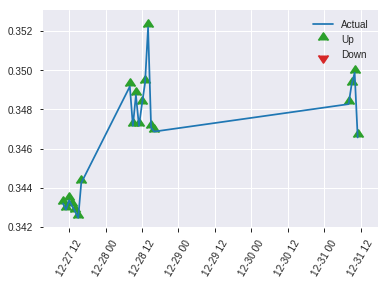


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2542140420108375
RMSE: 0.5041964319695623
LogLoss: 0.7016264571714836
Null degrees of freedom: 222
Residual degrees of freedom: -814
Null deviance: 309.40779410652675
Residual deviance: 312.9253998984817
AIC: 2386.925399898482
AUC: 0.451496138996139
pr_auc: 0.49617382945356336
Gini: -0.09700772200772201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46819687483279054: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    111  0        (0.0/111.0)
Total  0    223  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468197     0.664671  222
max f2                       0.468197     0.832084  222
max f0point5                 0.505978     0.559662  208
max accuracy                 0.573591     0.529148  13
max precision                0.592898     1         0
max recall                   0.468197     1         222
max specificity              0.592898     1         0
max absolute_mcc             0.582107     0.152126  4
max min_per_class_accuracy   0.545386     0.455357  111
max mean_per_class_accuracy  0.573591     0.527188  13

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 54.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.582517           2.00901   2.00901            1                0.586158  1                           0.586158            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.581859           2.00901   2.00901            1                0.582111  1                           0.584539            0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.579349           0         1.43501            0                0.580861  0.714286                    0.583488            0               0.045045                   -100      43.5006
    4        0.0403587                   0.578651           1.0045    1.33934            0.5              0.578885  0.666667                    0.582465            0.00900901      0.0540541                  0.45045   33.9339
    5        0.0538117                   0.57382            1.33934   1.33934            0.666667         0.575583  0.666667                    0.580745            0.018018        0.0720721                  33.9339   33.9339
    6        0.103139                    0.57053            0.730549  1.04818            0.363636         0.572485  0.521739                    0.576795            0.036036        0.108108                   -26.9451  4.81786
    7        0.152466                    0.565466           1.09582   1.06359            0.545455         0.568216  0.529412                    0.574019            0.0540541       0.162162                   9.58231   6.3593
    8        0.201794                    0.562243           0.547912  0.937538           0.272727         0.563973  0.466667                    0.571564            0.027027        0.189189                   -45.2088  -6.24625
    9        0.300448                    0.556594           0.821867  0.899556           0.409091         0.559869  0.447761                    0.567724            0.0810811       0.27027                    -17.8133  -10.0444
    10       0.399103                    0.550286           0.730549  0.857779           0.363636         0.554268  0.426966                    0.564397            0.0720721       0.342342                   -26.9451  -14.2221
    11       0.502242                    0.545386           1.13553   0.914817           0.565217         0.548002  0.455357                    0.56103             0.117117        0.459459                   13.5527   -8.51834
    12       0.600897                    0.539393           1.0045    0.929541           0.5              0.542159  0.462687                    0.557932            0.0990991       0.558559                   0.45045   -7.04585
    13       0.699552                    0.532578           0.821867  0.914357           0.409091         0.536695  0.455128                    0.554937            0.0810811       0.63964                    -17.8133  -8.56433
    14       0.798206                    0.521751           1.27846   0.959358           0.636364         0.527984  0.477528                    0.551606            0.126126        0.765766                   27.846    -4.06418
    15       0.896861                    0.508835           1.27846   0.994459           0.636364         0.516682  0.495                       0.547764            0.126126        0.891892                   27.846    -0.554054
    16       1                           0.468197           1.04818   1                  0.521739         0.497161  0.497758                    0.542545 

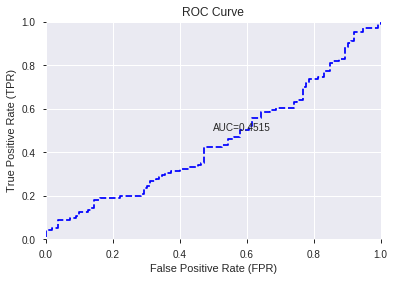

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


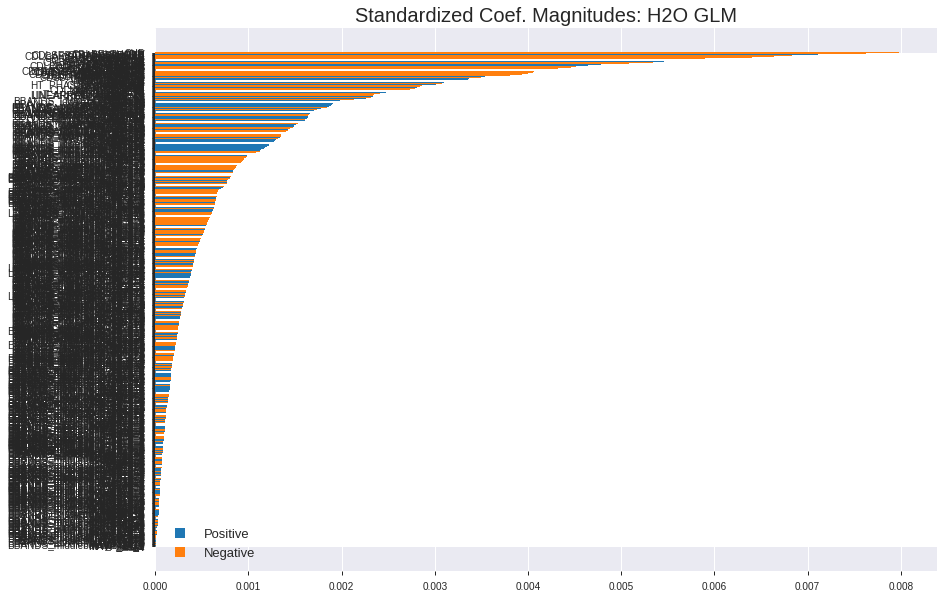

'log_likelihood'
--2019-08-25 18:11:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_181118_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_181118_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'CDLBELTHOLD',
 'DIV',
 'CDLSEPARATINGLINES',
 'CDLMARUBOZU',
 'SAREXT',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_30',
 'CDL3LINESTRIKE',
 'CDLHARAMI',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'HT_TRENDMODE',
 'CORREL_8',
 'BETA_14',
 'BETA_12',
 'aroonup_14',
 'DX_12',
 'DX_14',
 'CDLADVANCEBLOCK',
 'AROONOSC_30',
 'aroonup_12',
 'CORREL_24',
 'STOCHRSI_fastd',
 'AD',
 'CDLHIKKAKEMOD',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'DX_8',
 'MINUS_DI_14',
 'MINUS_DI_12',
 'CDLSPINNINGTOP',
 'DX_20',
 'is_month_start',
 'MINUS_DI_20',
 'VAR_30',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'HT_PHASOR_inphase',
 'CDLONNECK',
 'MINUS_DI_24',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLSTICKSANDWICH',
 'CDLDOJISTAR',
 'MINUS_DI_8',
 'CDLHARAMICROSS',
 'MINUS_DI_30',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'DX_24',
 'STDDEV_30',
 'VAR_24',
 'MACDEXT_hist',
 'MFI_24',
 'CDLHIGHWAVE',
 'STOCH_slowd',
 'MINUS_DM_8',
 'VAR_8',
 'CDLHAMMER',
 'aroondown_8',
 'VAR_14',

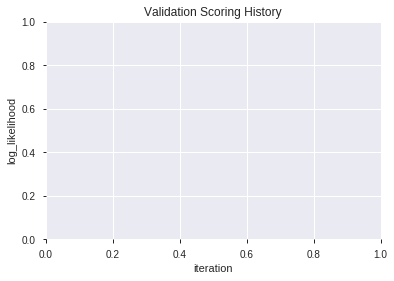

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_181157_model_2  0.604569  0.685158              0.428773  0.495962  0.245978
1  XGBoost_grid_1_AutoML_20190825_181157_model_1  0.542551  0.732027              0.500000  0.517718  0.268032
2               XGBoost_3_AutoML_20190825_181157  0.535151  0.724598              0.473214  0.514488  0.264698
3  XGBoost_grid_1_AutoML_20190825_181157_model_3  0.522523  0.744317              0.491112  0.523188  0.273726
4               XGBoost_1_AutoML_20190825_181157  0.510940  0.722767              0.460023  0.513230  0.263405
5  XGBoost_grid_1_AutoML_20190825_181157_model_5  0.507561  0.798527              0.500000  0.543461  0.295349
6  XGBoost_grid_1_AutoML_20190825_181157_model_7  0.507320  0.745940              0.482183  0.523106  0.273639
7               XGBoost_2_AutoML_20190825_181157  0.504102  0.720344              0.500000  0.512545  0.262702
8  XGBoost_grid_1_AutoML_20190825_181157_model_6  0.502091  0.719745              0.495536  0.512070  0.262216
9  XGBoost_grid_1_AutoML_20190825_181157_model_4  0.496863  0.703972              0.486647  0.505182  0.255208

variable  relative_importance  scaled_importance  percentage
0                     CCI_12           129.439941           1.000000    0.022340
1                        BOP           114.124191           0.881677    0.019696
2                      ATR_8            86.281700           0.666577    0.014891
3             STOCHRSI_fastd            83.505333           0.645128    0.014412
4                     SAREXT            82.542419           0.637689    0.014246
..                       ...                  ...                ...         ...
340               MIDPOINT_8             0.332883           0.002572    0.000057
341  BBANDS_upperband_12_0_5             0.242275           0.001872    0.000042
342  BBANDS_lowerband_20_0_2             0.226905           0.001753    0.000039
343  BBANDS_upperband_12_1_2             0.225367           0.001741    0.000039
344   BBANDS_upperband_8_1_3             0.143547           0.001109    0.000025

[345 rows x 4 columns]

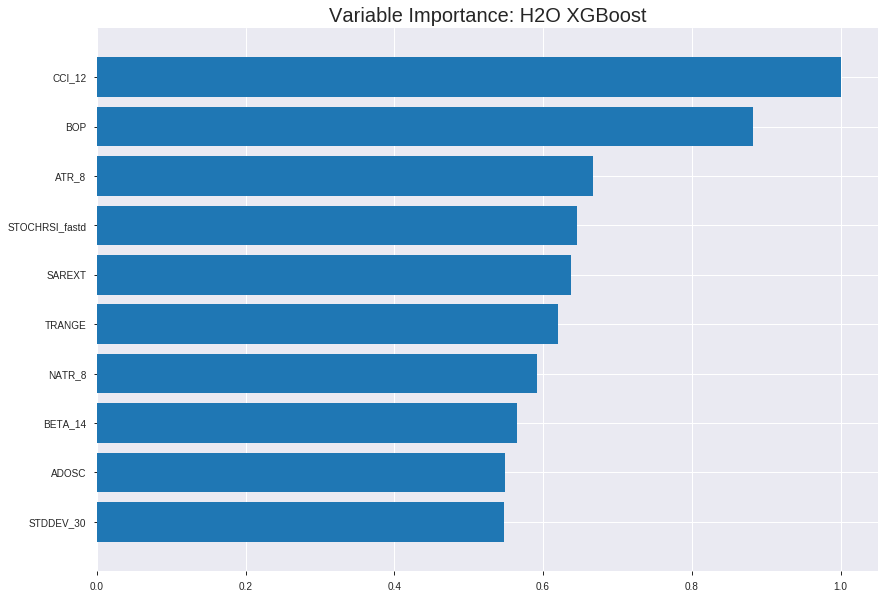

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_181157_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1780934198295701
RMSE: 0.4220111607879229
LogLoss: 0.545421116213183
Mean Per-Class Error: 0.12703426690374986
AUC: 0.9473957748061581
pr_auc: 0.9432915214746218
Gini: 0.8947915496123162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47743862122297287: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      694  115  0.1422   (115.0/809.0)
1      87   661  0.1163   (87.0/748.0)
Total  781  776  0.1297   (202.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477439     0.867454  206
max f2                       0.432902     0.908862  249
max f0point5                 0.519612     0.889668  167
max accuracy                 0.494067     0.874117  192
max precision                0.751917     1         0
max recall                   0.357503     1         324
max specificity              0.751917     1         0
max absolute_mcc             0.494067     0.748333  192
max min_per_class_accuracy   0.481793     0.868984  202
max mean_per_class_accuracy  0.492806     0.872966  193

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.711153           2.08155    2.08155            1                0.726039  1                           0.726039            0.0213904       0.0213904                  108.155   108.155
    2        0.0205523                   0.698758           2.08155    2.08155            1                0.704059  1                           0.715049            0.0213904       0.0427807                  108.155   108.155
    3        0.0301863                   0.686836           2.08155    2.08155            1                0.692114  1                           0.707729            0.0200535       0.0628342                  108.155   108.155
    4        0.0404624                   0.676562           1.95145    2.04851            0.9375           0.681218  0.984127                    0.700996            0.0200535       0.0828877                  95.1454   104.851
    5        0.0500963                   0.668992           2.08155    2.05486            1                0.673764  0.987179                    0.695759            0.0200535       0.102941                   108.155   105.486
    6        0.100193                    0.636226           2.08155    2.06821            1                0.650942  0.99359                     0.673351            0.104278        0.207219                   108.155   106.821
    7        0.150289                    0.609541           2.05486    2.06376            0.987179         0.623194  0.991453                    0.656632            0.102941        0.31016                    105.486   106.376
    8        0.200385                    0.588196           2.05486    2.06154            0.987179         0.598726  0.990385                    0.642155            0.102941        0.413102                   105.486   106.154
    9        0.299936                    0.549221           1.89354    2.00578            0.909677         0.568274  0.963597                    0.617634            0.188503        0.601604                   89.354    100.578
    10       0.400128                    0.512519           1.62788    1.91115            0.782051         0.532568  0.918138                    0.596333            0.163102        0.764706                   62.7879   91.1151
    11       0.500321                    0.476722           1.20089    1.76892            0.576923         0.494745  0.849807                    0.575989            0.120321        0.885027                   20.0895   76.8917
    12       0.599872                    0.441445           0.644609   1.58234            0.309677         0.458072  0.760171                    0.556421            0.0641711       0.949198                   -35.5391  58.2335
    13       0.700064                    0.410232           0.360268   1.40743            0.173077         0.426426  0.676147                    0.537816            0.0360963       0.985294                   -63.9732  40.7434
    14       0.799615                    0.377405           0.107435   1.24559            0.0516129        0.395264  0.598394                    0.520068            0.0106952       0.995989                   -89.2565  24.5587
    15       0.899807                    0.342093           0.0400298  1.11135            0.0192308        0.359316  0.533904                    0.502169            0.0040107       1                          -95.997   11.1349
    16       1                           0.20684            0          1                  0                0.312155  0.480411                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26018811735354597
RMSE: 0.510086382246719
LogLoss: 0.7140779480269385
Mean Per-Class Error: 0.49539007092198584
AUC: 0.4766869300911854
pr_auc: 0.4514201317929624
Gini: -0.0466261398176292
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3223402798175812: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    234  0.9957   (234.0/235.0)
1      0    210  0        (0.0/210.0)
Total  1    444  0.5258   (234.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.32234      0.642202   398
max f2                       0.32234      0.817757   398
max f0point5                 0.336856     0.528993   393
max accuracy                 0.678008     0.52809    1
max precision                0.678008     0.5        1
max recall                   0.32234      1          398
max specificity              0.688584     0.995745   0
max absolute_mcc             0.402236     0.0827272  363
max min_per_class_accuracy   0.52399      0.47234    199
max mean_per_class_accuracy  0.36425      0.50461    382

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 51.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.671634           0.42381   0.42381            0.2              0.678402  0.2                         0.678402            0.0047619       0.0047619                  -57.619   -57.619
    2        0.0202247                   0.659458           1.05952   0.706349           0.5              0.667317  0.333333                    0.673475            0.00952381      0.0142857                  5.95238   -29.3651
    3        0.0314607                   0.64529            0.847619  0.756803           0.4              0.654679  0.357143                    0.666762            0.00952381      0.0238095                  -15.2381  -24.3197
    4        0.0404494                   0.640635           1.58929   0.941799           0.75             0.642615  0.444444                    0.661396            0.0142857       0.0380952                  58.9286   -5.82011
    5        0.0516854                   0.635895           0.847619  0.921325           0.4              0.638329  0.434783                    0.656382            0.00952381      0.047619                   -15.2381  -7.86749
    6        0.101124                    0.612205           0.963203  0.941799           0.454545         0.62422   0.444444                    0.640658            0.047619        0.0952381                  -3.67965  -5.82011
    7        0.150562                    0.595002           0.866883  0.9172             0.409091         0.603733  0.432836                    0.628534            0.0428571       0.138095                   -13.3117  -8.28003
    8        0.2                         0.578975           0.866883  0.904762           0.409091         0.587596  0.426966                    0.618414            0.0428571       0.180952                   -13.3117  -9.52381
    9        0.301124                    0.559925           1.17725   0.996269           0.555556         0.569539  0.470149                    0.602001            0.119048        0.3                        17.7249   -0.373134
    10       0.4                         0.542572           0.963203  0.988095           0.454545         0.551028  0.466292                    0.589401            0.0952381       0.395238                   -3.67965  -1.19048
    11       0.501124                    0.524092           0.753439  0.940743           0.355556         0.533193  0.443946                    0.578058            0.0761905       0.471429                   -24.6561  -5.92569
    12       0.6                         0.505625           1.10768   0.968254           0.522727         0.514362  0.456929                    0.567561            0.109524        0.580952                   10.7684   -3.1746
    13       0.698876                    0.482591           1.01136   0.974353           0.477273         0.494888  0.459807                    0.55728             0.1             0.680952                   1.13636   -2.56469
    14       0.8                         0.455295           1.13016   0.994048           0.533333         0.469713  0.469101                    0.546211            0.114286        0.795238                   13.0159   -0.595238
    15       0.898876                    0.414548           0.915043  0.985357           0.431818         0.437311  0.465                       0.534232            0.0904762       0.885714                   -8.49567  -1.46429
    16       1                           0.285794           1.13016   1                  0.533333         0.371187  0.47191                     0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:12:12  2.543 sec   0                  0.5              0.693147            0.5             0                  1                0.519589                         0.5                0.693147              0.5               0                    1                  0.52809
    2019-08-25 18:12:13  3.232 sec   5                  0.491126         0.67553             0.754867        0.704483           2.08155          0.37508                          0.501287           0.695727              0.486717          0.463137             0.908163           0.516854
    2019-08-25 18:12:13  3.439 sec   10                 0.481988         0.657629            0.804406        0.787404           2.08155          0.297367                         0.502644           0.698464              0.478369          0.467064             1.27143            0.52809
    2019-08-25 18:12:13  3.648 sec   15                 0.474026         0.642205            0.837941        0.827677           2.08155          0.257547                         0.503488           0.700192              0.483151          0.464215             0.847619           0.52809
    2019-08-25 18:12:13  3.889 sec   20                 0.465439         0.625751            0.865401        0.852894           2.08155          0.229287                         0.503911           0.701072              0.490243          0.465852             0.847619           0.523596
    2019-08-25 18:12:14  4.108 sec   25                 0.457253         0.610267            0.889185        0.880722           2.08155          0.19589                          0.504425           0.702141              0.488703          0.467958             0.42381            0.523596
    2019-08-25 18:12:14  4.338 sec   30                 0.449585         0.595895            0.903807        0.897288           2.08155          0.179191                         0.505032           0.703409              0.49155           0.465864             0.847619           0.523596
    2019-08-25 18:12:14  4.599 sec   35                 0.44283          0.583321            0.914024        0.908682           2.08155          0.170841                         0.506695           0.706853              0.479929          0.45591              1.27143            0.523596
    2019-08-25 18:12:14  4.867 sec   40                 0.43589          0.57054             0.925468        0.919867           2.08155          0.154143                         0.507917           0.70943               0.480547          0.458554             0.847619           0.523596
    2019-08-25 18:12:14  5.079 sec   45                 0.428312         0.55675             0.937544        0.932543           2.08155          0.136159                         0.508806           0.711347              0.482239          0.45707              0.847619           0.523596
    2019-08-25 18:12:15  5.301 sec   50                 0.422011         0.545421            0.947396        0.943292           2.08155          0.129737                         0.510086           0.714078              0.476687          0.45142              0.42381            0.525843

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CCI_12                   129.43994140625        1.0                    0.02233952494790461
BOP                      114.12419128417969     0.8816767841851727     0.019696240516292974
ATR_8                    86.28170013427734      0.6665770951137903     0.014891015645996302
STOCHRSI_fastd           83.50533294677734      0.6451280187519097     0.01441185346950056
SAREXT                   82.54241943359375      0.6376889431256201     0.014245668053957713
---                      ---                    ---                    ---
MIDPOINT_8               0.33288294076919556    0.0025717173320129634  5.745094349746228e-05
BBANDS_upperband_12_0_5  0.24227510392665863    0.0018717182756308045  4.181329711390335e-05
BBANDS_lowerband_20_0_2  0.22690515220165253    0.0017529763204195675  3.916065824309895e-05
BBANDS_upperband_12_1_2  0.2253667712211609     0.0017410914187131969  3.889515518492609e-05
BBANDS_upperband_8_1_3   0.14354734122753143    0.0011089879960390668  2.4774265004441477e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6098654708520179)

('F1', 0.6883116883116883)

('auc', 0.6045688545688546)

('logloss', 0.6851580906688466)

('mean_per_class_error', 0.389559202059202)

('rmse', 0.4959617325897827)

('mse', 0.24597804019345912)

xgboost prediction progress: |████████████████████████████████████████████| 100%


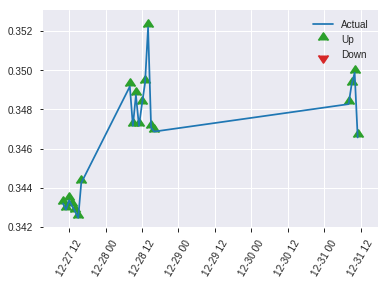


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24597804019345912
RMSE: 0.4959617325897827
LogLoss: 0.6851580906688466
Mean Per-Class Error: 0.389559202059202
AUC: 0.6045688545688546
pr_auc: 0.5479270918793435
Gini: 0.20913770913770913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48812559247016907: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      21   91   0.8125   (91.0/112.0)
1      5    106  0.045    (5.0/111.0)
Total  26   197  0.4305   (96.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488126     0.688312  196
max f2                       0.464195     0.842185  214
max f0point5                 0.52094      0.611028  139
max accuracy                 0.522751     0.609865  135
max precision                0.600989     0.647059  16
max recall                   0.464195     1         214
max specificity              0.641524     0.991071  0
max absolute_mcc             0.52094      0.228469  139
max min_per_class_accuracy   0.53945      0.580357  111
max mean_per_class_accuracy  0.52094      0.610441  139

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 53.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.63172            0.66967   0.66967            0.333333         0.636457  0.333333                    0.636457            0.00900901      0.00900901                 -33.033   -33.033
    2        0.0224215                   0.624452           1.0045    0.803604           0.5              0.62796   0.4                         0.633058            0.00900901      0.018018                   0.45045   -19.6396
    3        0.0313901                   0.613523           1.0045    0.861004           0.5              0.620557  0.428571                    0.629486            0.00900901      0.027027                   0.45045   -13.8996
    4        0.0403587                   0.609359           2.00901   1.11612            1                0.609997  0.555556                    0.625155            0.018018        0.045045                   100.901   11.6116
    5        0.0538117                   0.606947           0.66967   1.0045             0.333333         0.607976  0.5                         0.620861            0.00900901      0.0540541                  -33.033   0.45045
    6        0.103139                    0.596413           1.09582   1.04818            0.545455         0.601266  0.521739                    0.611489            0.0540541       0.108108                   9.58231   4.81786
    7        0.152466                    0.583327           0.913186  1.0045             0.454545         0.589927  0.5                         0.604513            0.045045        0.153153                   -8.68141  0.45045
    8        0.201794                    0.576418           1.27846   1.07147            0.636364         0.580185  0.533333                    0.598566            0.0630631       0.216216                   27.846    7.14715
    9        0.300448                    0.561652           1.09582   1.07947            0.545455         0.569248  0.537313                    0.588939            0.108108        0.324324                   9.58231   7.94675
    10       0.399103                    0.548749           1.27846   1.12866            0.636364         0.554882  0.561798                    0.580521            0.126126        0.45045                    27.846    12.8657
    11       0.502242                    0.53945            1.31022   1.16594            0.652174         0.544205  0.580357                    0.573063            0.135135        0.585586                   31.0223   16.5943
    12       0.600897                    0.524095           1.18714   1.16942            0.590909         0.531448  0.58209                     0.566231            0.117117        0.702703                   18.7142   16.9423
    13       0.699552                    0.515401           0.913186  1.13329            0.454545         0.518915  0.564103                    0.559558            0.0900901       0.792793                   -8.68141  13.3287
    14       0.798206                    0.501973           0.913186  1.10608            0.454545         0.508603  0.550562                    0.55326             0.0900901       0.882883                   -8.68141  10.6084
    15       0.896861                    0.484349           0.730549  1.06477            0.363636         0.494463  0.53                        0.546792            0.0720721       0.954955                   -26.9451  6.47748
    16       1                           0.437251           0.436741  1                  0.217391         0.467303  0.497758                    0.538594       

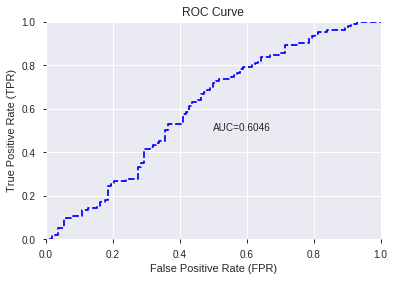

This function is available for GLM models only


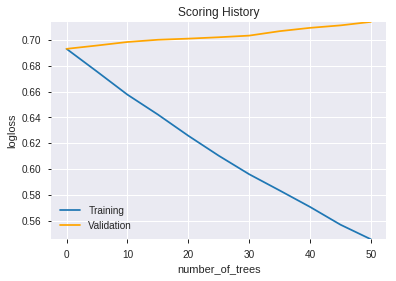

--2019-08-25 18:12:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_181157_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_181157_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CCI_12',
 'BOP',
 'ATR_8',
 'STOCHRSI_fastd',
 'SAREXT',
 'TRANGE',
 'NATR_8',
 'BETA_14',
 'ADOSC',
 'STDDEV_30',
 'AD',
 'AROONOSC_30',
 'NATR_30',
 'MFI_8',
 'BETA_12',
 'STDDEV_8',
 'DIV',
 'STOCHF_fastk',
 'MFI_30',
 'BETA_20',
 'HT_PHASOR_inphase',
 'PLUS_DI_12',
 'PLUS_DM_8',
 'STOCH_slowd',
 'HT_DCPERIOD',
 'Volume',
 'ATR_12',
 'CORREL_20',
 'MOM_30',
 'PLUS_DI_8',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'STOCH_slowk',
 'OBV',
 'CCI_8',
 'ADXR_8',
 'CCI_14',
 'LINEARREG_ANGLE_8',
 'MACDEXT_hist',
 'CORREL_30',
 'DX_20',
 'MFI_14',
 'ADX_14',
 'MINUS_DI_14',
 'AROONOSC_8',
 'day',
 'WILLR_12',
 'WILLR_30',
 'ROC_30',
 'MACD_hist',
 'PPO',
 'CDLHIKKAKE',
 'DX_12',
 'dayofyear',
 'ADXR_14',
 'MINUS_DI_12',
 'MFI_12',
 'MACDFIX_hist_8',
 'ULTOSC',
 'DX_30',
 'BETA_8',
 'STDDEV_24',
 'NATR_24',
 'ADXR_12',
 'CMO_24',
 'CORREL_24',
 'MACDFIX_hist_20',
 'MACDFIX_hist_14',
 'BBANDS_upperband_20_7_5',
 'CCI_30',
 'ADX_8',
 'LINEARREG_ANGLE_24',
 'aroonup_14',
 'CORREL_12',
 'ADX_24',
 

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

750

['BBANDS_lowerband_8_7_5',
 'MA_8_8',
 'MAVP_8_8',
 'T3_8_8',
 'BBANDS_upperband_8_8_2',
 'BBANDS_middleband_8_8_2',
 'BBANDS_lowerband_8_8_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_8_8_3',
 'BBANDS_lowerband_8_8_3',
 'BBANDS_upperband_8_8_4',
 'BBANDS_middleband_8_8_4',
 'BBANDS_lowerband_8_8_4',
 'BBANDS_upperband_8_8_5',
 'BBANDS_middleband_8_8_5',
 'BBANDS_lowerband_8_8_5',
 'DEMA_12',
 'EMA_12',
 'KAMA_12',
 'MIDPOINT_12',
 'MIDPRICE_12',
 'SAR_0.12',
 'SMA_12',
 'TEMA_12',
 'TRIMA_12',
 'WMA_12',
 'MA_12_0',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_12_0_2',
 'BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBAN

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_181345_model_9  0.547699  0.692564              0.500000  0.499708  0.249708
1  DeepLearning_grid_1_AutoML_20190825_181345_model_1  0.511905  1.433275              0.500000  0.620546  0.385077
2  DeepLearning_grid_1_AutoML_20190825_181345_model_2  0.503378  0.990134              0.495536  0.590372  0.348540
3               DeepLearning_1_AutoML_20190825_181345  0.500000  0.693140              0.500000  0.499997  0.249997
4  DeepLearning_grid_1_AutoML_20190825_181345_model_5  0.500000  0.693150              0.500000  0.500001  0.250001
5  DeepLearning_grid_1_AutoML_20190825_181345_model_8  0.500000  0.694667              0.500000  0.500758  0.250758
6  DeepLearning_grid_1_AutoML_20190825_181345_model_6  0.500000  0.694569              0.500000  0.500709  0.250709
7  DeepLearning_grid_1_AutoML_20190825_181345_model_4  0.496139  0.916248              0.500000  0.576308  0.332131
8  DeepLearning_grid_1_AutoML_20190825_181345_model_7  0.495495  0.694650              0.500000  0.500749  0.250750
9  DeepLearning_grid_1_AutoML_20190825_181345_model_3  0.462597  0.831542              0.495536  0.553805  0.306700

variable  relative_importance  scaled_importance  percentage
0            AROONOSC_30             1.000000           1.000000    0.001651
1           HT_TRENDMODE             0.992199           0.992199    0.001638
2              CORREL_12             0.991405           0.991405    0.001636
3              CORREL_14             0.983403           0.983403    0.001623
4                  DX_14             0.978157           0.978157    0.001615
..                   ...                  ...                ...         ...
742             MEDPRICE             0.720609           0.720609    0.001189
743              KAMA_30             0.718231           0.718231    0.001186
744  CDLXSIDEGAP3METHODS             0.714036           0.714036    0.001179
745           CDL3INSIDE             0.704773           0.704773    0.001163
746   CDLSEPARATINGLINES             0.702087           0.702087    0.001159

[747 rows x 4 columns]

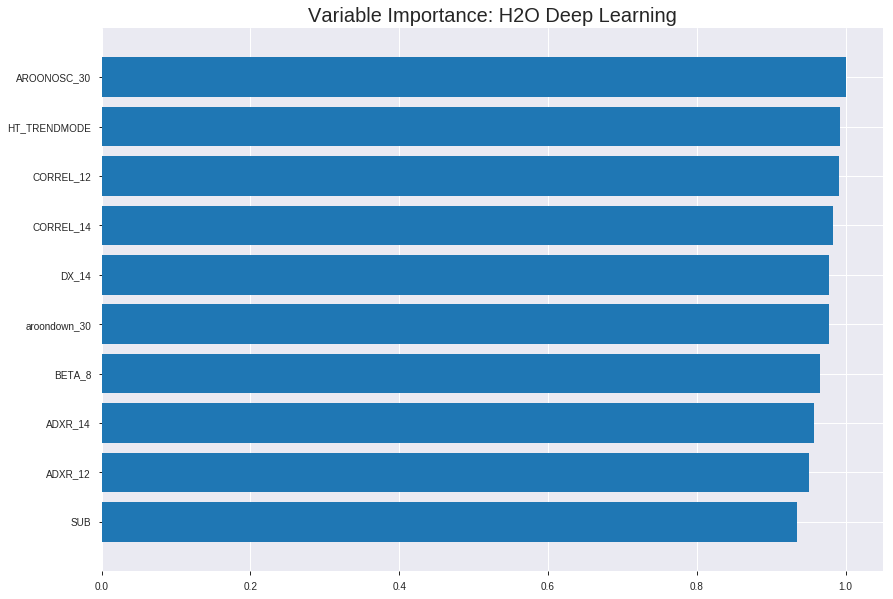

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_181345_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24904274432405765
RMSE: 0.49904182622707854
LogLoss: 0.6912238584977736
Mean Per-Class Error: 0.4751971470687387
AUC: 0.5265677571174554
pr_auc: 0.4961637032980913
Gini: 0.05313551423491081
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.413537272290752: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    802   0.9913   (802.0/809.0)
1      2    746   0.0027   (2.0/748.0)
Total  9    1548  0.5164   (804.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.413537     0.649826   391
max f2                       0.402182     0.822159   399
max f0point5                 0.443731     0.541448   289
max accuracy                 0.487974     0.525369   55
max precision                0.495925     1          0
max recall                   0.402182     1          399
max specificity              0.495925     1          0
max absolute_mcc             0.443731     0.0656817  289
max min_per_class_accuracy   0.48258      0.522868   99
max mean_per_class_accuracy  0.48258      0.524803   99

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.494053           1.04078   1.04078            0.5              0.494817  0.5                         0.494817            0.0106952       0.0106952                  4.07754   4.07754
    2        0.0205523                   0.492923           1.04078   1.04078            0.5              0.493411  0.5                         0.494114            0.0106952       0.0213904                  4.07754   4.07754
    3        0.0301863                   0.492473           1.11016   1.06292            0.533333         0.492629  0.510638                    0.49364             0.0106952       0.0320856                  11.016    6.29196
    4        0.0404624                   0.492097           0.910678  1.02426            0.4375           0.492272  0.492063                    0.493293            0.00935829      0.0414439                  -8.93215  2.42552
    5        0.0500963                   0.491836           0.83262   0.987402           0.4              0.491942  0.474359                    0.493033            0.00802139      0.0494652                  -16.738   -1.25977
    6        0.100193                    0.490131           0.987402  0.987402           0.474359         0.491074  0.474359                    0.492053            0.0494652       0.0989305                  -1.25977  -1.25977
    7        0.150289                    0.488435           1.17421   1.04967            0.564103         0.489332  0.504274                    0.491146            0.0588235       0.157754                   17.4208   4.96709
    8        0.200385                    0.486805           1.04078   1.04745            0.5              0.487595  0.503205                    0.490259            0.052139        0.209893                   4.07754   4.7447
    9        0.457932                    0.484327           1.0278    1.0364             0.493766         0.484629  0.497896                    0.487093            0.264706        0.474599                   2.77982   3.63963
    10       0.500321                    0.482536           1.23001   1.0528             0.590909         0.483473  0.505777                    0.486786            0.052139        0.526738                   23.0007   5.27998
    11       0.599872                    0.474422           0.913196  1.02963            0.43871          0.478684  0.494647                    0.485441            0.0909091       0.617647                   -8.68035  2.96322
    12       0.700064                    0.46263            1.02743   1.02932            0.49359          0.468606  0.494495                    0.483032            0.102941        0.720588                   2.74321   2.93173
    13       0.799615                    0.44876            1.0072    1.02656            0.483871         0.455585  0.493173                    0.479615            0.100267        0.820856                   0.7202    2.6564
    14       0.899807                    0.43924            0.934029  1.01626            0.448718         0.444357  0.488223                    0.475689            0.0935829       0.914439                   -6.59708  1.62603
    15       1                           0.402182           0.85397   1                  0.410256         0.429235  0.480411                    0.471035            0.0855615       1                          -14.603   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24772495829967825
RMSE: 0.4977197587997469
LogLoss: 0.6885843306396899
Mean Per-Class Error: 0.4399189463019251
AUC: 0.5408510638297872
pr_auc: 0.5074355261701489
Gini: 0.08170212765957441
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42637068824939306: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    235  1        (235.0/235.0)
1      0    210  0        (0.0/210.0)
Total  0    445  0.5281   (235.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426371     0.641221  360
max f2                       0.426371     0.817121  360
max f0point5                 0.478558     0.552666  247
max accuracy                 0.494234     0.550562  21
max precision                0.496991     1         0
max recall                   0.426371     1         360
max specificity              0.496991     1         0
max absolute_mcc             0.478558     0.137817  247
max min_per_class_accuracy   0.484864     0.519149  222
max mean_per_class_accuracy  0.478558     0.560081  247

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 47.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.495228           1.27143   1.27143            0.6              0.496101  0.6                         0.496101            0.0142857       0.0142857                  27.1429   27.1429
    2        0.0202247                   0.494809           1.05952   1.17725            0.5              0.494914  0.555556                    0.495573            0.00952381      0.0238095                  5.95238   17.7249
    3        0.0314607                   0.494621           1.69524   1.36224            0.8              0.494713  0.642857                    0.495266            0.0190476       0.0428571                  69.5238   36.2245
    4        0.0404494                   0.494368           2.11905   1.53042            1                0.494496  0.722222                    0.495095            0.0190476       0.0619048                  111.905   53.0423
    5        0.0516854                   0.494115           1.27143   1.47412            0.6              0.494262  0.695652                    0.494914            0.0142857       0.0761905                  27.1429   47.412
    6        0.101124                    0.493378           0.770563  1.13016            0.363636         0.493671  0.533333                    0.494306            0.0380952       0.114286                   -22.9437  13.0159
    7        0.150562                    0.492336           1.15584   1.13859            0.545455         0.492937  0.537313                    0.493857            0.0571429       0.171429                   15.5844   13.8593
    8        0.2                         0.491795           0.866883  1.07143            0.409091         0.492076  0.505618                    0.493416            0.0428571       0.214286                   -13.3117  7.14286
    9        0.301124                    0.490309           0.847619  0.996269           0.4              0.491056  0.470149                    0.492624            0.0857143       0.3                        -15.2381  -0.373134
    10       0.4                         0.487958           1.15584   1.03571            0.545455         0.489145  0.488764                    0.491764            0.114286        0.414286                   15.5844   3.57143
    11       0.501124                    0.484864           1.08307   1.04527            0.511111         0.486544  0.493274                    0.49071             0.109524        0.52381                    8.30688   4.52701
    12       0.714607                    0.484327           1.11529   1.06619            0.526316         0.484352  0.503145                    0.488811            0.238095        0.761905                   11.5288   6.61875
    13       0.8                         0.461981           0.947995  1.05357            0.447368         0.47348   0.497191                    0.487175            0.0809524       0.842857                   -5.2005   5.35714
    14       0.898876                    0.44532            0.770563  1.02244            0.363636         0.452576  0.4825                      0.483369            0.0761905       0.919048                   -22.9437  2.24405
    15       1                           0.426371           0.800529  1                  0.377778         0.438068  0.47191                     0.478788            0.0809524       1                          -19.9471  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:35:30  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 18:35:32  6 min  3.342 sec   271 obs/sec       0.387283  1             603        0.614667         1.25029             -0.513588      0.52482         0.495564           1.04078          0.519589                         0.602425           1.13186               -0.456261        0.501256          0.475199             1.27143            0.521348
    2019-08-25 18:36:20  6 min 51.083 sec   219 obs/sec       6.34682   16            9882       0.499858         0.692863            -0.000968633   0.497163        0.484027           1.43107          0.519589                         0.500132           0.693411              -0.00369586      0.4877            0.445861             0.847619           0.503371
    2019-08-25 18:37:10  7 min 40.927 sec   241 obs/sec       13.9608   35            21737      0.499356         0.69186             0.00103947     0.521252        0.500899           1.43107          0.51702                          0.499767           0.692679              -0.00222951      0.544053          0.518723             1.69524            0.52809
    2019-08-25 18:37:59  8 min 30.469 sec   253 obs/sec       21.8889   55            34081      0.499042         0.691224            0.00229764     0.526568        0.496164           1.04078          0.516378                         0.49772            0.688584              0.00596282       0.540851          0.507436             1.27143            0.52809
    2019-08-25 18:38:49  9 min 20.254 sec   269 obs/sec       31.0906   78            48408      0.500216         0.693598            -0.00240168    0.522662        0.499495           1.04078          0.519589                         0.507421           0.708434              -0.033165        0.510983          0.484695             0.847619           0.52809
    2019-08-25 18:39:38  10 min  8.911 sec  286 obs/sec       41.0417   103           63902      0.499628         0.692403            -4.62481e-05   0.513507        0.498004           1.17087          0.518304                         0.49934            0.691828              -0.000519285     0.492057          0.472726             1.69524            0.52809
    2019-08-25 18:40:28  10 min 58.691 sec  300 obs/sec       51.8683   130           80759      0.499213         0.691574            0.00161325     0.514666        0.536337           1.56116          0.519589                         0.499272           0.691693              -0.000248811     0.497893          0.457676             0.847619           0.52809
    2019-08-25 18:40:32  11 min  3.578 sec  300 obs/sec       51.8683   130           80759      0.499042         0.691224            0.00229764     0.526568        0.496164           1.04078          0.516378                         0.49772            0.688584              0.00596282       0.540851          0.507436             1.27143            0.52809

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
AROONOSC_30          1.0                    1.0                  0.0016506334034988288
HT_TRENDMODE         0.9921985864639282     0.9921985864639282   0.0016377561297216809
CORREL_12            0.9914048314094543     0.9914048314094543   0.0016364459311145703
CORREL_14            0.9834030270576477     0.9834030270576477   0.0016232378855632159
DX_14                0.978157103061676      0.978157103061676    0.0016145787881832491
---                  ---                    ---                  ---
MEDPRICE             0.7206094264984131     0.7206094264984131   0.0011894619902544147
KAMA_30              0.7182309627532959     0.7182309627532959   0.0011855360185477133
CDLXSIDEGAP3METHODS  0.7140359282493591     0.7140359282493591   0.0011786115544666852
CDL3INSIDE           0.7047731280326843     0.7047731280326843   0.0011633220670191056
CDLSEPARATINGLINES   0.7020869851112366     0.7020869851112366   0.001158888229786392


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5560538116591929)

('F1', 0.6646706586826348)

('auc', 0.5476994851994852)

('logloss', 0.6925638799967742)

('mean_per_class_error', 0.4427284427284428)

('rmse', 0.49970839313604476)

('mse', 0.24970847817060787)

deeplearning prediction progress: |███████████████████████████████████████| 100%


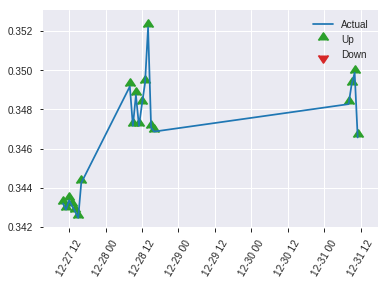


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24970847817060787
RMSE: 0.49970839313604476
LogLoss: 0.6925638799967742
Mean Per-Class Error: 0.4427284427284428
AUC: 0.5476994851994852
pr_auc: 0.5496535569738469
Gini: 0.09539897039897038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.484327490305323: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    111  0        (0.0/111.0)
Total  0    223  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484327     0.664671  201
max f2                       0.484327     0.832084  201
max f0point5                 0.488803     0.57572   171
max accuracy                 0.48894      0.556054  169
max precision                0.498135     1         0
max recall                   0.484327     1         201
max specificity              0.498135     1         0
max absolute_mcc             0.488803     0.136361  171
max min_per_class_accuracy   0.493577     0.517857  111
max mean_per_class_accuracy  0.488803     0.557272  171

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 49.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.497971           2.00901   2.00901            1                0.498034  1                           0.498034            0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.497729           1.0045    1.60721            0.5              0.497849  0.8                         0.49796             0.00900901      0.036036                   0.45045   60.7207
    3        0.0313901                   0.497472           0         1.14801            0                0.497703  0.571429                    0.497887            0               0.036036                   -100      14.8005
    4        0.0403587                   0.497184           1.0045    1.11612            0.5              0.497303  0.555556                    0.497757            0.00900901      0.045045                   0.45045   11.6116
    5        0.0538117                   0.496953           1.33934   1.17192            0.666667         0.497071  0.583333                    0.497586            0.018018        0.0630631                  33.9339   17.1922
    6        0.103139                    0.496486           1.4611    1.31022            0.727273         0.496748  0.652174                    0.497185            0.0720721       0.135135                   46.1097   31.0223
    7        0.152466                    0.496268           1.09582   1.24086            0.545455         0.496408  0.617647                    0.496933            0.0540541       0.189189                   9.58231   24.0859
    8        0.201794                    0.496004           0.913186  1.16076            0.454545         0.496142  0.577778                    0.49674             0.045045        0.234234                   -8.68141  16.0761
    9        0.300448                    0.495232           1.0045    1.10945            0.5              0.495664  0.552239                    0.496387            0.0990991       0.333333                   0.45045   10.9453
    10       0.399103                    0.494399           0.821867  1.03836            0.409091         0.494942  0.516854                    0.496029            0.0810811       0.414414                   -17.8133  3.83642
    11       0.502242                    0.493577           1.04818   1.04038            0.521739         0.493933  0.517857                    0.495599            0.108108        0.522523                   4.81786   4.03797
    12       0.600897                    0.491886           0.821867  1.0045             0.409091         0.492849  0.5                         0.495147            0.0810811       0.603604                   -17.8133  0.45045
    13       0.699552                    0.489821           1.4611    1.0689             0.727273         0.490781  0.532051                    0.494532            0.144144        0.747748                   46.1097   6.88958
    14       0.798206                    0.487295           0.821867  1.03836            0.409091         0.488947  0.516854                    0.493841            0.0810811       0.828829                   -17.8133  3.83642
    15       0.896861                    0.484401           1.0045    1.03464            0.5              0.485768  0.515                       0.492953            0.0990991       0.927928                   0.45045   3.46396
    16       1                           0.484327           0.698786  1                  0.347826         0.48433   0.497758                    0.492064         

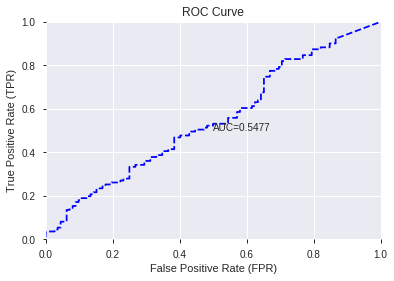

This function is available for GLM models only


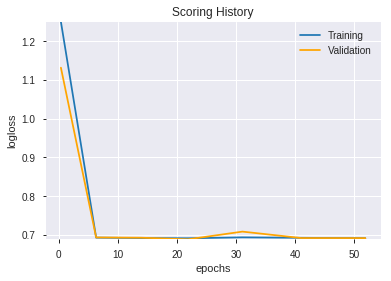

--2019-08-25 18:40:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.180
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.180|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_181345_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_181345_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['AROONOSC_30',
 'HT_TRENDMODE',
 'CORREL_12',
 'CORREL_14',
 'DX_14',
 'aroondown_30',
 'BETA_8',
 'ADXR_14',
 'ADXR_12',
 'SUB',
 'MACD',
 'aroonup_20',
 'BETA_12',
 'BETA_20',
 'aroonup_30',
 'aroondown_12',
 'WILLR_20',
 'MACDEXT_hist',
 'MACDFIX_signal_20',
 'aroondown_8',
 'NATR_24',
 'BOP',
 'BETA_24',
 'DX_30',
 'DX_20',
 'CCI_8',
 'OBV',
 'ATR_14',
 'CDLLONGLEGGEDDOJI',
 'STDDEV_24',
 'ADX_24',
 'MINUS_DM_12',
 'STOCHRSI_fastd',
 'DX_12',
 'RSI_24',
 'MINUS_DI_20',
 'MINUS_DM_20',
 'AD',
 'STOCHRSI_fastk',
 'aroondown_14',
 'MACDEXT_signal',
 'WILLR_24',
 'aroonup_8',
 'ATR_12',
 'MACDFIX_signal_14',
 'CORREL_8',
 'ADX_12',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'NATR_20',
 'MOM_30',
 'STOCHF_fastk',
 'AROONOSC_14',
 'PLUS_DI_8',
 'MACDFIX_hist_20',
 'CDLDOJI',
 'BETA_30',
 'MACDFIX_signal_24',
 'aroonup_24',
 'STOCH_slowd',
 'DX_8',
 'aroondown_20',
 'AROONOSC_12',
 'PLUS_DI_24',
 'AROONOSC_8',
 'AROONOSC_24',
 'AROONOSC_20',
 'CORREL_20',
 'CMO_30',
 'TRIX_14',
 'MINUS_DI_8',


In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_184050_model_1  0.449405  0.70174                   0.5  0.504251  0.254269

variable  relative_importance  scaled_importance  percentage
0                         SUB             0.008171           1.000000    0.011514
1                         DIV             0.007805           0.955180    0.010998
2                 CDLBELTHOLD             0.007607           0.930965    0.010720
3          CDLSEPARATINGLINES             0.007126           0.872009    0.010041
4                 CDLMARUBOZU             0.007111           0.870172    0.010020
..                        ...                  ...                ...         ...
742                  MAVP_8_8             0.000004           0.000527    0.000006
743                   MA_14_5             0.000003           0.000422    0.000005
744                    WMA_30             0.000002           0.000250    0.000003
745   BBANDS_lowerband_12_3_4             0.000002           0.000216    0.000002
746  BBANDS_middleband_14_5_3             0.000001           0.000169    0.000002

[747 rows x 4 columns]

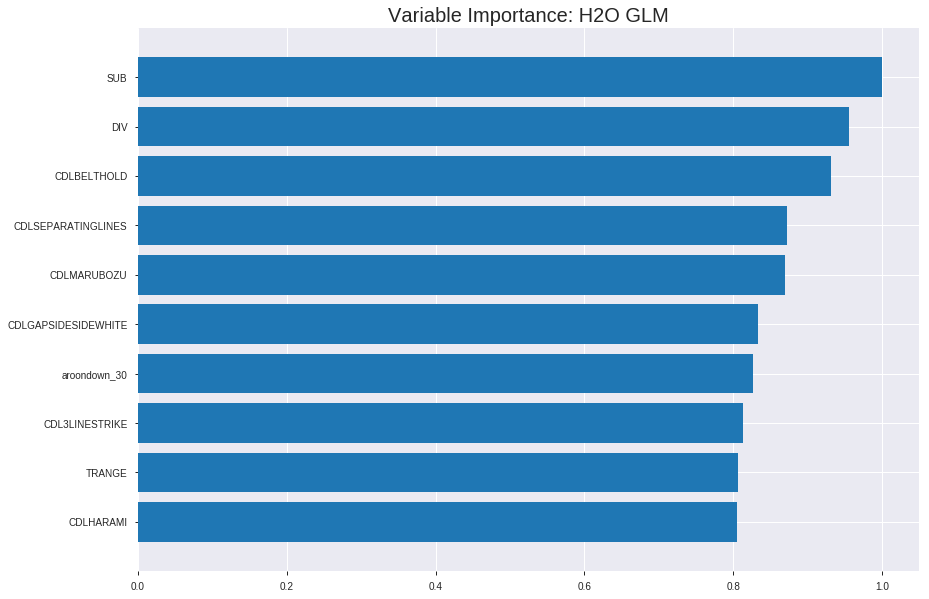

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_184050_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2459488151052818
RMSE: 0.495932268667085
LogLoss: 0.6850045675621127
Null degrees of freedom: 1556
Residual degrees of freedom: 809
Null deviance: 2156.0698562406105
Residual deviance: 2133.104223388419
AIC: 3629.104223388419
AUC: 0.591664298037453
pr_auc: 0.5551001682092168
Gini: 0.18332859607490604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44638136865176037: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      109  700   0.8653   (700.0/809.0)
1      44   704   0.0588   (44.0/748.0)
Total  153  1404  0.4778   (744.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446381     0.654275  342
max f2                       0.417672     0.822882  395
max f0point5                 0.46832      0.562977  253
max accuracy                 0.477794     0.572897  215
max precision                0.587639     1         0
max recall                   0.417672     1         395
max specificity              0.587639     1         0
max absolute_mcc             0.477794     0.147671  215
max min_per_class_accuracy   0.479749     0.566131  208
max mean_per_class_accuracy  0.477794     0.573828  215

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.551878           1.56116   1.56116            0.75             0.566148  0.75                        0.566148            0.0160428       0.0160428                  56.1163   56.1163
    2        0.0205523                   0.545206           1.17087   1.36602            0.5625           0.54856   0.65625                     0.557354            0.0120321       0.0280749                  17.0872   36.6018
    3        0.0301863                   0.538471           0.83262   1.19578            0.4              0.54234   0.574468                    0.552562            0.00802139      0.0360963                  -16.738   19.5785
    4        0.0404624                   0.533142           1.04078   1.15642            0.5              0.536262  0.555556                    0.548423            0.0106952       0.0467914                  4.07754   15.6417
    5        0.0500963                   0.529798           1.66524   1.25427            0.8              0.531505  0.602564                    0.545169            0.0160428       0.0628342                  66.5241   25.4268
    6        0.100193                    0.515551           1.30764   1.28095            0.628205         0.521176  0.615385                    0.533173            0.065508        0.128342                   30.7641   28.0954
    7        0.150289                    0.507595           1.06746   1.20979            0.512821         0.511266  0.581197                    0.52587             0.0534759       0.181818                   6.74619   20.979
    8        0.200385                    0.501609           1.17421   1.20089            0.564103         0.504506  0.576923                    0.520529            0.0588235       0.240642                   17.4208   20.0895
    9        0.299936                    0.492904           1.12807   1.17672            0.541935         0.497267  0.56531                     0.512809            0.112299        0.352941                   12.8066   17.6723
    10       0.400128                    0.486897           1.04078   1.14268            0.5              0.489829  0.548957                    0.507054            0.104278        0.457219                   4.07754   14.2681
    11       0.500321                    0.479464           1.10749   1.13563            0.532051         0.483486  0.545571                    0.502335            0.110963        0.568182                   10.7492   13.5634
    12       0.599872                    0.471799           1.03406   1.11878            0.496774         0.475685  0.537473                    0.497912            0.102941        0.671123                   3.40607   11.8778
    13       0.700064                    0.464087           0.907343  1.08852            0.435897         0.467611  0.522936                    0.493575            0.0909091       0.762032                   -9.26573  8.85174
    14       0.799615                    0.456971           0.940055  1.07003            0.451613         0.460614  0.514056                    0.489472            0.0935829       0.855615                   -5.99448  7.00341
    15       0.899807                    0.446821           0.827283  1.043              0.397436         0.45234   0.501071                    0.485337            0.0828877       0.938503                   -17.2717  4.3004
    16       1                           0.314566           0.613791  1                  0.294872         0.436171  0.480411                    0.480411           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24933986469070377
RMSE: 0.4993394283357802
LogLoss: 0.6918247732462725
Null degrees of freedom: 444
Residual degrees of freedom: -303
Null deviance: 615.6246511654862
Residual deviance: 615.7240481891824
AIC: 2111.724048189182
AUC: 0.5258966565349544
pr_auc: 0.4867510312740469
Gini: 0.051793313069908864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4393780018484469: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    230  0.9787   (230.0/235.0)
1      2    208  0.0095   (2.0/210.0)
Total  7    438  0.5213   (232.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.439378     0.641975   393
max f2                       0.43385      0.817121   399
max f0point5                 0.472644     0.537267   314
max accuracy                 0.547126     0.539326   14
max precision                0.547126     0.666667   14
max recall                   0.43385      1          399
max specificity              0.572887     0.995745   0
max absolute_mcc             0.472644     0.0860327  314
max min_per_class_accuracy   0.498979     0.506383   202
max mean_per_class_accuracy  0.472644     0.535309   314

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.555936           0.42381   0.42381            0.2              0.562968  0.2                         0.562968            0.0047619       0.0047619                  -57.619   -57.619
    2        0.0202247                   0.550886           1.58929   0.941799           0.75             0.55357   0.444444                    0.558791            0.0142857       0.0190476                  58.9286   -5.82011
    3        0.0314607                   0.547162           2.11905   1.36224            1                0.549056  0.642857                    0.555315            0.0238095       0.0428571                  111.905   36.2245
    4        0.0404494                   0.543359           1.05952   1.29497            0.5              0.545891  0.611111                    0.55322             0.00952381      0.052381                   5.95238   29.4974
    5        0.0516854                   0.542196           0.42381   1.10559            0.2              0.54267   0.521739                    0.550927            0.0047619       0.0571429                  -57.619   10.559
    6        0.101124                    0.534421           0.963203  1.03598            0.454545         0.537796  0.488889                    0.544508            0.047619        0.104762                   -3.67965  3.59788
    7        0.150562                    0.527219           0.963203  1.01208            0.454545         0.531087  0.477612                    0.540101            0.047619        0.152381                   -3.67965  1.20824
    8        0.2                         0.522368           1.25216   1.07143            0.590909         0.525196  0.505618                    0.536416            0.0619048       0.214286                   25.2165   7.14286
    9        0.301124                    0.514309           1.03598   1.05952            0.488889         0.518471  0.5                         0.53039             0.104762        0.319048                   3.59788   5.95238
    10       0.4                         0.506445           0.818723  1                  0.386364         0.509917  0.47191                     0.525329            0.0809524       0.4                        -18.1277  0
    11       0.501124                    0.498979           1.08307   1.01676            0.511111         0.502768  0.479821                    0.520776            0.109524        0.509524                   8.30688   1.67628
    12       0.6                         0.490003           1.15584   1.03968            0.545455         0.494538  0.490637                    0.516452            0.114286        0.62381                    15.5844   3.96825
    13       0.698876                    0.480181           0.915043  1.02205            0.431818         0.485683  0.482315                    0.512099            0.0904762       0.714286                   -8.49567  2.20487
    14       0.8                         0.471744           1.08307   1.02976            0.511111         0.475799  0.485955                    0.507511            0.109524        0.82381                    8.30688   2.97619
    15       0.898876                    0.460809           1.01136   1.02774            0.477273         0.466752  0.485                       0.503027            0.1             0.92381                    1.13636   2.77381
    16       1                           0.433848           0.753439  1                  0.355556         0.448796  0.47191                     0.497543            0.0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 18:40:52  0.000 sec   2            2.9       748           1.37001           1.38365
    2019-08-25 18:40:53  1.025 sec   4            2.1       748           1.36672           1.38428
    2019-08-25 18:40:54  2.012 sec   6            1.5       748           1.36291           1.38525
    2019-08-25 18:40:55  3.225 sec   8            1.1       748           1.35853           1.38658
    2019-08-25 18:40:56  4.202 sec   10           0.81      748           1.35361           1.38841

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5246636771300448)

('F1', 0.6646706586826348)

('auc', 0.4494047619047619)

('logloss', 0.7017396465539021)

('mean_per_class_error', 0.47731660231660233)

('rmse', 0.5042510667260188)

('mse', 0.25426913829432785)

glm prediction progress: |████████████████████████████████████████████████| 100%


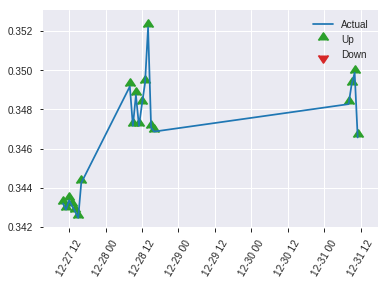


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25426913829432785
RMSE: 0.5042510667260188
LogLoss: 0.7017396465539021
Null degrees of freedom: 222
Residual degrees of freedom: -525
Null deviance: 309.40779410652675
Residual deviance: 312.9758823630404
AIC: 1808.9758823630405
AUC: 0.4494047619047619
pr_auc: 0.49513757356969074
Gini: -0.10119047619047616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46749902079037575: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    111  0        (0.0/111.0)
Total  0    223  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467499     0.664671  222
max f2                       0.467499     0.832084  222
max f0point5                 0.505454     0.557308  209
max accuracy                 0.58277      0.524664  4
max precision                0.593008     1         0
max recall                   0.467499     1         222
max specificity              0.593008     1         0
max absolute_mcc             0.58277      0.152126  4
max min_per_class_accuracy   0.546735     0.45045   109
max mean_per_class_accuracy  0.576598     0.522683  12

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 54.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.583953           2.00901   2.00901            1                0.58716   1                           0.58716             0.027027        0.027027                   100.901   100.901
    2        0.0224215                   0.58261            2.00901   2.00901            1                0.583283  1                           0.585609            0.018018        0.045045                   100.901   100.901
    3        0.0313901                   0.581385           0         1.43501            0                0.581983  0.714286                    0.584573            0               0.045045                   -100      43.5006
    4        0.0403587                   0.580671           1.0045    1.33934            0.5              0.581022  0.666667                    0.583784            0.00900901      0.0540541                  0.45045   33.9339
    5        0.0538117                   0.57671            1.33934   1.33934            0.666667         0.57814   0.666667                    0.582373            0.018018        0.0720721                  33.9339   33.9339
    6        0.103139                    0.571379           0.913186  1.13553            0.454545         0.573738  0.565217                    0.578243            0.045045        0.117117                   -8.68141  13.5527
    7        0.152466                    0.566642           0.913186  1.06359            0.454545         0.569061  0.529412                    0.575273            0.045045        0.162162                   -8.68141  6.3593
    8        0.201794                    0.56317            0.730549  0.982182           0.363636         0.564733  0.488889                    0.572696            0.036036        0.198198                   -26.9451  -1.78178
    9        0.300448                    0.557947           0.547912  0.839586           0.272727         0.560513  0.41791                     0.568696            0.0540541       0.252252                   -45.2088  -16.0414
    10       0.399103                    0.551663           0.913186  0.857779           0.454545         0.555368  0.426966                    0.565401            0.0900901       0.342342                   -8.68141  -14.2221
    11       0.502242                    0.54665            1.04818   0.896879           0.521739         0.549395  0.446429                    0.562114            0.108108        0.45045                    4.81786   -10.3121
    12       0.600897                    0.540615           1.18714   0.944534           0.590909         0.54343   0.470149                    0.559047            0.117117        0.567568                   18.7142   -5.54659
    13       0.699552                    0.534177           0.821867  0.927235           0.409091         0.537064  0.461538                    0.555946            0.0810811       0.648649                   -17.8133  -7.27651
    14       0.798206                    0.523247           1.09582   0.948072           0.545455         0.529179  0.47191                     0.552638            0.108108        0.756757                   9.58231   -5.19283
    15       0.896861                    0.51212            1.27846   0.984414           0.636364         0.518289  0.49                        0.54886             0.126126        0.882883                   27.846    -1.55856
    16       1                           0.467499           1.13553   1                  0.565217         0.498515  0.497758                    0.543667  

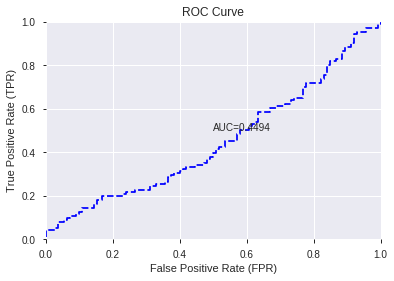

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


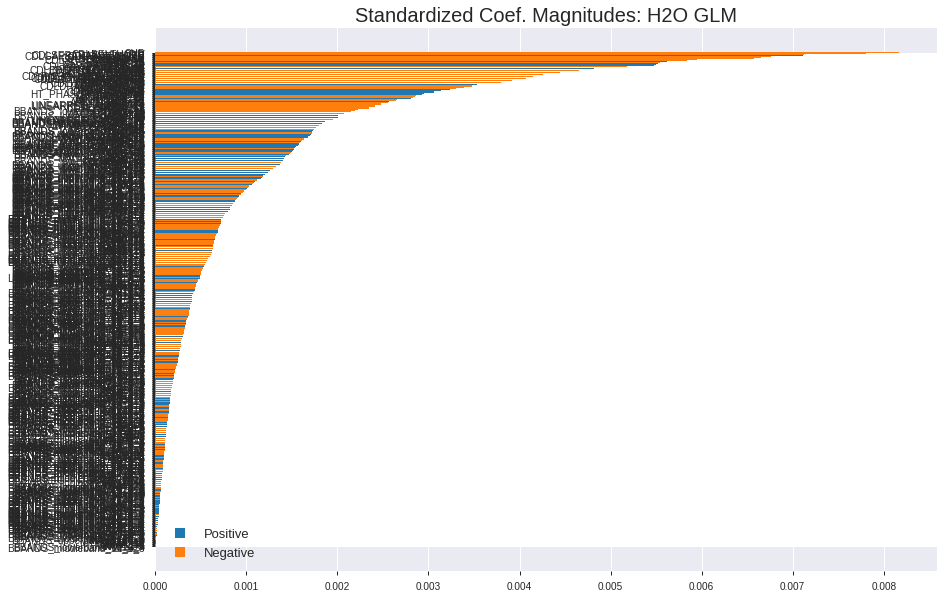

'log_likelihood'
--2019-08-25 18:41:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.100
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.100|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_184050_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_184050_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['SUB',
 'DIV',
 'CDLBELTHOLD',
 'CDLSEPARATINGLINES',
 'CDLMARUBOZU',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_30',
 'CDL3LINESTRIKE',
 'TRANGE',
 'CDLHARAMI',
 'CDLSHOOTINGSTAR',
 'CORREL_8',
 'HT_TRENDMODE',
 'BETA_14',
 'aroonup_14',
 'DX_12',
 'BETA_12',
 'aroonup_12',
 'AROONOSC_30',
 'CDLADVANCEBLOCK',
 'DX_14',
 'STOCHRSI_fastd',
 'CORREL_24',
 'AD',
 'CDLHIKKAKEMOD',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'MINUS_DI_14',
 'DX_8',
 'MINUS_DI_20',
 'CDLSPINNINGTOP',
 'VAR_30',
 'DX_20',
 'MINUS_DI_24',
 'CDLTAKURI',
 'CDLRISEFALL3METHODS',
 'HT_PHASOR_inphase',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLPIERCING',
 'MINUS_DI_30',
 'CDLDOJISTAR',
 'MINUS_DI_8',
 'CDLHARAMICROSS',
 'STDDEV_30',
 'VAR_24',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'DX_24',
 'MACDEXT_hist',
 'MFI_24',
 'STOCH_slowd',
 'MINUS_DM_8',
 'CDLHIGHWAVE',
 'aroondown_8',
 'CDLHAMMER',
 'VAR_14',
 'CDLENGULFING',
 'VAR_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'aroonup_

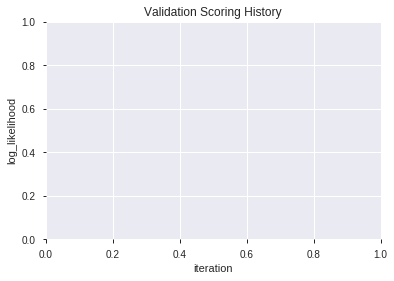

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_184118_model_1  0.549469  0.733588              0.473415  0.518237  0.268570
1  XGBoost_grid_1_AutoML_20190825_184118_model_7  0.533140  0.723315              0.491071  0.513795  0.263985
2               XGBoost_2_AutoML_20190825_184118  0.532899  0.712346              0.473255  0.508949  0.259029
3  XGBoost_grid_1_AutoML_20190825_184118_model_6  0.523970  0.720341              0.486647  0.512463  0.262618
4               XGBoost_1_AutoML_20190825_184118  0.512709  0.729165              0.500000  0.516397  0.266666
5  XGBoost_grid_1_AutoML_20190825_184118_model_2  0.511663  0.703166              0.500000  0.504840  0.254864
6  XGBoost_grid_1_AutoML_20190825_184118_model_5  0.510618  0.766226              0.455478  0.531204  0.282178
7  XGBoost_grid_1_AutoML_20190825_184118_model_4  0.509733  0.703015              0.486647  0.504721  0.254744
8               XGBoost_3_AutoML_20190825_184118  0.508044  0.736949              0.500000  0.519888  0.270284
9  XGBoost_grid_1_AutoML_20190825_184118_model_3  0.476432  0.746597              0.500000  0.524117  0.274699

variable  relative_importance  scaled_importance  percentage
0                        DIV           167.006851           1.000000    0.035918
1                     CCI_12           154.245316           0.923587    0.033173
2                      ATR_8           150.664978           0.902148    0.032403
3             STOCHRSI_fastd           135.703796           0.812564    0.029185
4                    BETA_14           109.241455           0.654114    0.023494
..                       ...                  ...                ...         ...
196                  ROCP_24             2.423284           0.014510    0.000521
197  BBANDS_upperband_24_3_2             2.303304           0.013792    0.000495
198                   SMA_20             2.246272           0.013450    0.000483
199                   ADX_20             2.065955           0.012370    0.000444
200                STDDEV_12             1.677427           0.010044    0.000361

[201 rows x 4 columns]

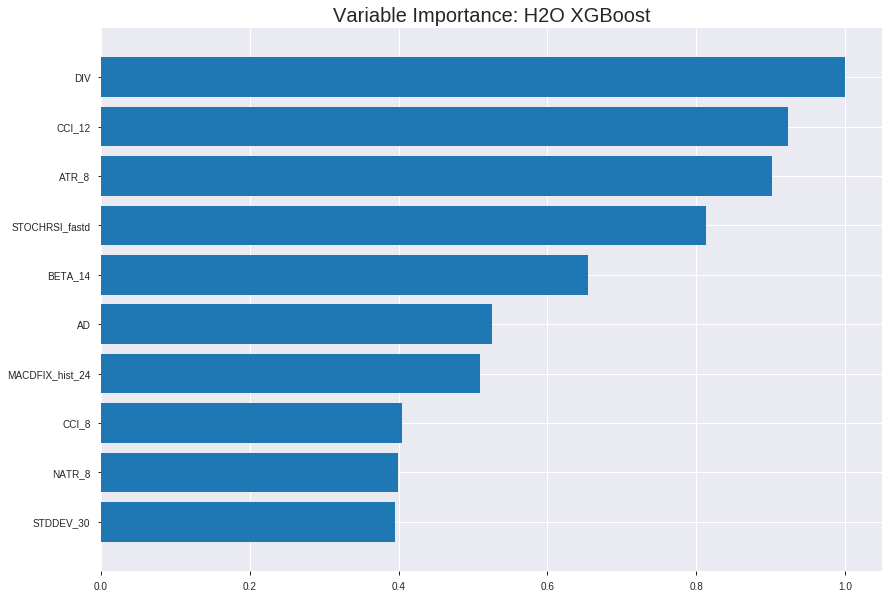

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_184118_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17928964639013234
RMSE: 0.42342608137682347
LogLoss: 0.5470256085158942
Mean Per-Class Error: 0.1395860737822492
AUC: 0.9350290515127279
pr_auc: 0.927124563246914
Gini: 0.8700581030254557
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47543467794145855: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      674  135  0.1669   (135.0/809.0)
1      84   664  0.1123   (84.0/748.0)
Total  758  799  0.1407   (219.0/1557.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475435     0.858436  210
max f2                       0.42847      0.902604  253
max f0point5                 0.495277     0.866609  189
max accuracy                 0.484329     0.859987  201
max precision                0.823954     1         0
max recall                   0.35925      1         321
max specificity              0.823954     1         0
max absolute_mcc             0.475435     0.720524  210
max min_per_class_accuracy   0.481299     0.855615  204
max mean_per_class_accuracy  0.475435     0.860414  210

Gains/Lift Table: Avg response rate: 48.04 %, avg score: 48.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102762                   0.749962           2.08155    2.08155            1                0.77382   1                           0.77382             0.0213904       0.0213904                  108.155   108.155
    2        0.0205523                   0.720757           2.08155    2.08155            1                0.731127  1                           0.752473            0.0213904       0.0427807                  108.155   108.155
    3        0.0301863                   0.705791           2.08155    2.08155            1                0.711782  1                           0.739487            0.0200535       0.0628342                  108.155   108.155
    4        0.0404624                   0.697014           2.08155    2.08155            1                0.701048  1                           0.729725            0.0213904       0.0842246                  108.155   108.155
    5        0.0500963                   0.689283           2.08155    2.08155            1                0.692722  1                           0.722609            0.0200535       0.104278                   108.155   108.155
    6        0.100193                    0.641254           2.05486    2.06821            0.987179         0.662057  0.99359                     0.692333            0.102941        0.207219                   105.486   106.821
    7        0.150289                    0.608595           1.9748     2.03707            0.948718         0.624193  0.978632                    0.66962             0.0989305       0.30615                    97.4805   103.707
    8        0.200385                    0.584061           2.00149    2.02818            0.961538         0.596099  0.974359                    0.651239            0.100267        0.406417                   100.149   102.818
    9        0.299936                    0.542242           1.7861     1.94783            0.858065         0.562447  0.93576                     0.621769            0.177807        0.584225                   78.6105   94.7832
    10       0.400128                    0.507806           1.62788    1.86772            0.782051         0.524461  0.897271                    0.597403            0.163102        0.747326                   62.7879   86.7716
    11       0.500321                    0.477498           1.25427    1.74487            0.602564         0.491366  0.838254                    0.576168            0.125668        0.872995                   25.4268   74.4869
    12       0.599872                    0.442928           0.738615   1.57788            0.354839         0.461449  0.75803                     0.55713             0.0735294       0.946524                   -26.1385  57.7878
    13       0.700064                    0.410701           0.346925   1.4017             0.166667         0.426536  0.673394                    0.53844             0.0347594       0.981283                   -65.3075  40.1705
    14       0.799615                    0.379888           0.147723   1.24559            0.0709677        0.395521  0.598394                    0.520646            0.0147059       0.995989                   -85.2277  24.5587
    15       0.899807                    0.335201           0.0400298  1.11135            0.0192308        0.358936  0.533904                    0.50264             0.0040107       1                          -95.997   11.1349
    16       1                           0.189721           0          1                  0                0.296043  0.480411                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26538652048975175
RMSE: 0.5151567921417243
LogLoss: 0.7252198662690488
Mean Per-Class Error: 0.4689969604863222
AUC: 0.5003951367781155
pr_auc: 0.49374746195287306
Gini: 0.0007902735562310692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33740653097629547: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    228  0.9702   (228.0/235.0)
1      2    208  0.0095   (2.0/210.0)
Total  9    436  0.5169   (230.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337407     0.643963  390
max f2                       0.32522      0.818394  397
max f0point5                 0.337407     0.532242  390
max accuracy                 0.701539     0.552809  23
max precision                0.78538      1         0
max recall                   0.32522      1         397
max specificity              0.78538      1         0
max absolute_mcc             0.701539     0.115164  23
max min_per_class_accuracy   0.560164     0.485714  190
max mean_per_class_accuracy  0.609453     0.531003  119

Gains/Lift Table: Avg response rate: 47.19 %, avg score: 54.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.749707           1.69524   1.69524            0.8              0.763538  0.8                         0.763538            0.0190476       0.0190476                  69.5238   69.5238
    2        0.0202247                   0.734376           1.05952   1.4127             0.5              0.742081  0.666667                    0.754001            0.00952381      0.0285714                  5.95238   41.2698
    3        0.0314607                   0.722479           1.27143   1.36224            0.6              0.730657  0.642857                    0.745664            0.0142857       0.0428571                  27.1429   36.2245
    4        0.0404494                   0.718381           1.05952   1.29497            0.5              0.720692  0.611111                    0.740115            0.00952381      0.052381                   5.95238   29.4974
    5        0.0516854                   0.70525            1.27143   1.28986            0.6              0.709422  0.608696                    0.733442            0.0142857       0.0666667                  27.1429   28.9855
    6        0.101124                    0.678888           1.05952   1.17725            0.5              0.691518  0.555556                    0.712946            0.052381        0.119048                   5.95238   17.7249
    7        0.150562                    0.661577           0.674242  1.01208            0.318182         0.670561  0.477612                    0.699028            0.0333333       0.152381                   -32.5758  1.20824
    8        0.2                         0.644929           1.25216   1.07143            0.590909         0.654502  0.505618                    0.688022            0.0619048       0.214286                   25.2165   7.14286
    9        0.301124                    0.612092           1.13016   1.09115            0.533333         0.627912  0.514925                    0.667836            0.114286        0.328571                   13.0159   9.11514
    10       0.4                         0.583147           0.722403  1                  0.340909         0.596124  0.47191                     0.650109            0.0714286       0.4                        -27.7597  0
    11       0.501124                    0.558856           0.847619  0.96925            0.4              0.571822  0.457399                    0.634311            0.0857143       0.485714                   -15.2381  -3.07495
    12       0.6                         0.525782           0.866883  0.952381           0.409091         0.542965  0.449438                    0.619258            0.0857143       0.571429                   -13.3117  -4.7619
    13       0.698876                    0.494701           0.963203  0.953912           0.454545         0.510371  0.450161                    0.603853            0.0952381       0.666667                   -3.67965  -4.60879
    14       0.8                         0.448155           1.27143   0.994048           0.6              0.472004  0.469101                    0.587187            0.128571        0.795238                   27.1429   -0.595238
    15       0.898876                    0.409703           1.10768   1.00655            0.522727         0.4267    0.475                       0.569533            0.109524        0.904762                   10.7684   0.654762
    16       1                           0.313512           0.941799  1                  0.444444         0.365094  0.47191                     0.548859          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 18:41:28  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.519589                         0.5                0.693147              0.5               0                    1                  0.52809
    2019-08-25 18:41:28  0.402 sec   5                  0.490411         0.674074            0.700277        0.698899           2.08155          0.395633                         0.501589           0.696342              0.487812          0.463132             1.23611            0.525843
    2019-08-25 18:41:29  0.526 sec   10                 0.480608         0.654775            0.79257         0.771561           2.08155          0.330764                         0.504187           0.701662              0.488197          0.467008             1.27143            0.52809
    2019-08-25 18:41:29  0.656 sec   15                 0.469433         0.633141            0.850366        0.829434           2.08155          0.237636                         0.507011           0.707524              0.475319          0.448772             0.42381            0.523596
    2019-08-25 18:41:29  0.787 sec   20                 0.459588         0.614352            0.878622        0.862159           2.08155          0.208092                         0.507455           0.708455              0.484458          0.463952             1.27143            0.523596
    2019-08-25 18:41:29  0.909 sec   25                 0.452994         0.601835            0.890028        0.874506           2.08155          0.193963                         0.50859            0.710867              0.489007          0.470036             0.847619           0.519101
    2019-08-25 18:41:29  1.028 sec   30                 0.446896         0.59036             0.901699        0.889288           2.08155          0.191394                         0.509665           0.713112              0.488298          0.474307             0.847619           0.519101
    2019-08-25 18:41:29  1.163 sec   35                 0.440138         0.577739            0.911442        0.900918           2.08155          0.172768                         0.511568           0.717102              0.493333          0.486314             1.27143            0.516854
    2019-08-25 18:41:29  1.295 sec   40                 0.432291         0.563293            0.924321        0.915716           2.08155          0.157996                         0.513339           0.72108               0.499838          0.483838             0.847619           0.510112
    2019-08-25 18:41:29  1.410 sec   45                 0.428809         0.556847            0.927604        0.919615           2.08155          0.151574                         0.513627           0.721721              0.501591          0.492482             1.27143            0.516854
    2019-08-25 18:41:30  1.533 sec   50                 0.423426         0.547026            0.935029        0.927125           2.08155          0.140655                         0.515157           0.72522               0.500395          0.493747             1.69524            0.516854

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
DIV                      167.00685119628906     1.0                   0.03591776820779267
CCI_12                   154.2453155517578      0.9235867537581907    0.03317317494127438
ATR_8                    150.66497802734375     0.9021484864130626    0.03240316022399538
STOCHRSI_fastd           135.70379638671875     0.8125642476021614    0.029185494299313882
BETA_14                  109.241455078125       0.6541136144751909    0.023494301186281364
---                      ---                    ---                   ---
ROCP_24                  2.4232840538024902     0.014510087678704382  0.0005211699659184524
BBANDS_upperband_24_3_2  2.3033037185668945     0.013791672030626697  0.0004953660791939469
SMA_20                   2.246272087097168      0.01345017926514311   0.00048310042119866935
ADX_20                   2.06595516204834       0.012370481493721174  0.000444320086910266
STDDEV_12                1.6774272918701172     0.01004406274266304   0.00036076031745549734


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6666666666666667)

('auc', 0.549469111969112)

('logloss', 0.7335879068057151)

('mean_per_class_error', 0.4207287644787645)

('rmse', 0.5182371000223294)

('mse', 0.26856969183955376)

xgboost prediction progress: |████████████████████████████████████████████| 100%


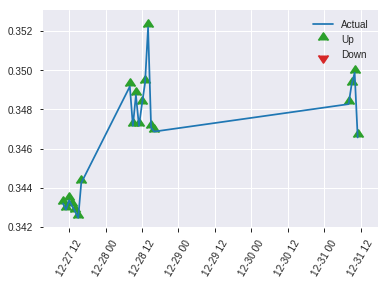


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26856969183955376
RMSE: 0.5182371000223294
LogLoss: 0.7335879068057151
Mean Per-Class Error: 0.4207287644787645
AUC: 0.549469111969112
pr_auc: 0.509497580608775
Gini: 0.09893822393822393
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.551957905292511: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   101  0.9018   (101.0/112.0)
1      5    106  0.045    (5.0/111.0)
Total  16   207  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.551958     0.666667  206
max f2                       0.4633       0.832084  222
max f0point5                 0.615906     0.587413  150
max accuracy                 0.615906     0.578475  150
max precision                0.615906     0.556291  150
max recall                   0.4633       1         222
max specificity              0.819032     0.991071  0
max absolute_mcc             0.615906     0.169536  150
max min_per_class_accuracy   0.641738     0.535714  111
max mean_per_class_accuracy  0.615906     0.579271  150

Gains/Lift Table: Avg response rate: 49.78 %, avg score: 63.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.747739           0.66967   0.66967            0.333333         0.776562  0.333333                    0.776562            0.00900901      0.00900901                 -33.033   -33.033
    2        0.0224215                   0.734169           0         0.401802           0                0.740309  0.2                         0.762061            0               0.00900901                 -100      -59.8198
    3        0.0313901                   0.729447           1.0045    0.574003           0.5              0.732577  0.285714                    0.753637            0.00900901      0.018018                   0.45045   -42.5997
    4        0.0403587                   0.720177           1.0045    0.66967            0.5              0.724641  0.333333                    0.747193            0.00900901      0.027027                   0.45045   -33.033
    5        0.0538117                   0.717422           1.33934   0.837087           0.666667         0.718683  0.416667                    0.740066            0.018018        0.045045                   33.9339   -16.2913
    6        0.103139                    0.706039           1.27846   1.04818            0.636364         0.711244  0.521739                    0.726281            0.0630631       0.108108                   27.846    4.81786
    7        0.152466                    0.697873           0.730549  0.945416           0.363636         0.701649  0.470588                    0.718312            0.036036        0.144144                   -26.9451  -5.4584
    8        0.201794                    0.68524            1.4611    1.07147            0.727273         0.691933  0.533333                    0.711864            0.0720721       0.216216                   46.1097   7.14715
    9        0.300448                    0.669689           0.913186  1.0195             0.454545         0.675282  0.507463                    0.699852            0.0900901       0.306306                   -8.68141  1.94971
    10       0.399103                    0.655796           1.0045    1.01579            0.5              0.662946  0.505618                    0.690729            0.0990991       0.405405                   0.45045   1.57911
    11       0.502242                    0.641738           1.31022   1.07625            0.652174         0.647943  0.535714                    0.681943            0.135135        0.540541                   31.0223   7.62548
    12       0.600897                    0.627439           1.18714   1.09446            0.590909         0.634964  0.544776                    0.67423             0.117117        0.657658                   18.7142   9.44601
    13       0.699552                    0.61078            1.09582   1.09465            0.545455         0.619697  0.544872                    0.666539            0.108108        0.765766                   9.58231   9.46523
    14       0.798206                    0.597885           0.730549  1.04965            0.363636         0.60411   0.522472                    0.658823            0.0720721       0.837838                   -26.9451  4.96508
    15       0.896861                    0.56087            0.913186  1.03464            0.454545         0.585177  0.515                       0.650722            0.0900901       0.927928                   -8.68141  3.46396
    16       1                           0.4633             0.698786  1                  0.347826         0.529321  0.497758                    0.638201      

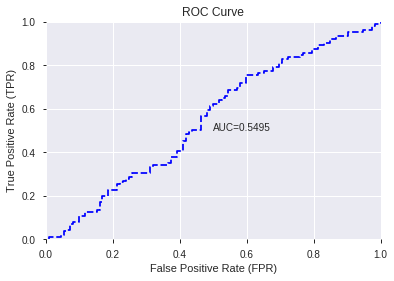

This function is available for GLM models only


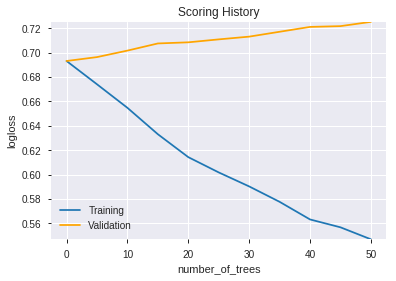

--2019-08-25 18:41:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_184118_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_184118_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_afd9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['DIV',
 'CCI_12',
 'ATR_8',
 'STOCHRSI_fastd',
 'BETA_14',
 'AD',
 'MACDFIX_hist_24',
 'CCI_8',
 'NATR_8',
 'STDDEV_30',
 'BETA_30',
 'DX_12',
 'PLUS_DM_8',
 'CDLHARAMI',
 'BOP',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'BBANDS_lowerband_30_7_3',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'PLUS_DM_30',
 'MACDEXT_hist',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_12',
 'TRANGE',
 'BETA_20',
 'CMO_20',
 'ADOSC',
 'PLUS_DI_12',
 'MFI_30',
 'ROC_30',
 'PLUS_DI_8',
 'MACDFIX_hist_20',
 'ATR_12',
 'STDDEV_8',
 'WILLR_24',
 'BBANDS_lowerband_14_7_5',
 'ADX_12',
 'BBANDS_lowerband_8_7_5',
 'NATR_30',
 'MINUS_DI_24',
 'CCI_14',
 'AROONOSC_30',
 'SUB',
 'STDDEV_24',
 'CCI_24',
 'CDLHIKKAKE',
 'DX_14',
 'BETA_12',
 'MOM_24',
 'ULTOSC',
 'OBV',
 'BBANDS_lowerband_20_6_3',
 'MINUS_DM_14',
 'ADXR_8',
 'HT_PHASOR_quadrature',
 'STDDEV_20',
 'ADXR_12',
 'BBANDS_lowerband_30_7_5',
 'BBANDS_lowerband_12_7_5',
 'BBANDS_lowerband_12_6_2',
 'STOCHRSI_fastk',
 'PLUS_DI_14',
 'AROONOSC_12',
 'NATR_12',
 'MINUS_DI_14',
 'W

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.574
GLM             0.543
XGBoost         0.610
dtype: float64

DeepLearning    GLM  XGBoost
All          0.565  0.529    0.610
DLF          0.547  0.543    0.543
Fwe          0.552  0.529    0.610
RFE          0.556  0.525    0.578
XGBF         0.574  0.543    0.543





F1


DeepLearning    0.669
GLM             0.667
XGBoost         0.688
dtype: float64

DeepLearning    GLM  XGBoost
All          0.669  0.665    0.688
DLF          0.665  0.667    0.667
Fwe          0.667  0.665    0.688
RFE          0.665  0.665    0.667
XGBF         0.669  0.667    0.667





auc


DeepLearning    0.556
GLM             0.515
XGBoost         0.605
dtype: float64

DeepLearning    GLM  XGBoost
All          0.556  0.451    0.605
DLF          0.517  0.515    0.532
Fwe          0.515  0.451    0.605
RFE          0.548  0.449    0.549
XGBF         0.538  0.515    0.532





logloss


DeepLearning    1.326
GLM             0.702
XGBoost         0.734
dtype: float64

DeepLearning    GLM  XGBoost
All          1.326  0.702    0.685
DLF          0.686  0.690    0.718
Fwe          1.223  0.702    0.685
RFE          0.693  0.702    0.734
XGBF         0.691  0.690    0.718





mean_per_class_error


DeepLearning    0.454
GLM             0.477
XGBoost         0.457
dtype: float64

DeepLearning    GLM  XGBoost
All          0.434  0.473    0.390
DLF          0.454  0.459    0.457
Fwe          0.447  0.473    0.390
RFE          0.443  0.477    0.421
XGBF         0.426  0.459    0.457





rmse


DeepLearning    0.627
GLM             0.504
XGBoost         0.518
dtype: float64

DeepLearning    GLM  XGBoost
All          0.627  0.504    0.496
DLF          0.498  0.499    0.511
Fwe          0.618  0.504    0.496
RFE          0.500  0.504    0.518
XGBF         0.499  0.499    0.511





mse


DeepLearning    0.393
GLM             0.254
XGBoost         0.269
dtype: float64

DeepLearning    GLM  XGBoost
All          0.393  0.254    0.246
DLF          0.248  0.249    0.261
Fwe          0.382  0.254    0.246
RFE          0.250  0.254    0.269
XGBF         0.249  0.249    0.261

{'F1':       DeepLearning    GLM  XGBoost
 All          0.669    NaN      NaN
 DLF          0.665    NaN      NaN
 DLF            NaN  0.667      NaN
 DLF            NaN    NaN    0.667
 All            NaN  0.665      NaN
 All            NaN    NaN    0.688
 XGBF         0.669    NaN      NaN
 XGBF           NaN  0.667      NaN
 XGBF           NaN    NaN    0.667
 Fwe          0.667    NaN      NaN
 Fwe            NaN  0.665      NaN
 Fwe            NaN    NaN    0.688
 RFE          0.665    NaN      NaN
 RFE            NaN  0.665      NaN
 RFE            NaN    NaN    0.667,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.565    NaN      NaN
 DLF          0.547    NaN      NaN
 DLF            NaN  0.543      NaN
 DLF            NaN    NaN    0.543
 All            NaN  0.529      NaN
 All            NaN    NaN    0.610
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.543      NaN
 XGBF           NaN    NaN    0.543
 Fwe          0.552    NaN      NaN
 Fwe     